# Deriving formant estimates from the VTRs

We estimate formant center frequency and bandwidth using the spectral envelope of the VT transfer function containing the VTRs.

To get this envelope, we use heuristics: smoothing (low-pass filtering) and peak-picking. Error bars are obtained by repeating this procedure for each sample from the VT transfer function posterior.

Our heuristics are similar to Hanna (2016):

> [T]he approximate location of the maxima
and minima of the impedance spectra were identified with a
sixth order Savitzky–Golay smoothing filter (Savitzky and
Golay, 1964). Parabolas were fitted to both sides of each of
the extrema and their crossover point used to determine the
frequency f and the impedance magnitude jZj. The bandwidth B was
determined as the frequency range at half maximum power. (p. 2927)

But we use a 6th order Butterworth filter (lowpass) to smooth the power spectrum (in dB). (6th order works empirically well -- order too low rounds the peaks too much such that the bandwidth estimates at -3 dB from peak level are too large; order too high and you get ripples and overshoot.)

Thus $B$ is determined from the FWHM, or -3 dB from the local maximum of the power spectral envelope. This is standard practice for researchers measuring directly from the spectral envelope (rather than root-solving procedures as e.g. advocated by Fulup 2011 and used e.g. by Praat) and underlies the empirical data used for the Hawks relationship.

## Sensitivities

We take the rough value estimates from Pinson (1952)'s error analysis last page: $$\sigma_F = 2, 7, 29\ Hz$$ $$\sigma_B = 4, 14, 58\ Hz$$
Note that these last values are chosen as double of the first ones, in remarkable agreement with Mehta and Wolfe (2015) theoretical analysis based on LP root solving for $F$ and $B$ "that the accuracy of bandwidth estimates is also lower
(approximately **twice as low**) as that of center frequency
estimates."

In [1]:
%run init.ipy
import scipy.signal
import scipy.stats
from dgf import core
from vtr import peak
from vtr.prior import allpole
from vtr.prior import bandwidth
from lib import constants

2022-11-11 09:12:58.052098: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]4.5s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]18.3s, 0.3min   : Loading run_nested...
[Memory]19.8s, 0.3min   : Loading run_nested...
[Memory]21.2s, 0.4min   : Loading run_nested...
[Memory]22.6s, 0.4min   : Loading run_nested...
[Memory]22.6s, 0.4min   : Loading get_aplawd_training_pairs...


[Memory]26.2s, 0.4min   : Loading get_vtrformants_training_data...
[Memory]33.6s, 0.6min   : Loading run_nested...
[Memory]34.5s, 0.6min   : Loading run_nested...
[Memory]35.4s, 0.6min   : Loading run_nested...
[Memory]36.3s, 0.6min   : Loading run_nested...
[Memory]36.3s, 0.6min   : Loading get_vtrformants_training_data...


In [2]:
fs = constants.FS_KHZ*1000
df = 1. # Hz -- sampling interval in the frequency domain
f = np.arange(0, fs/2, df)

## Smoothing parameter

The Butterworth filter's cutoff frequency $f_c$ must lie between $(0, F_s/2)$ where $F_s$ is the **liftering** sampling frequency. We will generally sample the spectrum at $df = 1\ Hz$, so $F_s = 1\ sec$. We parametrize the cutoff **quefrency** as $f_c = \rho F_s/2 \ sec$ where $\rho \sim \text{Beta}(5/4, 1)$. This follows from:
- We want the cutoff frequency to be as *large* as possible to discourage too much smoothing, because then the bandwidths can get arbitrarily small (the huge sharp peaks will be smoothed to normal peaks such that very small bandwidths with very small $\rho$ is a valid solution for our inference problem). We avoid this by bounding the bandwidths and having the prior for $\rho$ discourage very small $\rho$ values.
- We know that the typical *period* of unwanted ripples on the spectrum is of $f_c = O(10 \ Hz)$ corresponding to a liftering *quefrency* of $1/f_c = 1/10\ sec$, corresponding to $\rho = 0.2$ given $F_s=1\ sec$. Then we assign the beta parameter as $\beta = 1$ and solve for $\alpha = 5/4$ under the constraint $E(\rho) = 0.2$. The hyperparameters thus depend on $df$. $df = 1\ Hz$ is a good choice because the formant resolution is only of O(10 Hz) anyway.

In [201]:
Fs = 1/df # sec

expected_ripple_period = 10. # Hz

quefrency = 1/expected_ripple_period
rho_expected = quefrency / (Fs / 2)
rho_expected

0.2

In [202]:
mu = rho_expected
var = .2**2

assert var < mu*(1-mu)
alpha = mu*(mu*(1-mu)/var - 1)
beta = (1-mu)*alpha/mu

alpha, beta

(0.6000000000000001, 2.4000000000000004)

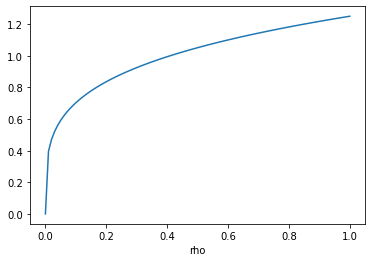

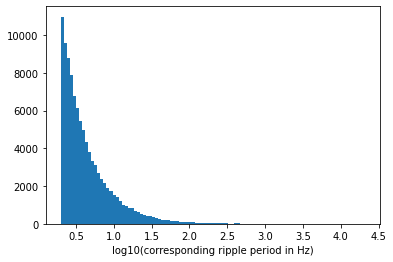

In [238]:
def plotbeta(alpha, beta):
    rho = linspace(0, 1, 100)
    Beta = scipy.stats.beta(alpha, beta)
    plot(rho, Beta.pdf(rho))
    xlabel("rho")
    show()
    ##
    rho = Beta.rvs(int(1e5))
    period = 1/(rho * (Fs / 2))
    hist(log10(period), bins=100)
    xlabel("log10(corresponding ripple period in Hz)")
    show()
#plotbeta(3, 12)
plotbeta(5/4, 1)

## Peak picking paremeters

The peak picking algorithm has two important parameters:
- Minimum peak distance: we fix this at 100 Hz, which is around the 0.025% percentile value for the formant peak distances in the VTRFormants dataset
- Peak prominence $h$: how high a peak must be at the least from its surrounding valleys to be counted as a peak. This is of order 3 dB, so we assign $h \sim \text{Exp}(1)$ prior to it.

In [43]:
from vtr.prior import formant
training_data = formant.get_vtrformants_training_data()

[Memory]13691.6s, 228.2min: Loading get_vtrformants_training_data...


98.28778233705386

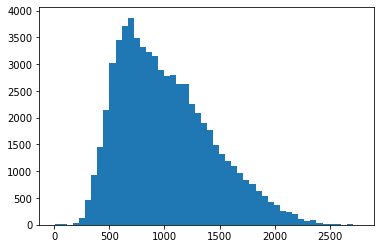

In [45]:
F = np.vstack(training_data['true_F_trajectories'])
d = np.abs(np.diff(F, axis=1).flatten())
hist(d, bins=50)
percentile(d, .025)

## Test the algorithm

In [46]:
prior = bandwidth.TFB_prior()

def sample_power_spectrum_dB(K=3, key=None):
    key = key if key is not None else jaxkey()
    T, *xy = prior.sample(seed=key)
    xy = np.array(xy)
    x, y = np.split(xy, 2)
    x = x[:K]
    y = y[:K]
    poles = core.make_poles(y, x)
    power = allpole.transfer_function_power_dB(f/1000, poles)
    return key, x, y, power

[Memory]13749.8s, 229.2min: Loading get_vtrformants_training_data...
[Memory]13750.3s, 229.2min: Loading run_nested...
[Memory]13750.7s, 229.2min: Loading run_nested...


[      0 2156321]
rho = 0.07384352961487531 => Dampen ripples on spectrum with period smaller than = 27.084295813469794 Hz
Peak prominence: h = 1.2334239278903505 dB
F = [ 480.88038501 1487.88697514 2514.04133474]
F^ = [ 481.00769612 1487.02379238 2513.04020864]
B = [39.54334402 47.21026195 49.78209641]
B^ = [39.68413192 47.31544388 50.2388519 ]


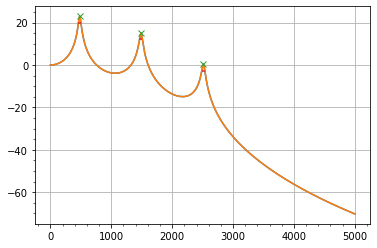

In [224]:
alpha = 0.6
beta = 2.4

PEAK_DISTANCE = 100. # Hz
FWHM_POWER_DROP = 3. # dB

# Get a power spectrum at df resolution
key, x, y, power = sample_power_spectrum_dB(3, jaxkey())
power = np.array(power)
print(key)

# Apply low-pass
rho = scipy.stats.beta(alpha, beta).rvs()
print("rho =", rho, "=> Dampen ripples on spectrum with period smaller than =", 1/(rho * (Fs / 2)), "Hz")

sos = scipy.signal.butter(6, rho, 'lowpass', analog=False, output='sos')
smoothed = scipy.signal.sosfiltfilt(sos, power)

# Find peaks
h = scipy.stats.expon(1.).rvs()
print("Peak prominence: h =", h, "dB")

peaks, _ = scipy.signal.find_peaks(smoothed, distance=max(PEAK_DISTANCE // df, 1.), prominence=h)

_, left_bases, right_bases = scipy.signal.peak_prominences(smoothed, peaks)
prominences = np.repeat(FWHM_POWER_DROP, len(peaks))
prominence_data = (prominences, left_bases, right_bases)

bandwidths, width_heights, left_lps, right_lps = scipy.signal.peak_widths(smoothed, peaks, rel_height=1, prominence_data=prominence_data)

formant_center = f[peaks]

print("F =", x)
print("F^ =", formant_center)
print("B =", y)
print("B^ =", bandwidths)

plot(f, power)
plot(f, smoothed)
plot(formant_center, smoothed[peaks], "x")
plt.hlines(width_heights, interp(left_lps, arange(len(f)), f), interp(right_lps, arange(len(f)), f), color="C3")

plt.grid("on")
plt.minorticks_on()

#xlim(0, x[-1]*1.1);
#ylim(-20, None);

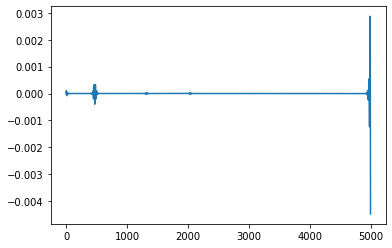

In [71]:
plot(smoothed - power)

## More realistic example from `paretochain`

A sample from the power spectrum of jmk/arctic_a0067.

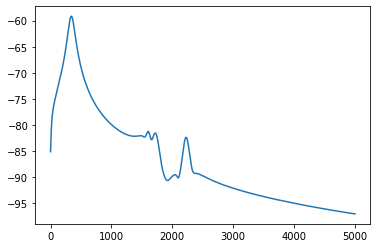

In [118]:
f = np.array([0.0, 1.0000160002560041, 2.0000320005120082, 3.000048000768013, 4.0000640010240165, 5.000080001280021, 6.000096001536026, 7.0001120017920275, 8.000128002048033, 9.000144002304038, 10.000160002560042, 11.000176002816046, 12.000192003072051, 13.000208003328055, 14.000224003584055, 15.000240003840062, 16.000256004096066, 17.00027200435207, 18.000288004608077, 19.00030400486408, 20.000320005120084, 21.000336005376088, 22.00035200563209, 23.000368005888095, 24.000384006144103, 25.0004000064001, 26.00041600665611, 27.000432006912114, 28.00044800716811, 29.00046400742412, 30.000480007680125, 31.00049600793613, 32.00051200819213, 33.00052800844814, 34.00054400870414, 35.00056000896015, 36.000576009216154, 37.00059200947215, 38.00060800972816, 39.000624009984165, 40.00064001024017, 41.00065601049617, 42.000672010752176, 43.00068801100818, 44.00070401126418, 45.00072001152019, 46.00073601177619, 47.000752012032194, 48.000768012288205, 49.0007840125442, 50.0008000128002, 51.00081601305621, 52.00083201331222, 53.000848013568216, 54.00086401382423, 55.00088001408024, 56.00089601433622, 57.00091201459223, 58.00092801484824, 59.00094401510425, 60.00096001536025, 61.00097601561626, 62.00099201587226, 63.00100801612827, 64.00102401638426, 65.00104001664027, 66.00105601689629, 67.00107201715227, 68.00108801740828, 69.00110401766429, 70.0011200179203, 71.0011360181763, 72.00115201843231, 73.0011680186883, 74.0011840189443, 75.00120001920031, 76.00121601945632, 77.00123201971232, 78.00124801996833, 79.00126402022433, 80.00128002048034, 81.00129602073633, 82.00131202099234, 83.00132802124834, 84.00134402150435, 85.00136002176035, 86.00137602201636, 87.00139202227236, 88.00140802252837, 89.00142402278436, 90.00144002304037, 91.00145602329637, 92.00147202355238, 93.00148802380838, 94.00150402406439, 95.00152002432039, 96.00153602457641, 97.0015520248324, 98.0015680250884, 99.0015840253444, 100.0016000256004, 101.00161602585642, 102.00163202611242, 103.00164802636841, 104.00166402662444, 105.00168002688044, 106.00169602713643, 107.00171202739246, 108.00172802764845, 109.00174402790445, 110.00176002816048, 111.00177602841644, 112.00179202867244, 113.00180802892847, 114.00182402918446, 115.00184002944049, 116.00185602969648, 117.00187202995248, 118.0018880302085, 119.0019040304645, 120.0019200307205, 121.00193603097651, 122.00195203123252, 123.00196803148849, 124.00198403174451, 125.00200003200051, 126.00201603225653, 127.00203203251253, 128.00204803276853, 129.00206403302454, 130.00208003328055, 131.00209603353653, 132.00211203379257, 133.00212803404855, 134.00214403430454, 135.00216003456055, 136.00217603481656, 137.00219203507257, 138.00220803532858, 139.00222403558456, 140.0022400358406, 141.00225603609658, 142.0022720363526, 143.0022880366086, 144.00230403686462, 145.0023200371206, 146.0023360373766, 147.0023520376326, 148.0023680378886, 149.0023840381446, 150.00240003840062, 151.00241603865663, 152.00243203891264, 153.00244803916863, 154.00246403942464, 155.00248003968065, 156.00249603993666, 157.00251204019267, 158.00252804044865, 159.00254404070463, 160.00256004096067, 161.00257604121666, 162.00259204147267, 163.00260804172868, 164.0026240419847, 165.0026400422407, 166.00265604249668, 167.0026720427527, 168.0026880430087, 169.00270404326469, 170.0027200435207, 171.0027360437767, 172.00275204403272, 173.00276804428873, 174.0027840445447, 175.00280004480072, 176.00281604505673, 177.00283204531274, 178.00284804556873, 179.00286404582477, 180.00288004608075, 181.00289604633673, 182.00291204659274, 183.00292804684875, 184.00294404710476, 185.00296004736077, 186.00297604761676, 187.0029920478728, 188.00300804812878, 189.0030240483848, 190.00304004864077, 191.0030560488968, 192.00307204915282, 193.00308804940883, 194.0031040496648, 195.00312004992082, 196.0031360501768, 197.00315205043285, 198.0031680506888, 199.0031840509448, 200.0032000512008, 201.0032160514568, 202.00323205171284, 203.00324805196885, 204.00326405222484, 205.00328005248085, 206.00329605273683, 207.00331205299284, 208.00332805324888, 209.0033440535049, 210.00336005376087, 211.00337605401688, 212.00339205427287, 213.00340805452888, 214.00342405478492, 215.0034400550409, 216.0034560552969, 217.0034720555529, 218.0034880558089, 219.00350405606494, 220.00352005632095, 221.00353605657693, 222.0035520568329, 223.0035680570889, 224.00358405734488, 225.00360005760092, 226.00361605785693, 227.00363205811294, 228.00364805836892, 229.00366405862493, 230.00368005888097, 231.00369605913696, 232.00371205939297, 233.00372805964895, 234.00374405990496, 235.00376006016097, 236.003776060417, 237.003792060673, 238.003808060929, 239.003824061185, 240.003840061441, 241.00385606169704, 242.00387206195302, 243.00388806220903, 244.00390406246504, 245.003920062721, 246.00393606297698, 247.00395206323302, 248.00396806348903, 249.003984063745, 250.00400006400102, 251.00401606425703, 252.00403206451307, 253.00404806476905, 254.00406406502506, 255.00408006528104, 256.00409606553706, 257.00411206579304, 258.0041280660491, 259.00414406630506, 260.0041600665611, 261.0041760668171, 262.00419206707306, 263.0042080673291, 264.00422406758514, 265.0042400678411, 266.0042560680971, 267.0042720683531, 268.00428806860907, 269.0043040688651, 270.0043200691211, 271.00433606937713, 272.0043520696331, 273.0043680698891, 274.00438407014514, 275.0044000704011, 276.00441607065716, 277.00443207091314, 278.0044480711691, 279.00446407142516, 280.0044800716812, 281.0044960719372, 282.00451207219317, 283.00452807244915, 284.0045440727052, 285.00456007296117, 286.0045760732172, 287.0045920734732, 288.00460807372923, 289.0046240739852, 290.0046400742412, 291.0046560744972, 292.0046720747532, 293.0046880750092, 294.0047040752652, 295.0047200755212, 296.0047360757772, 297.00475207603324, 298.0047680762892, 299.0047840765452, 300.00480007680125, 301.0048160770572, 302.00483207731327, 303.00484807756925, 304.0048640778253, 305.00488007808127, 306.00489607833725, 307.00491207859324, 308.0049280788493, 309.0049440791053, 310.0049600793613, 311.0049760796173, 312.0049920798733, 313.00500808012936, 314.00502408038534, 315.00504008064127, 316.0050560808973, 317.0050720811533, 318.00508808140927, 319.0051040816653, 320.00512008192135, 321.00513608217733, 322.0051520824333, 323.0051680826893, 324.00518408294533, 325.0052000832014, 326.00521608345736, 327.00523208371334, 328.0052480839694, 329.00526408422536, 330.0052800844814, 331.0052960847374, 332.00531208499336, 333.0053280852494, 334.0053440855054, 335.0053600857614, 336.0053760860174, 337.00539208627345, 338.00540808652937, 339.00542408678535, 340.0054400870414, 341.00545608729743, 342.0054720875534, 343.0054880878094, 344.00550408806544, 345.0055200883214, 346.00553608857746, 347.00555208883344, 348.0055680890894, 349.00558408934546, 350.00560008960144, 351.0056160898574, 352.00563209011347, 353.0056480903695, 354.0056640906255, 355.00568009088147, 356.00569609113745, 357.0057120913935, 358.00572809164953, 359.0057440919055, 360.0057600921615, 361.0057760924175, 362.00579209267346, 363.0058080929295, 364.0058240931855, 365.0058400934415, 366.0058560936975, 367.0058720939535, 368.0058880942095, 369.00590409446556, 370.00592009472155, 371.0059360949776, 372.0059520952335, 373.0059680954895, 374.0059840957456, 375.0060000960015, 376.00601609625755, 377.00603209651354, 378.0060480967696, 379.00606409702556, 380.00608009728154, 381.0060960975376, 382.0061120977936, 383.00612809804954, 384.00614409830564, 385.00616009856157, 386.00617609881766, 387.00619209907353, 388.0062080993296, 389.0062240995856, 390.00624009984165, 391.00625610009763, 392.0062721003536, 393.00628810060965, 394.0063041008657, 395.0063201011216, 396.0063361013776, 397.00635210163364, 398.0063681018896, 399.0063841021457, 400.0064001024016, 401.0064161026577, 402.0064321029136, 403.0064481031697, 404.0064641034257, 405.00648010368167, 406.0064961039377, 407.0065121041937, 408.00652810444967, 409.00654410470565, 410.0065601049617, 411.0065761052178, 412.00659210547366, 413.00660810572975, 414.0066241059857, 415.0066401062418, 416.00665610649776, 417.00667210675374, 418.0066881070098, 419.00670410726565, 420.00672010752174, 421.0067361077777, 422.00675210803377, 423.00676810828975, 424.00678410854573, 425.0068001088017, 426.00681610905775, 427.00683210931373, 428.00684810956983, 429.00686410982576, 430.0068801100818, 431.0068961103377, 432.0069121105938, 433.0069281108498, 434.0069441111058, 435.0069601113618, 436.0069761116178, 437.0069921118738, 438.0070081121299, 439.0070241123858, 440.0070401126419, 441.00705611289777, 442.00707211315387, 443.00708811340985, 444.0071041136658, 445.00712011392187, 446.0071361141778, 447.0071521144339, 448.00716811468976, 449.00718411494586, 450.00720011520184, 451.0072161154579, 452.00723211571386, 453.00724811596984, 454.0072641162259, 455.0072801164819, 456.00729611673785, 457.00731211699394, 458.00732811724987, 459.0073441175059, 460.00736011776195, 461.00737611801793, 462.0073921182739, 463.00740811852995, 464.00742411878593, 465.00744011904203, 466.0074561192979, 467.00747211955394, 468.0074881198099, 469.0075041200659, 470.00752012032194, 471.0075361205779, 472.007552120834, 473.0075681210899, 474.007584121346, 475.0076001216019, 476.007616121858, 477.007632122114, 478.00764812237, 479.007664122626, 480.007680122882, 481.007696123138, 482.00771212339407, 483.00772812365, 484.00774412390604, 485.00776012416196, 486.00777612441806, 487.007792124674, 488.0078081249301, 489.00782412518606, 490.007840125442, 491.007856125698, 492.00787212595395, 493.00788812621005, 494.00790412646603, 495.00792012672207, 496.00793612697805, 497.00795212723403, 498.00796812749, 499.0079841277461, 500.00800012800204, 501.00801612825813, 502.00803212851406, 503.0080481287701, 504.00806412902614, 505.0080801292821, 506.0080961295381, 507.0081121297941, 508.0081281300501, 509.0081441303061, 510.0081601305621, 511.0081761308182, 512.0081921310741, 513.0082081313301, 514.0082241315861, 515.0082401318421, 516.0082561320982, 517.0082721323541, 518.0082881326101, 519.0083041328661, 520.0083201331222, 521.0083361333782, 522.0083521336342, 523.0083681338901, 524.0083841341461, 525.0084001344021, 526.0084161346582, 527.0084321349142, 528.0084481351703, 529.0084641354262, 530.0084801356822, 531.0084961359381, 532.0085121361942, 533.0085281364502, 534.0085441367062, 535.0085601369623, 536.0085761372181, 537.0085921374742, 538.0086081377302, 539.0086241379862, 540.0086401382422, 541.0086561384982, 542.0086721387543, 543.0086881390102, 544.0087041392662, 545.0087201395223, 546.0087361397782, 547.0087521400343, 548.0087681402903, 549.0087841405463, 550.0088001408022, 551.0088161410583, 552.0088321413143, 553.0088481415703, 554.0088641418263, 555.0088801420824, 556.0088961423382, 557.0089121425943, 558.0089281428503, 559.0089441431063, 560.0089601433624, 561.0089761436183, 562.0089921438744, 563.0090081441302, 564.0090241443863, 565.0090401446423, 566.0090561448983, 567.0090721451544, 568.0090881454104, 569.0091041456664, 570.0091201459223, 571.0091361461783, 572.0091521464344, 573.0091681466903, 574.0091841469464, 575.0092001472024, 576.0092161474585, 577.0092321477144, 578.0092481479704, 579.0092641482264, 580.0092801484824, 581.0092961487384, 582.0093121489944, 583.0093281492505, 584.0093441495064, 585.0093601497624, 586.0093761500184, 587.0093921502745, 588.0094081505304, 589.0094241507865, 590.0094401510424, 591.0094561512984, 592.0094721515544, 593.0094881518105, 594.0095041520665, 595.0095201523225, 596.0095361525784, 597.0095521528344, 598.0095681530904, 599.0095841533465, 600.0096001536025, 601.0096161538586, 602.0096321541145, 603.0096481543706, 604.0096641546265, 605.0096801548825, 606.0096961551385, 607.0097121553945, 608.0097281556506, 609.0097441559066, 610.0097601561625, 611.0097761564185, 612.0097921566745, 613.0098081569305, 614.0098241571865, 615.0098401574426, 616.0098561576986, 617.0098721579545, 618.0098881582106, 619.0099041584665, 620.0099201587226, 621.0099361589786, 622.0099521592346, 623.0099681594905, 624.0099841597466, 625.0100001600026, 626.0100161602587, 627.0100321605146, 628.0100481607707, 629.0100641610265, 630.0100801612825, 631.0100961615386, 632.0101121617946, 633.0101281620507, 634.0101441623066, 635.0101601625627, 636.0101761628185, 637.0101921630746, 638.0102081633306, 639.0102241635866, 640.0102401638427, 641.0102561640987, 642.0102721643547, 643.0102881646108, 644.0103041648666, 645.0103201651227, 646.0103361653786, 647.0103521656347, 648.0103681658907, 649.0103841661468, 650.0104001664027, 651.0104161666587, 652.0104321669147, 653.0104481671707, 654.0104641674267, 655.0104801676827, 656.0104961679388, 657.0105121681947, 658.0105281684507, 659.0105441687067, 660.0105601689628, 661.0105761692187, 662.0105921694748, 663.0106081697307, 664.0106241699867, 665.0106401702428, 666.0106561704988, 667.0106721707548, 668.0106881710108, 669.0107041712668, 670.0107201715228, 671.0107361717787, 672.0107521720348, 673.0107681722908, 674.0107841725469, 675.0108001728028, 676.0108161730587, 677.0108321733148, 678.0108481735707, 679.0108641738268, 680.0108801740828, 681.0108961743389, 682.0109121745949, 683.0109281748508, 684.0109441751068, 685.0109601753628, 686.0109761756188, 687.0109921758749, 688.0110081761309, 689.0110241763869, 690.0110401766428, 691.0110561768989, 692.0110721771549, 693.0110881774109, 694.0111041776669, 695.0111201779229, 696.0111361781788, 697.0111521784349, 698.0111681786909, 699.0111841789469, 700.0112001792029, 701.0112161794589, 702.0112321797149, 703.0112481799708, 704.0112641802269, 705.0112801804829, 706.011296180739, 707.0113121809949, 708.011328181251, 709.011344181507, 710.0113601817629, 711.0113761820189, 712.0113921822749, 713.011408182531, 714.011424182787, 715.011440183043, 716.0114561832991, 717.0114721835549, 718.011488183811, 719.0115041840669, 720.011520184323, 721.011536184579, 722.011552184835, 723.011568185091, 724.0115841853469, 725.011600185603, 726.011616185859, 727.011632186115, 728.011648186371, 729.0116641866271, 730.011680186883, 731.0116961871391, 732.011712187395, 733.0117281876511, 734.011744187907, 735.0117601881631, 736.011776188419, 737.011792188675, 738.0118081889311, 739.0118241891871, 740.0118401894431, 741.0118561896991, 742.0118721899552, 743.011888190211, 744.011904190467, 745.0119201907231, 746.011936190979, 747.0119521912351, 748.0119681914912, 749.0119841917472, 750.012000192003, 751.012016192259, 752.0120321925151, 753.0120481927712, 754.0120641930271, 755.0120801932832, 756.0120961935392, 757.0121121937952, 758.0121281940511, 759.0121441943071, 760.0121601945631, 761.0121761948192, 762.0121921950752, 763.0122081953313, 764.0122241955872, 765.0122401958432, 766.0122561960991, 767.0122721963552, 768.0122881966113, 769.0123041968671, 770.0123201971231, 771.0123361973792, 772.0123521976353, 773.0123681978912, 774.0123841981471, 775.0124001984032, 776.0124161986593, 777.0124321989152, 778.0124481991712, 779.0124641994272, 780.0124801996833, 781.0124961999392, 782.0125122001953, 783.0125282004514, 784.0125442007072, 785.0125602009632, 786.0125762012193, 787.0125922014753, 788.0126082017314, 789.0126242019871, 790.0126402022432, 791.0126562024993, 792.0126722027552, 793.0126882030113, 794.0127042032673, 795.0127202035234, 796.0127362037792, 797.0127522040353, 798.0127682042914, 799.0127842045473, 800.0128002048032, 801.0128162050593, 802.0128322053154, 803.0128482055715, 804.0128642058272, 805.0128802060833, 806.0128962063394, 807.0129122065955, 808.0129282068514, 809.0129442071072, 810.0129602073633, 811.0129762076194, 812.0129922078754, 813.0130082081313, 814.0130242083874, 815.0130402086432, 816.0130562088993, 817.0130722091554, 818.0130882094113, 819.0131042096673, 820.0131202099234, 821.0131362101795, 822.0131522104356, 823.0131682106912, 824.0131842109473, 825.0132002112034, 826.0132162114595, 827.0132322117154, 828.0132482119714, 829.0132642122275, 830.0132802124836, 831.0132962127394, 832.0133122129955, 833.0133282132514, 834.0133442135075, 835.0133602137635, 836.0133762140196, 837.0133922142755, 838.0134082145313, 839.0134242147874, 840.0134402150435, 841.0134562152996, 842.0134722155555, 843.0134882158114, 844.0135042160675, 845.0135202163236, 846.0135362165795, 847.0135522168356, 848.0135682170915, 849.0135842173476, 850.0136002176034, 851.0136162178595, 852.0136322181155, 853.0136482183716, 854.0136642186275, 855.0136802188836, 856.0136962191397, 857.0137122193955, 858.0137282196515, 859.0137442199075, 860.0137602201636, 861.0137762204197, 862.0137922206754, 863.0138082209315, 864.0138242211876, 865.0138402214435, 866.0138562216996, 867.0138722219556, 868.0138882222116, 869.0139042224675, 870.0139202227236, 871.0139362229797, 872.0139522232356, 873.0139682234915, 874.0139842237476, 875.0140002240037, 876.0140162242598, 877.0140322245155, 878.0140482247716, 879.0140642250277, 880.0140802252838, 881.0140962255397, 882.0141122257955, 883.0141282260516, 884.0141442263077, 885.0141602265637, 886.0141762268197, 887.0141922270757, 888.0142082273316, 889.0142242275876, 890.0142402278437, 891.0142562280996, 892.0142722283556, 893.0142882286117, 894.0143042288678, 895.0143202291239, 896.0143362293795, 897.0143522296356, 898.0143682298917, 899.0143842301478, 900.0144002304037, 901.0144162306597, 902.0144322309158, 903.0144482311719, 904.0144642314277, 905.0144802316838, 906.0144962319397, 907.0145122321958, 908.0145282324518, 909.0145442327077, 910.0145602329638, 911.0145762332196, 912.0145922334757, 913.0146082337318, 914.0146242339879, 915.0146402342438, 916.0146562344997, 917.0146722347558, 918.0146882350118, 919.0147042352678, 920.0147202355239, 921.0147362357798, 922.0147522360359, 923.0147682362917, 924.0147842365478, 925.0148002368039, 926.0148162370599, 927.0148322373158, 928.0148482375719, 929.014864237828, 930.0148802380841, 931.0148962383398, 932.0149122385958, 933.0149282388519, 934.0149442391079, 935.0149602393637, 936.0149762396198, 937.0149922398759, 938.0150082401318, 939.0150242403879, 940.0150402406439, 941.0150562408999, 942.0150722411558, 943.015088241412, 944.015104241668, 945.0151202419239, 946.0151362421798, 947.0151522424359, 948.015168242692, 949.0151842429481, 950.0152002432038, 951.0152162434599, 952.015232243716, 953.0152482439721, 954.015264244228, 955.0152802444838, 956.01529624474, 957.0153122449959, 958.015328245252, 959.015344245508, 960.015360245764, 961.0153762460199, 962.015392246276, 963.015408246532, 964.0154242467881, 965.0154402470439, 966.0154562473, 967.0154722475561, 968.0154882478121, 969.015504248068, 970.0155202483239, 971.01553624858, 972.0155522488361, 973.015568249092, 974.015584249348, 975.0156002496041, 976.0156162498602, 977.015632250116, 978.0156482503721, 979.015664250628, 980.015680250884, 981.0156962511401, 982.015712251396, 983.0157282516521, 984.0157442519079, 985.015760252164, 986.0157762524201, 987.0157922526762, 988.0158082529321, 989.015824253188, 990.0158402534441, 991.0158562537001, 992.0158722539561, 993.0158882542122, 994.0159042544681, 995.0159202547242, 996.01593625498, 997.0159522552361, 998.0159682554922, 999.0159842557482, 1000.0160002560041, 1001.0160162562602, 1002.0160322565163, 1003.0160482567721, 1004.0160642570281, 1005.0160802572841, 1006.0160962575402, 1007.0161122577962, 1008.0161282580523, 1009.0161442583081, 1010.0161602585642, 1011.0161762588201, 1012.0161922590762, 1013.0162082593323, 1014.0162242595882, 1015.0162402598442, 1016.0162562601002, 1017.0162722603563, 1018.0162882606122, 1019.0163042608681, 1020.0163202611242, 1021.0163362613803, 1022.0163522616364, 1023.0163682618921, 1024.0163842621482, 1025.0164002624042, 1026.0164162626602, 1027.0164322629162, 1028.0164482631722, 1029.0164642634284, 1030.0164802636841, 1031.0164962639403, 1032.0165122641963, 1033.0165282644523, 1034.0165442647083, 1035.0165602649643, 1036.0165762652202, 1037.0165922654764, 1038.0166082657322, 1039.0166242659882, 1040.0166402662444, 1041.0166562665004, 1042.0166722667564, 1043.0166882670123, 1044.0167042672683, 1045.0167202675245, 1046.0167362677803, 1047.0167522680365, 1048.0167682682923, 1049.0167842685482, 1050.0168002688042, 1051.0168162690604, 1052.0168322693164, 1053.0168482695722, 1054.0168642698284, 1055.0168802700844, 1056.0168962703406, 1057.0169122705963, 1058.0169282708523, 1059.0169442711083, 1060.0169602713645, 1061.0169762716205, 1062.0169922718762, 1063.0170082721324, 1064.0170242723884, 1065.0170402726444, 1066.0170562729004, 1067.0170722731564, 1068.0170882734124, 1069.0171042736683, 1070.0171202739245, 1071.0171362741805, 1072.0171522744363, 1073.0171682746923, 1074.0171842749485, 1075.0172002752045, 1076.0172162754604, 1077.0172322757164, 1078.0172482759724, 1079.0172642762286, 1080.0172802764844, 1081.0172962767406, 1082.0173122769963, 1083.0173282772525, 1084.0173442775085, 1085.0173602777645, 1086.0173762780205, 1087.0173922782765, 1088.0174082785325, 1089.0174242787884, 1090.0174402790446, 1091.0174562793006, 1092.0174722795564, 1093.0174882798126, 1094.0175042800686, 1095.0175202803246, 1096.0175362805805, 1097.0175522808365, 1098.0175682810925, 1099.0175842813485, 1100.0176002816045, 1101.0176162818605, 1102.0176322821167, 1103.0176482823724, 1104.0176642826286, 1105.0176802828846, 1106.0176962831406, 1107.0177122833966, 1108.0177282836526, 1109.0177442839085, 1110.0177602841648, 1111.0177762844205, 1112.0177922846765, 1113.0178082849327, 1114.0178242851887, 1115.0178402854447, 1116.0178562857006, 1117.0178722859566, 1118.0178882862126, 1119.0179042864686, 1120.0179202867248, 1121.0179362869806, 1122.0179522872365, 1123.0179682874925, 1124.0179842877487, 1125.0180002880047, 1126.0180162882605, 1127.0180322885167, 1128.0180482887727, 1129.0180642890289, 1130.0180802892846, 1131.0180962895406, 1132.0181122897966, 1133.0181282900528, 1134.0181442903088, 1135.0181602905648, 1136.0181762908207, 1137.0181922910767, 1138.0182082913327, 1139.0182242915887, 1140.0182402918447, 1141.0182562921007, 1142.0182722923566, 1143.0182882926129, 1144.0183042928688, 1145.0183202931246, 1146.0183362933806, 1147.0183522936368, 1148.0183682938928, 1149.0183842941487, 1150.0184002944047, 1151.0184162946607, 1152.018432294917, 1153.0184482951727, 1154.0184642954289, 1155.0184802956846, 1156.0184962959408, 1157.0185122961968, 1158.0185282964528, 1159.0185442967088, 1160.0185602969648, 1161.0185762972208, 1162.0185922974767, 1163.018608297733, 1164.0186242979887, 1165.0186402982447, 1166.018656298501, 1167.0186722987569, 1168.0186882990129, 1169.0187042992688, 1170.0187202995248, 1171.0187362997808, 1172.0187523000368, 1173.0187683002928, 1174.018784300549, 1175.018800300805, 1176.0188163010607, 1177.018832301317, 1178.018848301573, 1179.0188643018291, 1180.0188803020849, 1181.0188963023409, 1182.0189123025968, 1183.018928302853, 1184.0189443031088, 1185.0189603033648, 1186.018976303621, 1187.0189923038768, 1188.019008304133, 1189.019024304389, 1190.019040304645, 1191.019056304901, 1192.019072305157, 1193.019088305413, 1194.0191043056689, 1195.0191203059248, 1196.0191363061808, 1197.019152306437, 1198.019168306693, 1199.0191843069488, 1200.019200307205, 1201.019216307461, 1202.0192323077172, 1203.019248307973, 1204.019264308229, 1205.019280308485, 1206.019296308741, 1207.019312308997, 1208.019328309253, 1209.019344309509, 1210.019360309765, 1211.019376310021, 1212.019392310277, 1213.0194083105332, 1214.019424310789, 1215.019440311045, 1216.0194563113012, 1217.0194723115571, 1218.0194883118131, 1219.0195043120689, 1220.019520312325, 1221.019536312581, 1222.019552312837, 1223.019568313093, 1224.019584313349, 1225.0196003136052, 1226.019616313861, 1227.0196323141172, 1228.019648314373, 1229.0196643146292, 1230.0196803148851, 1231.0196963151411, 1232.019712315397, 1233.019728315653, 1234.019744315909, 1235.019760316165, 1236.0197763164213, 1237.019792316677, 1238.019808316933, 1239.0198243171892, 1240.0198403174452, 1241.0198563177012, 1242.0198723179572, 1243.0198883182131, 1244.0199043184691, 1245.019920318725, 1246.019936318981, 1247.0199523192373, 1248.0199683194933, 1249.019984319749, 1250.0200003200052, 1251.0200163202612, 1252.0200323205174, 1253.0200483207732, 1254.0200643210292, 1255.0200803212851, 1256.0200963215414, 1257.0201123217973, 1258.020128322053, 1259.0201443223093, 1260.020160322565, 1261.0201763228213, 1262.0201923230773, 1263.0202083233332, 1264.0202243235892, 1265.0202403238452, 1266.0202563241014, 1267.0202723243572, 1268.0202883246131, 1269.0203043248691, 1270.0203203251253, 1271.0203363253813, 1272.020352325637, 1273.0203683258933, 1274.0203843261493, 1275.0204003264055, 1276.0204163266612, 1277.0204323269172, 1278.0204483271732, 1279.0204643274294, 1280.0204803276854, 1281.0204963279414, 1282.0205123281974, 1283.020528328453, 1284.0205443287093, 1285.0205603289653, 1286.0205763292215, 1287.0205923294773, 1288.0206083297332, 1289.0206243299895, 1290.0206403302454, 1291.0206563305014, 1292.0206723307572, 1293.0206883310134, 1294.0207043312694, 1295.0207203315254, 1296.0207363317813, 1297.0207523320373, 1298.0207683322935, 1299.0207843325493, 1300.0208003328055, 1301.0208163330615, 1302.0208323333175, 1303.0208483335734, 1304.0208643338294, 1305.0208803340854, 1306.0208963343414, 1307.0209123345974, 1308.0209283348534, 1309.0209443351096, 1310.0209603353653, 1311.0209763356213, 1312.0209923358775, 1313.0210083361335, 1314.0210243363895, 1315.0210403366455, 1316.0210563369014, 1317.0210723371574, 1318.0210883374134, 1319.0211043376694, 1320.0211203379256, 1321.0211363381816, 1322.0211523384373, 1323.0211683386935, 1324.0211843389495, 1325.0212003392057, 1326.0212163394615, 1327.0212323397175, 1328.0212483399735, 1329.0212643402294, 1330.0212803404856, 1331.0212963407414, 1332.0213123409976, 1333.0213283412534, 1334.0213443415096, 1335.0213603417656, 1336.0213763420215, 1337.0213923422775, 1338.0214083425335, 1339.0214243427897, 1340.0214403430457, 1341.0214563433015, 1342.0214723435574, 1343.0214883438136, 1344.0215043440696, 1345.0215203443256, 1346.0215363445816, 1347.0215523448376, 1348.0215683450938, 1349.0215843453495, 1350.0216003456055, 1351.0216163458615, 1352.0216323461175, 1353.0216483463737, 1354.0216643466297, 1355.0216803468857, 1356.0216963471414, 1357.0217123473976, 1358.0217283476536, 1359.0217443479098, 1360.0217603481656, 1361.0217763484216, 1362.0217923486778, 1363.0218083489337, 1364.0218243491897, 1365.0218403494455, 1366.0218563497017, 1367.0218723499577, 1368.0218883502137, 1369.0219043504696, 1370.0219203507256, 1371.0219363509818, 1372.0219523512376, 1373.0219683514938, 1374.0219843517498, 1375.0220003520055, 1376.0220163522617, 1377.0220323525177, 1378.0220483527737, 1379.0220643530297, 1380.0220803532857, 1381.0220963535417, 1382.0221123537979, 1383.0221283540536, 1384.0221443543098, 1385.0221603545658, 1386.0221763548218, 1387.0221923550778, 1388.0222083553338, 1389.0222243555897, 1390.0222403558457, 1391.0222563561017, 1392.0222723563577, 1393.022288356614, 1394.0223043568699, 1395.0223203571256, 1396.0223363573818, 1397.0223523576378, 1398.0223683578938, 1399.0223843581498, 1400.0224003584058, 1401.0224163586618, 1402.0224323589177, 1403.022448359174, 1404.0224643594297, 1405.022480359686, 1406.0224963599417, 1407.0225123601979, 1408.0225283604539, 1409.0225443607098, 1410.0225603609658, 1411.0225763612218, 1412.022592361478, 1413.022608361734, 1414.0226243619898, 1415.0226403622457, 1416.022656362502, 1417.022672362758, 1418.022688363014, 1419.02270436327, 1420.0227203635259, 1421.0227363637819, 1422.0227523640378, 1423.022768364294, 1424.0227843645498, 1425.0228003648058, 1426.022816365062, 1427.022832365318, 1428.022848365574, 1429.0228643658297, 1430.022880366086, 1431.022896366342, 1432.0229123665981, 1433.0229283668539, 1434.0229443671099, 1435.022960367366, 1436.022976367622, 1437.022992367878, 1438.0230083681338, 1439.02302436839, 1440.023040368646, 1441.023056368902, 1442.023072369158, 1443.023088369414, 1444.02310436967, 1445.023120369926, 1446.023136370182, 1447.023152370438, 1448.0231683706938, 1449.02318437095, 1450.023200371206, 1451.023216371462, 1452.023232371718, 1453.023248371974, 1454.02326437223, 1455.0232803724862, 1456.023296372742, 1457.0233123729981, 1458.0233283732541, 1459.02334437351, 1460.023360373766, 1461.023376374022, 1462.0233923742783, 1463.023408374534, 1464.02342437479, 1465.023440375046, 1466.0234563753022, 1467.0234723755582, 1468.023488375814, 1469.0235043760702, 1470.0235203763261, 1471.0235363765821, 1472.023552376838, 1473.023568377094, 1474.02358437735, 1475.023600377606, 1476.0236163778623, 1477.023632378118, 1478.0236483783742, 1479.02366437863, 1480.0236803788862, 1481.0236963791422, 1482.0237123793981, 1483.0237283796541, 1484.0237443799103, 1485.0237603801663, 1486.023776380422, 1487.0237923806783, 1488.023808380934, 1489.02382438119, 1490.0238403814462, 1491.0238563817022, 1492.023872381958, 1493.0238883822142, 1494.0239043824702, 1495.0239203827264, 1496.0239363829824, 1497.023952383238, 1498.0239683834943, 1499.0239843837503, 1500.024000384006, 1501.0240163842623, 1502.024032384518, 1503.0240483847745, 1504.0240643850302, 1505.0240803852862, 1506.0240963855424, 1507.0241123857982, 1508.0241283860541, 1509.0241443863104, 1510.0241603865663, 1511.0241763868223, 1512.0241923870783, 1513.0242083873343, 1514.0242243875905, 1515.0242403878462, 1516.0242563881022, 1517.0242723883584, 1518.0242883886142, 1519.0243043888702, 1520.0243203891262, 1521.0243363893824, 1522.0243523896384, 1523.0243683898946, 1524.0243843901503, 1525.0244003904063, 1526.0244163906625, 1527.024432390918, 1528.0244483911745, 1529.0244643914302, 1530.0244803916864, 1531.0244963919424, 1532.0245123921982, 1533.0245283924544, 1534.0245443927104, 1535.0245603929661, 1536.0245763932226, 1537.0245923934783, 1538.0246083937343, 1539.0246243939905, 1540.0246403942463, 1541.0246563945027, 1542.0246723947585, 1543.0246883950142, 1544.0247043952706, 1545.0247203955264, 1546.0247363957824, 1547.0247523960384, 1548.0247683962941, 1549.0247843965506, 1550.0248003968063, 1551.0248163970625, 1552.0248323973185, 1553.0248483975743, 1554.0248643978305, 1555.0248803980865, 1556.0248963983424, 1557.0249123985986, 1558.0249283988544, 1559.0249443991104, 1560.0249603993666, 1561.0249763996226, 1562.0249923998783, 1563.0250084001345, 1564.0250244003905, 1565.0250404006463, 1566.0250564009027, 1567.0250724011585, 1568.0250884014145, 1569.0251044016707, 1570.0251204019264, 1571.0251364021829, 1572.0251524024386, 1573.0251684026941, 1574.0251844029506, 1575.0252004032063, 1576.0252164034628, 1577.0252324037185, 1578.0252484039743, 1579.0252644042307, 1580.0252804044865, 1581.0252964047427, 1582.0253124049987, 1583.0253284052544, 1584.0253444055104, 1585.0253604057666, 1586.0253764060226, 1587.0253924062788, 1588.0254084065346, 1589.0254244067905, 1590.0254404070467, 1591.0254564073027, 1592.0254724075585, 1593.0254884078145, 1594.0255044080707, 1595.0255204083267, 1596.0255364085829, 1597.0255524088386, 1598.0255684090946, 1599.0255844093508, 1600.0256004096063, 1601.0256164098628, 1602.0256324101185, 1603.0256484103747, 1604.0256644106307, 1605.0256804108865, 1606.025696411143, 1607.0257124113987, 1608.0257284116544, 1609.0257444119109, 1610.0257604121666, 1611.0257764124226, 1612.0257924126788, 1613.0258084129346, 1614.025824413191, 1615.0258404134468, 1616.0258564137027, 1617.025872413959, 1618.0258884142145, 1619.0259044144707, 1620.0259204147267, 1621.0259364149824, 1622.0259524152389, 1623.0259684154946, 1624.0259844157508, 1625.0260004160068, 1626.0260164162626, 1627.0260324165185, 1628.0260484167748, 1629.0260644170307, 1630.0260804172865, 1631.0260964175427, 1632.0261124177987, 1633.026128418055, 1634.0261444183109, 1635.0261604185666, 1636.0261764188226, 1637.0261924190788, 1638.0262084193346, 1639.026224419591, 1640.0262404198468, 1641.0262564201028, 1642.026272420359, 1643.0262884206147, 1644.0263044208712, 1645.0263204211267, 1646.0263364213824, 1647.0263524216389, 1648.0263684218946, 1649.026384422151, 1650.0264004224068, 1651.0264164226626, 1652.026432422919, 1653.0264484231748, 1654.0264644234308, 1655.026480423687, 1656.0264964239427, 1657.0265124241987, 1658.026528424455, 1659.026544424711, 1660.026560424967, 1661.0265764252229, 1662.0265924254788, 1663.026608425735, 1664.026624425991, 1665.0266404262468, 1666.0266564265028, 1667.026672426759, 1668.026688427015, 1669.0267044272712, 1670.026720427527, 1671.026736427783, 1672.0267524280391, 1673.0267684282946, 1674.026784428551, 1675.0268004288068, 1676.0268164290626, 1677.026832429319, 1678.0268484295748, 1679.0268644298312, 1680.026880430087, 1681.0268964303427, 1682.0269124305992, 1683.026928430855, 1684.026944431111, 1685.0269604313671, 1686.0269764316229, 1687.0269924318793, 1688.027008432135, 1689.027024432391, 1690.0270404326473, 1691.0270564329028, 1692.027072433159, 1693.027088433415, 1694.0271044336712, 1695.0271204339272, 1696.027136434183, 1697.0271524344391, 1698.027168434695, 1699.0271844349509, 1700.0272004352069, 1701.027216435463, 1702.027232435719, 1703.0272484359748, 1704.027264436231, 1705.027280436487, 1706.0272964367432, 1707.0273124369992, 1708.027328437255, 1709.027344437511, 1710.0273604377671, 1711.0273764380229, 1712.0273924382793, 1713.027408438535, 1714.027424438791, 1715.0274404390473, 1716.027456439303, 1717.0274724395595, 1718.027488439815, 1719.0275044400707, 1720.0275204403272, 1721.027536440583, 1722.0275524408394, 1723.0275684410951, 1724.0275844413509, 1725.0276004416073, 1726.027616441863, 1727.027632442119, 1728.0276484423753, 1729.027664442631, 1730.027680442887, 1731.0276964431432, 1732.0277124433992, 1733.0277284436554, 1734.0277444439112, 1735.0277604441671, 1736.0277764444231, 1737.0277924446793, 1738.027808444935, 1739.027824445191, 1740.0278404454473, 1741.0278564457033, 1742.0278724459595, 1743.0278884462152, 1744.0279044464712, 1745.0279204467272, 1746.027936446983, 1747.0279524472394, 1748.0279684474951, 1749.027984447751, 1750.0280004480073, 1751.028016448263, 1752.0280324485195, 1753.0280484487753, 1754.028064449031, 1755.0280804492875, 1756.0280964495432, 1757.0281124497992, 1758.0281284500554, 1759.0281444503112, 1760.0281604505676, 1761.0281764508234, 1762.0281924510793, 1763.0282084513353, 1764.028224451591, 1765.0282404518473, 1766.0282564521033, 1767.0282724523595, 1768.0282884526155, 1769.0283044528712, 1770.0283204531274, 1771.0283364533834, 1772.0283524536394, 1773.0283684538952, 1774.0283844541514, 1775.0284004544073, 1776.028416454663, 1777.0284324549195, 1778.0284484551753, 1779.0284644554315, 1780.0284804556875, 1781.0284964559432, 1782.0285124561992, 1783.0285284564554, 1784.0285444567112, 1785.0285604569676, 1786.0285764572234, 1787.0285924574794, 1788.0286084577356, 1789.0286244579913, 1790.0286404582478, 1791.0286564585033, 1792.028672458759, 1793.0286884590155, 1794.0287044592712, 1795.0287204595274, 1796.0287364597834, 1797.0287524600392, 1798.0287684602956, 1799.0287844605514, 1800.0288004608074, 1801.0288164610636, 1802.0288324613193, 1803.0288484615753, 1804.0288644618315, 1805.0288804620875, 1806.0288964623437, 1807.0289124625995, 1808.0289284628554, 1809.0289444631114, 1810.0289604633676, 1811.0289764636234, 1812.0289924638794, 1813.0290084641356, 1814.0290244643916, 1815.0290404646478, 1816.0290564649035, 1817.0290724651595, 1818.0290884654155, 1819.0291044656713, 1820.0291204659277, 1821.0291364661834, 1822.0291524664392, 1823.0291684666956, 1824.0291844669514, 1825.0292004672078, 1826.0292164674636, 1827.0292324677193, 1828.0292484679758, 1829.0292644682315, 1830.0292804684875, 1831.0292964687437, 1832.0293124689995, 1833.029328469256, 1834.0293444695117, 1835.0293604697677, 1836.0293764700236, 1837.0293924702794, 1838.0294084705356, 1839.0294244707916, 1840.0294404710478, 1841.0294564713035, 1842.0294724715595, 1843.0294884718157, 1844.0295044720717, 1845.0295204723277, 1846.0295364725835, 1847.0295524728397, 1848.0295684730957, 1849.0295844733514, 1850.0296004736078, 1851.0296164738636, 1852.0296324741198, 1853.0296484743758, 1854.0296644746315, 1855.029680474888, 1856.0296964751437, 1857.0297124753995, 1858.029728475656, 1859.0297444759117, 1860.0297604761681, 1861.0297764764239, 1862.0297924766796, 1863.0298084769358, 1864.0298244771916, 1865.0298404774478, 1866.0298564777038, 1867.0298724779595, 1868.0298884782158, 1869.0299044784717, 1870.0299204787275, 1871.029936478984, 1872.0299524792397, 1873.0299684794957, 1874.0299844797519, 1875.0300004800076, 1876.0300164802636, 1877.0300324805198, 1878.0300484807758, 1879.030064481032, 1880.0300804812878, 1881.0300964815438, 1882.0301124817997, 1883.030128482056, 1884.0301444823117, 1885.0301604825677, 1886.030176482824, 1887.0301924830796, 1888.030208483336, 1889.0302244835918, 1890.0302404838478, 1891.0302564841038, 1892.0302724843596, 1893.030288484616, 1894.0303044848717, 1895.0303204851275, 1896.030336485384, 1897.0303524856397, 1898.0303684858961, 1899.030384486152, 1900.0304004864076, 1901.030416486664, 1902.0304324869198, 1903.0304484871758, 1904.030464487432, 1905.0304804876878, 1906.0304964879442, 1907.0305124882, 1908.030528488456, 1909.030544488712, 1910.0305604889677, 1911.030576489224, 1912.03059248948, 1913.030608489736, 1914.0306244899919, 1915.0306404902478, 1916.030656490504, 1917.03067249076, 1918.030688491016, 1919.0307044912718, 1920.030720491528, 1921.030736491784, 1922.0307524920397, 1923.0307684922961, 1924.030784492552, 1925.030800492808, 1926.030816493064, 1927.0308324933198, 1928.0308484935763, 1929.030864493832, 1930.0308804940878, 1931.0308964943442, 1932.0309124946, 1933.030928494856, 1934.0309444951122, 1935.030960495368, 1936.0309764956241, 1937.03099249588, 1938.031008496136, 1939.031024496392, 1940.0310404966478, 1941.031056496904, 1942.03107249716, 1943.0310884974162, 1944.0311044976722, 1945.031120497928, 1946.031136498184, 1947.0311524984402, 1948.031168498696, 1949.031184498952, 1950.0312004992081, 1951.031216499464, 1952.0312324997203, 1953.031248499976, 1954.031264500232, 1955.031280500488, 1956.0312965007442, 1957.031312501, 1958.031328501256, 1959.0313445015122, 1960.031360501768, 1961.0313765020244, 1962.0313925022801, 1963.0314085025361, 1964.031424502792, 1965.0314405030479, 1966.0314565033043, 1967.03147250356, 1968.0314885038158, 1969.0315045040722, 1970.031520504328, 1971.0315365045844, 1972.0315525048402, 1973.031568505096, 1974.0315845053524, 1975.0316005056081, 1976.0316165058641, 1977.0316325061203, 1978.031648506376, 1979.031664506632, 1980.0316805068883, 1981.0316965071443, 1982.0317125074002, 1983.031728507656, 1984.0317445079122, 1985.0317605081682, 1986.0317765084244, 1987.0317925086802, 1988.0318085089361, 1989.0318245091923, 1990.0318405094483, 1991.0318565097043, 1992.03187250996, 1993.0318885102163, 1994.0319045104723, 1995.031920510728, 1996.0319365109845, 1997.0319525112402, 1998.0319685114964, 1999.0319845117524, 2000.0320005120082, 2001.0320165122646, 2002.0320325125203, 2003.032048512776, 2004.0320645130325, 2005.0320805132883, 2006.0320965135443, 2007.0321125138005, 2008.0321285140562, 2009.0321445143124, 2010.0321605145682, 2011.0321765148244, 2012.0321925150804, 2013.0322085153362, 2014.0322245155924, 2015.0322405158483, 2016.0322565161046, 2017.0322725163605, 2018.0322885166163, 2019.0323045168723, 2020.0323205171285, 2021.0323365173845, 2022.0323525176402, 2023.0323685178964, 2024.0323845181524, 2025.0324005184082, 2026.0324165186646, 2027.0324325189204, 2028.0324485191763, 2029.0324645194326, 2030.0324805196883, 2031.0324965199443, 2032.0325125202005, 2033.0325285204563, 2034.0325445207127, 2035.0325605209684, 2036.0325765212244, 2037.0325925214804, 2038.0326085217362, 2039.0326245219926, 2040.0326405222484, 2041.032656522504, 2042.0326725227605, 2043.0326885230163, 2044.0327045232727, 2045.0327205235285, 2046.0327365237843, 2047.0327525240407, 2048.0327685242964, 2049.0327845245524, 2050.0328005248084, 2051.0328165250644, 2052.0328325253204, 2053.0328485255764, 2054.0328645258323, 2055.032880526089, 2056.0328965263443, 2057.0329125266003, 2058.0329285268567, 2059.0329445271127, 2060.0329605273682, 2061.0329765276247, 2062.0329925278807, 2063.0330085281366, 2064.0330245283926, 2065.0330405286486, 2066.0330565289046, 2067.0330725291606, 2068.0330885294165, 2069.033104529673, 2070.0331205299285, 2071.0331365301845, 2072.0331525304405, 2073.0331685306965, 2074.033184530953, 2075.0332005312084, 2076.0332165314644, 2077.033232531721, 2078.0332485319764, 2079.033264532233, 2080.033280532489, 2081.0332965327443, 2082.0333125330008, 2083.0333285332567, 2084.0333445335127, 2085.0333605337687, 2086.0333765340247, 2087.0333925342807, 2088.0334085345366, 2089.0334245347926, 2090.033440535049, 2091.0334565353046, 2092.0334725355606, 2093.0334885358166, 2094.033504536073, 2095.0335205363285, 2096.0335365365845, 2097.033552536841, 2098.0335685370965, 2099.033584537353, 2100.0336005376084, 2101.033616537865, 2102.033632538121, 2103.0336485383764, 2104.033664538633, 2105.033680538889, 2106.0336965391443, 2107.0337125394008, 2108.0337285396567, 2109.033744539913, 2110.0337605401687, 2111.0337765404247, 2112.033792540681, 2113.0338085409367, 2114.0338245411926, 2115.033840541449, 2116.0338565417046, 2117.033872541961, 2118.0338885422166, 2119.0339045424726, 2120.033920542729, 2121.0339365429845, 2122.033952543241, 2123.033968543497, 2124.0339845437525, 2125.034000544009, 2126.034016544265, 2127.034032544521, 2128.034048544777, 2129.034064545033, 2130.034080545289, 2131.034096545545, 2132.034112545801, 2133.0341285460568, 2134.0341445463127, 2135.0341605465687, 2136.0341765468247, 2137.034192547081, 2138.0342085473367, 2139.0342245475927, 2140.034240547849, 2141.0342565481046, 2142.034272548361, 2143.034288548617, 2144.0343045488726, 2145.034320549129, 2146.0343365493845, 2147.034352549641, 2148.034368549897, 2149.0343845501525, 2150.034400550409, 2151.034416550665, 2152.034432550921, 2153.034448551177, 2154.034464551433, 2155.0344805516893, 2156.034496551945, 2157.034512552201, 2158.0345285524572, 2159.0345445527128, 2160.0345605529687, 2161.034576553225, 2162.034592553481, 2163.034608553737, 2164.0346245539927, 2165.034640554249, 2166.034656554505, 2167.034672554761, 2168.034688555017, 2169.034704555273, 2170.034720555529, 2171.034736555785, 2172.034752556041, 2173.034768556297, 2174.034784556553, 2175.034800556809, 2176.034816557065, 2177.0348325573214, 2178.034848557577, 2179.034864557833, 2180.0348805580893, 2181.034896558345, 2182.0349125586013, 2183.0349285588572, 2184.034944559113, 2185.034960559369, 2186.034976559625, 2187.034992559881, 2188.035008560137, 2189.035024560393, 2190.035040560649, 2191.035056560905, 2192.035072561161, 2193.035088561417, 2194.035104561673, 2195.035120561929, 2196.035136562185, 2197.035152562441, 2198.035168562697, 2199.035184562953, 2200.035200563209, 2201.0352165634654, 2202.035232563721, 2203.035248563977, 2204.0352645642333, 2205.0352805644893, 2206.035296564745, 2207.0353125650013, 2208.0353285652573, 2209.0353445655132, 2210.035360565769, 2211.035376566025, 2212.035392566281, 2213.035408566537, 2214.035424566793, 2215.0354405670496, 2216.035456567305, 2217.035472567561, 2218.035488567817, 2219.035504568073, 2220.0355205683295, 2221.035536568585, 2222.035552568841, 2223.0355685690974, 2224.035584569353, 2225.0356005696094, 2226.0356165698654, 2227.035632570121, 2228.0356485703774, 2229.0356645706333, 2230.0356805708893, 2231.0356965711453, 2232.0357125714013, 2233.0357285716573, 2234.0357445719133, 2235.0357605721692, 2236.035776572425, 2237.035792572681, 2238.035808572937, 2239.035824573193, 2240.0358405734496, 2241.035856573705, 2242.035872573961, 2243.0358885742176, 2244.035904574473, 2245.0359205747295, 2246.035936574985, 2247.0359525752415, 2248.0359685754975, 2249.035984575753, 2250.0360005760094, 2251.0360165762654, 2252.036032576521, 2253.0360485767774, 2254.0360645770334, 2255.03608057729, 2256.0360965775453, 2257.0361125778013, 2258.0361285780577, 2259.0361445783133, 2260.0361605785693, 2261.0361765788257, 2262.036192579081, 2263.036208579337, 2264.036224579593, 2265.0362405798496, 2266.0362565801056, 2267.036272580361, 2268.0362885806176, 2269.0363045808735, 2270.0363205811295, 2271.0363365813855, 2272.0363525816415, 2273.0363685818975, 2274.0363845821535, 2275.0364005824094, 2276.0364165826654, 2277.0364325829214, 2278.0364485831774, 2279.0364645834334, 2280.0364805836894, 2281.0364965839453, 2282.0365125842013, 2283.0365285844578, 2284.0365445847133, 2285.0365605849693, 2286.0365765852257, 2287.0365925854812, 2288.0366085857377, 2289.0366245859936, 2290.036640586249, 2291.0366565865056, 2292.036672586761, 2293.0366885870176, 2294.0367045872736, 2295.036720587529, 2296.0367365877855, 2297.0367525880415, 2298.0367685882975, 2299.0367845885535, 2300.0368005888095, 2301.036816589066, 2302.0368325893214, 2303.0368485895774, 2304.036864589834, 2305.0368805900894, 2306.0368965903453, 2307.036912590602, 2308.0369285908578, 2309.0369445911133, 2310.0369605913693, 2311.0369765916257, 2312.0369925918817, 2313.0370085921377, 2314.0370245923937, 2315.0370405926496, 2316.0370565929056, 2317.0370725931616, 2318.0370885934176, 2319.0371045936736, 2320.0371205939296, 2321.0371365941855, 2322.0371525944415, 2323.037168594698, 2324.0371845949535, 2325.0372005952095, 2326.037216595466, 2327.0372325957214, 2328.0372485959774, 2329.037264596234, 2330.0372805964894, 2331.037296596746, 2332.037312597002, 2333.037328597258, 2334.0373445975138, 2335.0373605977697, 2336.0373765980257, 2337.0373925982817, 2338.0374085985377, 2339.0374245987937, 2340.0374405990497, 2341.0374565993056, 2342.0374725995616, 2343.037488599818, 2344.0375046000736, 2345.0375206003296, 2346.0375366005856, 2347.037552600842, 2348.037568601098, 2349.0375846013535, 2350.03760060161, 2351.037616601866, 2352.0376326021214, 2353.037648602378, 2354.037664602634, 2355.0376806028894, 2356.037696603146, 2357.037712603402, 2358.0377286036583, 2359.037744603914, 2360.0377606041698, 2361.037776604426, 2362.0377926046817, 2363.0378086049377, 2364.0378246051937, 2365.0378406054497, 2366.037856605706, 2367.0378726059616, 2368.0378886062176, 2369.037904606474, 2370.0379206067296, 2371.037936606986, 2372.037952607242, 2373.0379686074975, 2374.0379846077535, 2375.03800060801, 2376.038016608266, 2377.038032608522, 2378.038048608778, 2379.038064609034, 2380.03808060929, 2381.038096609546, 2382.038112609802, 2383.038128610058, 2384.038144610314, 2385.03816061057, 2386.038176610826, 2387.0381926110817, 2388.0382086113377, 2389.038224611594, 2390.0382406118497, 2391.038256612106, 2392.0382726123617, 2393.038288612618, 2394.038304612874, 2395.0383206131296, 2396.038336613386, 2397.038352613642, 2398.0383686138975, 2399.038384614154, 2400.03840061441, 2401.038416614666, 2402.038432614922, 2403.038448615178, 2404.0384646154343, 2405.03848061569, 2406.038496615946, 2407.0385126162023, 2408.038528616458, 2409.038544616714, 2410.03856061697, 2411.038576617226, 2412.038592617482, 2413.0386086177377, 2414.038624617994, 2415.03864061825, 2416.038656618506, 2417.038672618762, 2418.038688619018, 2419.038704619274, 2420.03872061953, 2421.038736619786, 2422.038752620042, 2423.038768620298, 2424.038784620554, 2425.03880062081, 2426.0388166210664, 2427.038832621322, 2428.038848621578, 2429.0388646218344, 2430.03888062209, 2431.0388966223463, 2432.0389126226023, 2433.038928622858, 2434.0389446231143, 2435.0389606233703, 2436.0389766236262, 2437.038992623882, 2438.0390086241378, 2439.039024624394, 2440.03904062465, 2441.039056624906, 2442.039072625162, 2443.039088625418, 2444.039104625674, 2445.03912062593, 2446.039136626186, 2447.039152626442, 2448.039168626698, 2449.039184626954, 2450.0392006272104, 2451.039216627466, 2452.039232627722, 2453.0392486279784, 2454.0392646282344, 2455.03928062849, 2456.039296628746, 2457.0393126290023, 2458.0393286292583, 2459.0393446295143, 2460.0393606297703, 2461.0393766300263, 2462.0393926302822, 2463.0394086305378, 2464.039424630794, 2465.03944063105, 2466.039456631306, 2467.039472631562, 2468.039488631818, 2469.0395046320746, 2470.03952063233, 2471.039536632586, 2472.0395526328425, 2473.039568633098, 2474.039584633354, 2475.0396006336105, 2476.039616633866, 2477.0396326341224, 2478.0396486343784, 2479.0396646346344, 2480.0396806348904, 2481.0396966351464, 2482.0397126354023, 2483.0397286356583, 2484.0397446359143, 2485.0397606361703, 2486.0397766364263, 2487.0397926366823, 2488.0398086369382, 2489.0398246371947, 2490.03984063745, 2491.039856637706, 2492.039872637962, 2493.039888638218, 2494.0399046384746, 2495.03992063873, 2496.0399366389865, 2497.0399526392425, 2498.039968639498, 2499.0399846397545, 2500.0400006400105, 2501.040016640266, 2502.0400326405224, 2503.0400486407784, 2504.040064641035, 2505.0400806412904, 2506.0400966415464, 2507.040112641803, 2508.0401286420583, 2509.0401446423143, 2510.0401606425703, 2511.0401766428263, 2512.0401926430827, 2513.0402086433382, 2514.0402246435947, 2515.0402406438507, 2516.040256644106, 2517.0402726443626, 2518.0402886446186, 2519.0403046448746, 2520.04032064513, 2521.0403366453866, 2522.0403526456425, 2523.0403686458985, 2524.0403846461545, 2525.0404006464105, 2526.0404166466665, 2527.0404326469225, 2528.0404486471784, 2529.0404646474344, 2530.0404806476904, 2531.0404966479464, 2532.040512648203, 2533.0405286484583, 2534.0405446487143, 2535.0405606489708, 2536.0405766492263, 2537.0405926494827, 2538.0406086497383, 2539.0406246499942, 2540.0406406502507, 2541.040656650506, 2542.0406726507626, 2543.0406886510186, 2544.040704651274, 2545.0407206515306, 2546.0407366517866, 2547.0407526520426, 2548.0407686522985, 2549.0407846525545, 2550.040800652811, 2551.0408166530665, 2552.0408326533225, 2553.040848653579, 2554.0408646538344, 2555.0408806540904, 2556.0408966543464, 2557.040912654603, 2558.040928654859, 2559.0409446551143, 2560.040960655371, 2561.0409766556268, 2562.0409926558827, 2563.0410086561383, 2564.0410246563947, 2565.0410406566507, 2566.041056656906, 2567.0410726571627, 2568.0410886574186, 2569.0411046576746, 2570.0411206579306, 2571.0411366581866, 2572.041152658443, 2573.0411686586986, 2574.0411846589545, 2575.041200659211, 2576.0412166594665, 2577.041232659723, 2578.041248659979, 2579.0412646602344, 2580.041280660491, 2581.0412966607464, 2582.041312661003, 2583.041328661259, 2584.0413446615144, 2585.041360661771, 2586.041376662027, 2587.0413926622828, 2588.0414086625387, 2589.0414246627947, 2590.0414406630507, 2591.0414566633067, 2592.0414726635627, 2593.0414886638187, 2594.0415046640746, 2595.0415206643306, 2596.041536664587, 2597.041552664843, 2598.0415686650986, 2599.041584665355, 2600.041600665611, 2601.0416166658665, 2602.041632666123, 2603.041648666379, 2604.041664666635, 2605.041680666891, 2606.041696667147, 2607.0417126674033, 2608.041728667659, 2609.0417446679144, 2610.041760668171, 2611.041776668427, 2612.041792668683, 2613.0418086689388, 2614.0418246691947, 2615.041840669451, 2616.0418566697067, 2617.0418726699627, 2618.041888670219, 2619.0419046704747, 2620.0419206707306, 2621.041936670987, 2622.0419526712426, 2623.041968671499, 2624.041984671755, 2625.042000672011, 2626.042016672267, 2627.0420326725225, 2628.042048672779, 2629.042064673035, 2630.042080673291, 2631.042096673547, 2632.042112673803, 2633.042128674059, 2634.042144674315, 2635.0421606745713, 2636.042176674827, 2637.042192675083, 2638.0422086753388, 2639.0422246755948, 2640.042240675851, 2641.0422566761067, 2642.042272676363, 2643.042288676619, 2644.0423046768747, 2645.042320677131, 2646.042336677387, 2647.0423526776426, 2648.042368677899, 2649.042384678155, 2650.0424006784115, 2651.042416678667, 2652.042432678923, 2653.0424486791794, 2654.042464679435, 2655.042480679691, 2656.042496679947, 2657.042512680203, 2658.042528680459, 2659.042544680715, 2660.0425606809713, 2661.0425766812273, 2662.042592681483, 2663.042608681739, 2664.042624681995, 2665.042640682251, 2666.0426566825067, 2667.042672682763, 2668.042688683019, 2669.042704683275, 2670.042720683531, 2671.042736683787, 2672.042752684043, 2673.042768684299, 2674.042784684555, 2675.0428006848115, 2676.042816685067, 2677.042832685323, 2678.0428486855794, 2679.042864685835, 2680.0428806860914, 2681.042896686347, 2682.042912686603, 2683.0429286868593, 2684.042944687115, 2685.0429606873713, 2686.0429766876273, 2687.042992687883, 2688.0430086881393, 2689.0430246883952, 2690.043040688651, 2691.043056688907, 2692.043072689163, 2693.043088689419, 2694.043104689675, 2695.043120689931, 2696.0431366901876, 2697.043152690443, 2698.043168690699, 2699.043184690955, 2700.043200691211, 2701.043216691467, 2702.043232691723, 2703.0432486919794, 2704.043264692235, 2705.043280692491, 2706.0432966927474, 2707.0433126930034, 2708.0433286932594, 2709.043344693515, 2710.0433606937713, 2711.0433766940273, 2712.043392694283, 2713.0434086945393, 2714.0434246947952, 2715.0434406950512, 2716.043456695307, 2717.043472695563, 2718.0434886958196, 2719.043504696075, 2720.043520696331, 2721.0435366965876, 2722.043552696843, 2723.043568697099, 2724.0435846973555, 2725.043600697611, 2726.0436166978675, 2727.043632698123, 2728.0436486983795, 2729.0436646986354, 2730.043680698891, 2731.0436966991474, 2732.0437126994034, 2733.0437286996594, 2734.0437446999154, 2735.0437607001713, 2736.0437767004273, 2737.0437927006833, 2738.0438087009393, 2739.0438247011953, 2740.0438407014512, 2741.043856701707, 2742.0438727019637, 2743.0438887022196, 2744.043904702475, 2745.043920702731, 2746.0439367029876, 2747.043952703243, 2748.0439687034996, 2749.0439847037555, 2750.044000704011, 2751.0440167042675, 2752.0440327045235, 2753.04404870478, 2754.0440647050355, 2755.044080705291, 2756.0440967055474, 2757.0441127058034, 2758.0441287060594, 2759.0441447063154, 2760.0441607065713, 2761.044176706828, 2762.0441927070833, 2763.0442087073393, 2764.0442247075957, 2765.0442407078513, 2766.0442567081072, 2767.0442727083637, 2768.0442887086197, 2769.0443047088756, 2770.0443207091316, 2771.0443367093876, 2772.0443527096436, 2773.0443687098996, 2774.0443847101556, 2775.0444007104115, 2776.0444167106675, 2777.0444327109235, 2778.0444487111795, 2779.0444647114355, 2780.0444807116914, 2781.0444967119474, 2782.0445127122034, 2783.0445287124594, 2784.0445447127154, 2785.0445607129714, 2786.044576713228, 2787.0445927134833, 2788.0446087137398, 2789.0446247139957, 2790.0446407142513, 2791.0446567145077, 2792.0446727147637, 2793.044688715019, 2794.0447047152757, 2795.0447207155316, 2796.0447367157876, 2797.0447527160436, 2798.0447687162996, 2799.0447847165556, 2800.0448007168116, 2801.0448167170675, 2802.0448327173235, 2803.0448487175795, 2804.0448647178355, 2805.0448807180915, 2806.044896718348, 2807.044912718604, 2808.0449287188594, 2809.0449447191154, 2810.044960719372, 2811.044976719628, 2812.0449927198833, 2813.04500872014, 2814.0450247203958, 2815.0450407206517, 2816.0450567209077, 2817.0450727211637, 2818.0450887214197, 2819.0451047216757, 2820.0451207219317, 2821.045136722188, 2822.0451527224436, 2823.0451687226996, 2824.045184722956, 2825.0452007232116, 2826.045216723468, 2827.0452327237235, 2828.0452487239795, 2829.045264724236, 2830.0452807244915, 2831.045296724748, 2832.045312725004, 2833.0453287252594, 2834.045344725516, 2835.045360725772, 2836.045376726028, 2837.045392726284, 2838.04540872654, 2839.0454247267958, 2840.0454407270518, 2841.0454567273077, 2842.0454727275637, 2843.0454887278197, 2844.0455047280757, 2845.0455207283317, 2846.045536728588, 2847.0455527288436, 2848.0455687290996, 2849.045584729356, 2850.0456007296116, 2851.045616729868, 2852.045632730124, 2853.04564873038, 2854.045664730636, 2855.0456807308915, 2856.045696731148, 2857.045712731404, 2858.0457287316594, 2859.045744731916, 2860.045760732172, 2861.045776732428, 2862.045792732684, 2863.04580873294, 2864.0458247331962, 2865.0458407334518, 2866.0458567337078, 2867.045872733964, 2868.0458887342197, 2869.0459047344757, 2870.045920734732, 2871.0459367349877, 2872.045952735244, 2873.0459687354996, 2874.045984735756, 2875.046000736012, 2876.0460167362676, 2877.046032736524, 2878.04604873678, 2879.046064737036, 2880.046080737292, 2881.046096737548, 2882.046112737804, 2883.04612873806, 2884.046144738316, 2885.046160738572, 2886.046176738828, 2887.046192739084, 2888.04620873934, 2889.0462247395963, 2890.046240739852, 2891.0462567401078, 2892.046272740364, 2893.0462887406197, 2894.046304740876, 2895.046320741132, 2896.0463367413877, 2897.046352741644, 2898.0463687419, 2899.046384742156, 2900.046400742412, 2901.0464167426676, 2902.046432742924, 2903.04644874318, 2904.046464743436, 2905.046480743692, 2906.046496743948, 2907.0465127442044, 2908.04652874446, 2909.046544744716, 2910.0465607449723, 2911.046576745228, 2912.046592745484, 2913.0466087457403, 2914.0466247459963, 2915.046640746252, 2916.0466567465082, 2917.046672746764, 2918.04668874702, 2919.046704747276, 2920.046720747532, 2921.046736747788, 2922.046752748044, 2923.0467687483, 2924.0467847485565, 2925.046800748812, 2926.046816749068, 2927.046832749324, 2928.04684874958, 2929.0468647498365, 2930.046880750092, 2931.046896750348, 2932.0469127506044, 2933.04692875086, 2934.0469447511164, 2935.0469607513724, 2936.046976751628, 2937.0469927518843, 2938.0470087521403, 2939.0470247523963, 2940.0470407526523, 2941.0470567529082, 2942.0470727531642, 2943.04708875342, 2944.047104753676, 2945.047120753932, 2946.047136754188, 2947.047152754444, 2948.0471687547, 2949.047184754956, 2950.047200755212, 2951.047216755468, 2952.0472327557245, 2953.0472487559805, 2954.047264756236, 2955.047280756492, 2956.0472967567484, 2957.0473127570044, 2958.04732875726, 2959.0473447575164, 2960.0473607577724, 2961.047376758028, 2962.0473927582843, 2963.0474087585403, 2964.0474247587963, 2965.0474407590523, 2966.0474567593083, 2967.0474727595642, 2968.0474887598207, 2969.047504760076, 2970.0475207603326, 2971.047536760588, 2972.047552760844, 2973.0475687611, 2974.0475847613566, 2975.0476007616126, 2976.047616761868, 2977.0476327621245, 2978.04764876238, 2979.0476647626365, 2980.0476807628925, 2981.0476967631485, 2982.0477127634044, 2983.04772876366, 2984.047744763916, 2985.047760764173, 2986.0477767644284, 2987.0477927646843, 2988.0478087649403, 2989.047824765196, 2990.0478407654527, 2991.0478567657083, 2992.0478727659647, 2993.0478887662202, 2994.047904766476, 2995.0479207667327, 2996.0479367669886, 2997.0479527672446, 2998.0479687675006, 2999.047984767756, 3000.048000768012, 3001.0480167682686, 3002.0480327685245, 3003.0480487687805, 3004.048064769036, 3005.0480807692925, 3006.048096769549, 3007.048112769805, 3008.0481287700604, 3009.0481447703164, 3010.0481607705724, 3011.048176770828, 3012.048192771085, 3013.048208771341, 3014.0482247715963, 3015.0482407718523, 3016.0482567721083, 3017.0482727723647, 3018.0482887726207, 3019.0483047728762, 3020.0483207731327, 3021.048336773388, 3022.0483527736446, 3023.0483687739006, 3024.0483847741566, 3025.0484007744126, 3026.0484167746686, 3027.0484327749245, 3028.048448775181, 3029.0484647754365, 3030.0484807756925, 3031.0484967759485, 3032.0485127762045, 3033.048528776461, 3034.048544776717, 3035.048560776973, 3036.0485767772284, 3037.0485927774844, 3038.0486087777404, 3039.0486247779972, 3040.0486407782523, 3041.0486567785088, 3042.0486727787647, 3043.0486887790203, 3044.0487047792767, 3045.0487207795327, 3046.048736779789, 3047.048752780044, 3048.0487687803006, 3049.0487847805566, 3050.0488007808126, 3051.0488167810686, 3052.048832781325, 3053.04884878158, 3054.048864781836, 3055.048880782093, 3056.048896782349, 3057.0489127826045, 3058.0489287828605, 3059.048944783117, 3060.048960783373, 3061.048976783629, 3062.048992783885, 3063.0490087841404, 3064.0490247843964, 3065.0490407846523, 3066.0490567849088, 3067.0490727851648, 3068.0490887854207, 3069.0491047856767, 3070.0491207859322, 3071.049136786189, 3072.049152786445, 3073.0491687867006, 3074.0491847869566, 3075.0492007872126, 3076.0492167874686, 3077.049232787725, 3078.049248787981, 3079.049264788237, 3080.0492807884925, 3081.0492967887485, 3082.0493127890054, 3083.0493287892605, 3084.049344789517, 3085.049360789773, 3086.0493767900284, 3087.049392790285, 3088.0494087905413, 3089.0494247907973, 3090.049440791053, 3091.049456791309, 3092.0494727915648, 3093.0494887918207, 3094.0495047920767, 3095.049520792333, 3096.0495367925882, 3097.0495527928447, 3098.049568793101, 3099.049584793357, 3100.0496007936126, 3101.0496167938686, 3102.049632794125, 3103.04964879438, 3104.049664794637, 3105.049680794893, 3106.0496967951485, 3107.0497127954045, 3108.049728795661, 3109.0497447959174, 3110.049760796173, 3111.049776796429, 3112.049792796685, 3113.0498087969404, 3114.0498247971973, 3115.0498407974533, 3116.049856797709, 3117.049872797965, 3118.0498887982208, 3119.0499047984767, 3120.049920798733, 3121.049936798989, 3122.049952799245, 3123.0499687995007, 3124.0499847997567, 3125.0500008000135, 3126.050016800269, 3127.050032800525, 3128.050048800781, 3129.050064801037, 3130.0500808012926, 3131.0500968015494, 3132.0501128018054, 3133.050128802061, 3134.050144802317, 3135.050160802573, 3136.050176802829, 3137.050192803085, 3138.0502088033413, 3139.0502248035973, 3140.050240803853, 3141.0502568041093, 3142.0502728043657, 3143.050288804621, 3144.050304804877, 3145.050320805133, 3146.0503368053883, 3147.050352805645, 3148.050368805901, 3149.0503848061567, 3150.0504008064127, 3151.050416806669, 3152.0504328069255, 3153.050448807181, 3154.050464807437, 3155.050480807693, 3156.0504968079485, 3157.0505128082045, 3158.0505288084614, 3159.050544808717, 3160.050560808973, 3161.050576809229, 3162.0505928094854, 3163.0506088097413, 3164.0506248099973, 3165.0506408102533, 3166.050656810509, 3167.050672810765, 3168.050688811021, 3169.0507048112772, 3170.050720811533, 3171.050736811789, 3172.050752812045, 3173.0507688123007, 3174.0507848125576, 3175.0508008128136, 3176.050816813069, 3177.050832813325, 3178.050848813581, 3179.050864813837, 3180.0508808140935, 3181.0508968143495, 3182.0509128146055, 3183.050928814861, 3184.050944815117, 3185.050960815374, 3186.050976815629, 3187.0509928158854, 3188.0510088161413, 3189.051024816397, 3190.0510408166533, 3191.0510568169093, 3192.0510728171657, 3193.051088817421, 3194.0511048176772, 3195.051120817933, 3196.051136818189, 3197.051152818445, 3198.0511688187016, 3199.0511848189567, 3200.0512008192127, 3201.0512168194696, 3202.0512328197256, 3203.051248819981, 3204.051264820237, 3205.0512808204935, 3206.0512968207495, 3207.0513128210055, 3208.0513288212614, 3209.051344821517, 3210.051360821773, 3211.051376822029, 3212.051392822286, 3213.0514088225414, 3214.0514248227973, 3215.0514408230533, 3216.051456823309, 3217.0514728235657, 3218.0514888238217, 3219.0515048240773, 3220.0515208243332, 3221.051536824589, 3222.051552824845, 3223.0515688251016, 3224.0515848253576, 3225.0516008256136, 3226.051616825869, 3227.051632826125, 3228.051648826382, 3229.051664826637, 3230.0516808268935, 3231.0516968271495, 3232.0517128274055, 3233.0517288276615, 3234.051744827918, 3235.051760828174, 3236.051776828429, 3237.0517928286854, 3238.0518088289414, 3239.0518248291974, 3240.0518408294533, 3241.05185682971, 3242.051872829965, 3243.0518888302213, 3244.0519048304777, 3245.0519208307337, 3246.0519368309892, 3247.051952831245, 3248.0519688315017, 3249.0519848317567, 3250.0520008320136, 3251.0520168322696, 3252.052032832525, 3253.052048832781, 3254.052064833037, 3255.052080833294, 3256.0520968335495, 3257.0521128338055, 3258.0521288340615, 3259.052144834317, 3260.052160834573, 3261.05217683483, 3262.0521928350854, 3263.0522088353414, 3264.0522248355974, 3265.0522408358534, 3266.05225683611, 3267.052272836366, 3268.0522888366218, 3269.0523048368773, 3270.0523208371333, 3271.05233683739, 3272.0523528376452, 3273.0523688379017, 3274.0523848381576, 3275.0524008384136, 3276.052416838669, 3277.052432838926, 3278.052448839182, 3279.0524648394376, 3280.0524808396935, 3281.0524968399495, 3282.0525128402055, 3283.0525288404615, 3284.052544840718, 3285.052560840974, 3286.0525768412294, 3287.0525928414854, 3288.0526088417423, 3289.0526248419974, 3290.0526408422534, 3291.05265684251, 3292.052672842765, 3293.0526888430218, 3294.0527048432778, 3295.052720843534, 3296.0527368437893, 3297.0527528440457, 3298.052768844302, 3299.0527848445577, 3300.0528008448136, 3301.0528168450696, 3302.052832845325, 3303.052848845581, 3304.052864845838, 3305.052880846094, 3306.0528968463495, 3307.0529128466055, 3308.0529288468615, 3309.052944847118, 3310.052960847374, 3311.05297684763, 3312.0529928478854, 3313.0530088481414, 3314.0530248483974, 3315.053040848654, 3316.05305684891, 3317.053072849166, 3318.053088849422, 3319.0531048496773, 3320.053120849934, 3321.05313685019, 3322.0531528504457, 3323.0531688507017, 3324.0531848509577, 3325.0532008512137, 3326.05321685147, 3327.053232851726, 3328.053248851982, 3329.0532648522376, 3330.0532808524936, 3331.0532968527505, 3332.0533128530055, 3333.053328853262, 3334.053344853518, 3335.0533608537735, 3336.05337685403, 3337.053392854286, 3338.0534088545423, 3339.0534248547974, 3340.053440855054, 3341.05345685531, 3342.053472855566, 3343.053488855822, 3344.0535048560782, 3345.0535208563333, 3346.0535368565893, 3347.053552856846, 3348.053568857102, 3349.0535848573577, 3350.0536008576137, 3351.05361685787, 3352.053632858125, 3353.053648858382, 3354.053664858638, 3355.0536808588936, 3356.0536968591496, 3357.0537128594056, 3358.0537288596624, 3359.053744859918, 3360.053760860174, 3361.05377686043, 3362.0537928606855, 3363.0538088609424, 3364.0538248611983, 3365.053840861454, 3366.05385686171, 3367.053872861966, 3368.053888862222, 3369.0539048624782, 3370.0539208627342, 3371.05393686299, 3372.0539528632457, 3373.0539688635017, 3374.0539848637586, 3375.0540008640137, 3376.05401686427, 3377.054032864526, 3378.054048864782, 3379.0540648650376, 3380.0540808652945, 3381.0540968655505, 3382.0541128658056, 3383.054128866062, 3384.054144866318, 3385.054160866574, 3386.05417686683, 3387.0541928670864, 3388.0542088673424, 3389.054224867598, 3390.0542408678543, 3391.0542568681103, 3392.054272868366, 3393.054288868622, 3394.0543048688783, 3395.0543208691333, 3396.05433686939, 3397.054352869646, 3398.0543688699017, 3399.0543848701577, 3400.0544008704137, 3401.0544168706706, 3402.054432870926, 3403.054448871182, 3404.054464871438, 3405.0544808716936, 3406.0544968719496, 3407.0545128722065, 3408.054528872462, 3409.054544872718, 3410.054560872974, 3411.05457687323, 3412.0545928734864, 3413.0546088737424, 3414.0546248739984, 3415.054640874254, 3416.05465687451, 3417.0546728747668, 3418.054688875022, 3419.0547048752783, 3420.0547208755343, 3421.0547368757902, 3422.0547528760458, 3423.0547688763027, 3424.0547848765586, 3425.054800876814, 3426.05481687707, 3427.054832877326, 3428.054848877582, 3429.054864877838, 3430.0548808780945, 3431.0548968783505, 3432.054912878606, 3433.054928878862, 3434.054944879119, 3435.054960879374, 3436.05497687963, 3437.0549928798864, 3438.0550088801415, 3439.0550248803984, 3440.0550408806544, 3441.055056880911, 3442.055072881166, 3443.0550888814223, 3444.0551048816787, 3445.0551208819343, 3446.0551368821903, 3447.0551528824462, 3448.0551688827018, 3449.0551848829577, 3450.0552008832146, 3451.0552168834706, 3452.055232883726, 3453.055248883982, 3454.055264884238, 3455.0552808844946, 3456.0552968847505, 3457.0553128850065, 3458.055328885262, 3459.055344885518, 3460.055360885774, 3461.055376886031, 3462.0553928862864, 3463.0554088865424, 3464.0554248867984, 3465.055440887054, 3466.055456887311, 3467.055472887567, 3468.0554888878223, 3469.0555048880783, 3470.0555208883343, 3471.0555368885903, 3472.0555528888463, 3473.0555688891027, 3474.0555848893587, 3475.055600889614, 3476.05561688987, 3477.055632890127, 3478.055648890382, 3479.0556648906386, 3480.0556808908946, 3481.0556968911505, 3482.0557128914065, 3483.0557288916625, 3484.055744891919, 3485.055760892174, 3486.0557768924305, 3487.0557928926864, 3488.0558088929424, 3489.0558248931984, 3490.0558408934544, 3491.05585689371, 3492.055872893966, 3493.055888894223, 3494.0559048944788, 3495.0559208947343, 3496.0559368949903, 3497.0559528952467, 3498.055968895502, 3499.0559848957587, 3500.0560008960147, 3501.05601689627, 3502.056032896526, 3503.056048896782, 3504.056064897039, 3505.0560808972946, 3506.0560968975506, 3507.0561128978065, 3508.056128898062, 3509.056144898319, 3510.056160898575, 3511.0561768988305, 3512.0561928990865, 3513.0562088993424, 3514.0562248995984, 3515.056240899855, 3516.056256900111, 3517.056272900367, 3518.0562889006223, 3519.0563049008783, 3520.056320901135, 3521.0563369013903, 3522.0563529016467, 3523.0563689019027, 3524.0563849021587, 3525.056400902414, 3526.0564169026707, 3527.056432902927, 3528.056448903182, 3529.0564649034386, 3530.0564809036946, 3531.0564969039506, 3532.0565129042066, 3533.056528904463, 3534.056544904719, 3535.0565609049745, 3536.056576905231, 3537.056592905487, 3538.0566089057425, 3539.0566249059984, 3540.056640906255, 3541.05665690651, 3542.056672906767, 3543.056688907023, 3544.056704907279, 3545.0567209075343, 3546.0567369077903, 3547.056752908047, 3548.0567689083027, 3549.0567849085587, 3550.0568009088147, 3551.05681690907, 3552.056832909326, 3553.056848909583, 3554.056864909839, 3555.0568809100946, 3556.0568969103506, 3557.0569129106066, 3558.056928910863, 3559.056944911119, 3560.056960911375, 3561.0569769116305, 3562.0569929118865, 3563.0570089121425, 3564.0570249123984, 3565.057040912655, 3566.057056912911, 3567.057072913167, 3568.0570889134224, 3569.0571049136793, 3570.0571209139353, 3571.057136914191, 3572.0571529144468, 3573.0571689147027, 3574.0571849149587, 3575.0572009152147, 3576.057216915471, 3577.057232915727, 3578.0572489159827, 3579.0572649162386, 3580.0572809164955, 3581.0572969167506, 3582.0573129170066, 3583.057328917263, 3584.057344917518, 3585.057360917775, 3586.057376918031, 3587.0573929182874, 3588.0574089185425, 3589.057424918799, 3590.057440919055, 3591.057456919311, 3592.057472919567, 3593.057488919823, 3594.0575049200784, 3595.0575209203344, 3596.0575369205912, 3597.0575529208472, 3598.0575689211028, 3599.0575849213587, 3600.0576009216147, 3601.057616921871, 3602.057632922127, 3603.057648922383, 3604.0576649226387, 3605.0576809228946, 3606.0576969231506, 3607.0577129234075, 3608.057728923663, 3609.057744923919, 3610.057760924175, 3611.0577769244305, 3612.0577929246874, 3613.0578089249434, 3614.057824925199, 3615.057840925455, 3616.057856925711, 3617.057872925967, 3618.057888926223, 3619.0579049264793, 3620.0579209267353, 3621.057936926991, 3622.057952927247, 3623.0579689275037, 3624.0579849277588, 3625.058000928015, 3626.058016928271, 3627.058032928527, 3628.058048928783, 3629.058064929039, 3630.0580809292956, 3631.0580969295506, 3632.058112929807, 3633.058128930063, 3634.058144930319, 3635.058160930575, 3636.058176930831, 3637.0581929310874, 3638.0582089313425, 3639.0582249315994, 3640.0582409318554, 3641.058256932111, 3642.058272932367, 3643.0582889326233, 3644.0583049328784, 3645.0583209331353, 3646.0583369333913, 3647.058352933647, 3648.058368933903, 3649.0583849341588, 3650.0584009344157, 3651.058416934671, 3652.058432934927, 3653.058448935183, 3654.0584649354387, 3655.0584809356947, 3656.0584969359516, 3657.058512936207, 3658.058528936463, 3659.058544936719, 3660.058560936975, 3661.0585769372315, 3662.0585929374874, 3663.0586089377434, 3664.058624937999, 3665.058640938255, 3666.058656938512, 3667.058672938767, 3668.0586889390233, 3669.0587049392793, 3670.0587209395353, 3671.058736939791, 3672.0587529400473, 3673.0587689403037, 3674.058784940559, 3675.058800940815, 3676.058816941071, 3677.058832941327, 3678.058848941583, 3679.0588649418396, 3680.0588809420956, 3681.0588969423507, 3682.058912942607, 3683.0589289428635, 3684.058944943119, 3685.058960943375, 3686.0589769436315, 3687.0589929438866, 3688.0590089441434, 3689.0590249443994, 3690.0590409446554, 3691.059056944911, 3692.059072945167, 3693.059088945424, 3694.0591049456793, 3695.0591209459353, 3696.0591369461913, 3697.059152946447, 3698.059168946703, 3699.0591849469597, 3700.0592009472157, 3701.059216947471, 3702.059232947727, 3703.059248947983, 3704.0592649482396, 3705.0592809484956, 3706.0592969487516, 3707.059312949007, 3708.059328949263, 3709.059344949519, 3710.059360949776, 3711.0593769500315, 3712.0593929502875, 3713.0594089505435, 3714.059424950799, 3715.059440951056, 3716.059456951312, 3717.0594729515674, 3718.0594889518234, 3719.0595049520794, 3720.0595209523362, 3721.0595369525913, 3722.0595529528478, 3723.0595689531037, 3724.0595849533593, 3725.0596009536152, 3726.0596169538717, 3727.059632954127, 3728.059648954383, 3729.0596649546396, 3730.0596809548956, 3731.0596969551516, 3732.0597129554076, 3733.059728955664, 3734.059744955919, 3735.0597609561755, 3736.0597769564315, 3737.0597929566875, 3738.0598089569435, 3739.0598249571995, 3740.059840957455, 3741.059856957711, 3742.059872957968, 3743.059888958224, 3744.0599049584794, 3745.0599209587353, 3746.0599369589913, 3747.059952959247, 3748.0599689595037, 3749.0599849597597, 3750.0600009600153, 3751.0600169602712, 3752.060032960527, 3753.060048960784, 3754.0600649610396, 3755.0600809612956, 3756.0600969615516, 3757.060112961807, 3758.060128962064, 3759.06014496232, 3760.0601609625755, 3761.0601769628315, 3762.0601929630875, 3763.0602089633435, 3764.0602249635995, 3765.060240963856, 3766.060256964112, 3767.0602729643674, 3768.0602889646234, 3769.0603049648803, 3770.0603209651354, 3771.060336965392, 3772.060352965648, 3773.0603689659038, 3774.0603849661593, 3775.0604009664157, 3776.060416966672, 3777.0604329669272, 3778.0604489671837, 3779.0604649674397, 3780.0604809676956, 3781.0604969679516, 3782.0605129682076, 3783.060528968464, 3784.060544968719, 3785.060560968976, 3786.060576969232, 3787.0605929694875, 3788.0606089697435, 3789.06062497, 3790.060640970255, 3791.060656970512, 3792.060672970768, 3793.060688971024, 3794.0607049712794, 3795.0607209715354, 3796.0607369717923, 3797.060752972048, 3798.060768972304, 3799.0607849725598, 3800.0608009728153, 3801.0608169730713, 3802.060832973328, 3803.060848973584, 3804.0608649738397, 3805.0608809740957, 3806.0608969743516, 3807.060912974608, 3808.060928974864, 3809.06094497512, 3810.0609609753756, 3811.0609769756315, 3812.0609929758884, 3813.0610089761435, 3814.0610249764, 3815.061040976656, 3816.061056976912, 3817.0610729771674, 3818.061088977424, 3819.0611049776803, 3820.0611209779354, 3821.061136978192, 3822.061152978448, 3823.061168978704, 3824.06118497896, 3825.061200979216, 3826.061216979472, 3827.0612329797273, 3828.0612489799837, 3829.06126498024, 3830.0612809804957, 3831.0612969807516, 3832.061312981008, 3833.061328981263, 3834.06134498152, 3835.061360981776, 3836.061376982032, 3837.0613929822875, 3838.0614089825435, 3839.0614249828004, 3840.061440983056, 3841.061456983312, 3842.061472983568, 3843.0614889838234, 3844.0615049840794, 3845.0615209843363, 3846.0615369845923, 3847.061552984848, 3848.061568985104, 3849.06158498536, 3850.061600985616, 3851.061616985872, 3852.061632986128, 3853.0616489863837, 3854.0616649866397, 3855.0616809868957, 3856.0616969871526, 3857.061712987408, 3858.061728987664, 3859.06174498792, 3860.0617609881756, 3861.0617769884325, 3862.0617929886885, 3863.0618089889435, 3864.0618249892, 3865.061840989456, 3866.061856989712, 3867.061872989968, 3868.0618889902244, 3869.0619049904803, 3870.061920990736, 3871.061936990992, 3872.0619529912483, 3873.061968991504, 3874.06198499176, 3875.0620009920162, 3876.062016992272, 3877.062032992528, 3878.062048992784, 3879.0620649930406, 3880.0620809932957, 3881.0620969935517, 3882.062112993808, 3883.062128994064, 3884.06214499432, 3885.062160994576, 3886.0621769948325, 3887.0621929950876, 3888.0622089953445, 3889.0622249956004, 3890.062240995856, 3891.062256996112, 3892.062272996368, 3893.0622889966235, 3894.0623049968804, 3895.0623209971363, 3896.062336997392, 3897.062352997648, 3898.062368997904, 3899.0623849981607, 3900.0624009984163, 3901.0624169986722, 3902.062432998928, 3903.0624489991837, 3904.0624649994406, 3905.0624809996966, 3906.062496999952, 3907.062513000208, 3908.062529000464, 3909.06254500072, 3910.062561000976, 3911.0625770012325, 3912.0625930014885, 3913.062609001744, 3914.062625002, 3915.062641002257, 3916.062657002512, 3917.062673002768, 3918.0626890030244, 3919.0627050032804, 3920.062721003536, 3921.0627370037923, 3922.062753004049, 3923.062769004304, 3924.0627850045603, 3925.0628010048163, 3926.0628170050722, 3927.0628330053282, 3928.062849005584, 3929.0628650058406, 3930.0628810060957, 3931.0628970063526, 3932.0629130066086, 3933.062929006864, 3934.06294500712, 3935.062961007376, 3936.0629770076316, 3937.0629930078885, 3938.0630090081445, 3939.0630250084005, 3940.063041008656, 3941.063057008912, 3942.063073009169, 3943.0630890094244, 3944.0631050096804, 3945.0631210099364, 3946.063137010192, 3947.063153010448, 3948.0631690107048, 3949.0631850109608, 3950.0632010112163, 3951.0632170114723, 3952.0632330117282, 3953.0632490119847, 3954.0632650122407, 3955.0632810124966, 3956.063297012752, 3957.063313013008, 3958.063329013264, 3959.063345013521, 3960.0633610137766, 3961.0633770140325, 3962.0633930142885, 3963.063409014544, 3964.0634250148005, 3965.063441015057, 3966.063457015312, 3967.0634730155684, 3968.0634890158244, 3969.0635050160813, 3970.0635210163364, 3971.063537016593, 3972.063553016849, 3973.063569017104, 3974.0635850173603, 3975.0636010176167, 3976.0636170178723, 3977.0636330181283, 3978.0636490183847, 3979.0636650186407, 3980.0636810188967, 3981.0636970191526, 3982.0637130194086, 3983.063729019664, 3984.06374501992, 3985.0637610201766, 3986.0637770204326, 3987.0637930206885, 3988.0638090209445, 3989.0638250212, 3990.063841021456, 3991.063857021713, 3992.063873021969, 3993.0638890222244, 3994.0639050224804, 3995.0639210227364, 3996.063937022993, 3997.063953023249, 3998.063969023505, 3999.0639850237603, 4000.0640010240163, 4001.0640170242723, 4002.064033024529, 4003.0640490247847, 4004.0640650250407, 4005.0640810252967, 4006.064097025552, 4007.064113025809, 4008.064129026065, 4009.06414502632, 4010.0641610265766, 4011.0641770268326, 4012.0641930270885, 4013.0642090273445, 4014.064225027601, 4015.064241027857, 4016.0642570281125, 4017.0642730283685, 4018.064289028625, 4019.0643050288804, 4020.0643210291364, 4021.064337029393, 4022.064353029649, 4023.064369029905, 4024.064385030161, 4025.0644010304172, 4026.0644170306723, 4027.0644330309283, 4028.0644490311847, 4029.0644650314407, 4030.0644810316967, 4031.0644970319527, 4032.064513032209, 4033.064529032464, 4034.064545032721, 4035.064561032977, 4036.0645770332326, 4037.0645930334886, 4038.0646090337445, 4039.064625034, 4040.064641034257, 4041.064657034513, 4042.064673034769, 4043.0646890350245, 4044.0647050352804, 4045.0647210355373, 4046.064737035793, 4047.064753036049, 4048.064769036305, 4049.0647850365604, 4050.0648010368163, 4051.064817037073, 4052.064833037329, 4053.0648490375847, 4054.0648650378407, 4055.0648810380967, 4056.0648970383527, 4057.064913038609, 4058.064929038865, 4059.0649450391206, 4060.0649610393766, 4061.0649770396335, 4062.0649930398886, 4063.0650090401446, 4064.065025040401, 4065.065041040657, 4066.0650570409125, 4067.065073041169, 4068.0650890414254, 4069.0651050416805, 4070.065121041937, 4071.065137042193, 4072.065153042449, 4073.065169042705, 4074.065185042961, 4075.0652010432173, 4076.0652170434723, 4077.0652330437288, 4078.065249043985, 4079.0652650442407, 4080.0652810444967, 4081.0652970447527, 4082.065313045008, 4083.065329045265, 4084.065345045521, 4085.065361045777, 4086.0653770460326, 4087.0653930462886, 4088.0654090465455, 4089.065425046801, 4090.065441047057, 4091.065457047313, 4092.0654730475685, 4093.0654890478245, 4094.0655050480814, 4095.0655210483374, 4096.065537048593, 4097.065553048849, 4098.065569049105, 4099.065585049361, 4100.065601049617, 4101.065617049873, 4102.065633050129, 4103.065649050384, 4104.065665050641, 4105.065681050897, 4106.065697051153, 4107.065713051409, 4108.065729051665, 4109.06574505192, 4110.065761052178, 4111.065777052433, 4112.065793052689, 4113.065809052945, 4114.065825053201, 4115.065841053458, 4116.065857053713, 4117.065873053969, 4118.065889054225, 4119.065905054481, 4120.0659210547365, 4121.065937054994, 4122.065953055249, 4123.065969055505, 4124.065985055761, 4125.066001056017, 4126.066017056273, 4127.06603305653, 4128.066049056785, 4129.066065057041, 4130.066081057297, 4131.066097057553, 4132.066113057809, 4133.066129058066, 4134.066145058321, 4135.066161058578, 4136.066177058833, 4137.0661930590895, 4138.066209059346, 4139.066225059601, 4140.066241059857, 4141.0662570601135, 4142.066273060369, 4143.066289060625, 4144.066305060881, 4145.0663210611365, 4146.066337061393, 4147.066353061649, 4148.066369061906, 4149.066385062161, 4150.066401062417, 4151.066417062673, 4152.066433062929, 4153.066449063185, 4154.066465063442, 4155.066481063697, 4156.066497063953, 4157.066513064209, 4158.066529064466, 4159.066545064721, 4160.066561064978, 4161.066577065233, 4162.066593065489, 4163.066609065745, 4164.0666250660015, 4165.066641066257, 4166.0666570665135, 4167.066673066769, 4168.066689067025, 4169.066705067281, 4170.066721067537, 4171.066737067794, 4172.066753068049, 4173.066769068305, 4174.066785068561, 4175.066801068817, 4176.066817069073, 4177.06683306933, 4178.066849069585, 4179.066865069841, 4180.066881070098, 4181.066897070354, 4182.066913070609, 4183.066929070866, 4184.066945071121, 4185.066961071377, 4186.066977071633, 4187.06699307189, 4188.067009072146, 4189.0670250724015, 4190.067041072657, 4191.0670570729135, 4192.067073073169, 4193.067089073425, 4194.067105073682, 4195.0671210739365, 4196.067137074193, 4197.067153074449, 4198.067169074706, 4199.067185074961, 4200.067201075217, 4201.067217075473, 4202.06723307573, 4203.067249075985, 4204.067265076242, 4205.067281076497, 4206.067297076753, 4207.06731307701, 4208.067329077266, 4209.067345077521, 4210.067361077778, 4211.067377078033, 4212.067393078289, 4213.067409078546, 4214.0674250788015, 4215.067441079057, 4216.0674570793135, 4217.067473079569, 4218.067489079826, 4219.067505080082, 4220.067521080337, 4221.067537080594, 4222.067553080849, 4223.067569081105, 4224.067585081362, 4225.067601081618, 4226.067617081873, 4227.06763308213, 4228.067649082385, 4229.067665082642, 4230.067681082898, 4231.067697083154, 4232.067713083409, 4233.067729083666, 4234.067745083922, 4235.067761084178, 4236.067777084433, 4237.06779308469, 4238.067809084945, 4239.067825085202, 4240.067841085458, 4241.067857085714, 4242.067873085969, 4243.0678890862255, 4244.067905086482, 4245.067921086737, 4246.067937086994, 4247.067953087249, 4248.067969087505, 4249.067985087761, 4250.068001088018, 4251.068017088274, 4252.06803308853, 4253.068049088785, 4254.068065089042, 4255.068081089297, 4256.068097089554, 4257.06811308981, 4258.068129090066, 4259.068145090321, 4260.068161090578, 4261.068177090834, 4262.06819309109, 4263.068209091346, 4264.068225091602, 4265.068241091857, 4266.0682570921135, 4267.06827309237, 4268.0682890926255, 4269.068305092882, 4270.0683210931375, 4271.068337093394, 4272.068353093649, 4273.068369093906, 4274.068385094162, 4275.068401094418, 4276.068417094673, 4277.06843309493, 4278.068449095185, 4279.068465095442, 4280.068481095698, 4281.068497095954, 4282.068513096209, 4283.068529096466, 4284.068545096722, 4285.068561096978, 4286.068577097234, 4287.06859309749, 4288.068609097745, 4289.068625098002, 4290.068641098258, 4291.068657098514, 4292.068673098769, 4293.0686890990255, 4294.068705099282, 4295.0687210995375, 4296.068737099794, 4297.06875310005, 4298.068769100305, 4299.068785100562, 4300.068801100818, 4301.068817101074, 4302.06883310133, 4303.068849101585, 4304.068865101842, 4305.068881102098, 4306.068897102354, 4307.06891310261, 4308.068929102866, 4309.068945103121, 4310.068961103379, 4311.068977103634, 4312.06899310389, 4313.069009104146, 4314.069025104402, 4315.069041104657, 4316.0690571049145, 4317.06907310517, 4318.0690891054255, 4319.069105105682, 4320.0691211059375, 4321.069137106194, 4322.06915310645, 4323.069169106706, 4324.069185106962, 4325.069201107218, 4326.069217107474, 4327.069233107731, 4328.069249107985, 4329.069265108242, 4330.069281108498, 4331.069297108754, 4332.06931310901, 4333.069329109267, 4334.069345109522, 4335.069361109778, 4336.069377110034, 4337.069393110291, 4338.069409110546, 4339.069425110802, 4340.069441111058, 4341.069457111314, 4342.06947311157, 4343.069489111826, 4344.069505112082, 4345.0695211123375, 4346.069537112594, 4347.06955311285, 4348.069569113106, 4349.069585113362, 4350.069601113618, 4351.069617113873, 4352.06963311413, 4353.069649114386, 4354.069665114643, 4355.069681114898, 4356.069697115154, 4357.06971311541, 4358.069729115666, 4359.069745115922, 4360.069761116179, 4361.069777116434, 4362.06979311669, 4363.069809116946, 4364.0698251172025, 4365.069841117458, 4366.0698571177145, 4367.06987311797, 4368.069889118226, 4369.069905118482, 4370.069921118738, 4371.069937118994, 4372.06995311925, 4373.069969119506, 4374.069985119762, 4375.070001120018, 4376.070017120274, 4377.070033120531, 4378.070049120786, 4379.070065121042, 4380.070081121298, 4381.070097121554, 4382.07011312181, 4383.070129122067, 4384.070145122322, 4385.070161122578, 4386.070177122834, 4387.070193123091, 4388.070209123346, 4389.0702251236025, 4390.070241123858, 4391.0702571241145, 4392.07027312437, 4393.0702891246265, 4394.070305124882, 4395.0703211251375, 4396.070337125394, 4397.07035312565, 4398.070369125906, 4399.070385126162, 4400.070401126418, 4401.070417126673, 4402.070433126931, 4403.070449127186, 4404.070465127442, 4405.070481127698, 4406.070497127954, 4407.07051312821, 4408.070529128467, 4409.070545128722, 4410.070561128979, 4411.070577129234, 4412.07059312949, 4413.070609129747, 4414.070625130003, 4415.070641130258, 4416.0706571305145, 4417.07067313077, 4418.0706891310265, 4419.070705131283, 4420.070721131538, 4421.070737131794, 4422.07075313205, 4423.070769132306, 4424.070785132562, 4425.070801132819, 4426.070817133074, 4427.070833133331, 4428.070849133586, 4429.070865133843, 4430.070881134099, 4431.070897134354, 4432.07091313461, 4433.070929134867, 4434.070945135122, 4435.070961135379, 4436.070977135634, 4437.070993135891, 4438.071009136146, 4439.071025136403, 4440.071041136659, 4441.0710571369145, 4442.07107313717, 4443.0710891374265, 4444.071105137682, 4445.0711211379385, 4446.071137138195, 4447.07115313845, 4448.071169138706, 4449.071185138962, 4450.071201139219, 4451.071217139474, 4452.071233139731, 4453.071249139986, 4454.071265140242, 4455.071281140498, 4456.071297140755, 4457.071313141011, 4458.071329141267, 4459.071345141522, 4460.071361141779, 4461.071377142034, 4462.071393142291, 4463.071409142547, 4464.071425142803, 4465.071441143058, 4466.071457143315, 4467.071473143571, 4468.0714891438265, 4469.071505144083, 4470.0715211443385, 4471.071537144594, 4472.07155314485, 4473.071569145107, 4474.071585145362, 4475.071601145619, 4476.071617145874, 4477.071633146131, 4478.071649146386, 4479.071665146643, 4480.071681146899, 4481.071697147154, 4482.07171314741, 4483.071729147667, 4484.071745147922, 4485.071761148179, 4486.071777148435, 4487.07179314869, 4488.071809148946, 4489.071825149203, 4490.071841149459, 4491.071857149715, 4492.07187314997, 4493.0718891502265, 4494.071905150483, 4495.0719211507385, 4496.071937150995, 4497.07195315125, 4498.071969151506, 4499.071985151762, 4500.072001152019, 4501.072017152274, 4502.072033152531, 4503.072049152786, 4504.072065153042, 4505.072081153299, 4506.072097153555, 4507.07211315381, 4508.072129154067, 4509.072145154322, 4510.07216115458, 4511.072177154835, 4512.072193155091, 4513.072209155347, 4514.072225155603, 4515.072241155858, 4516.0722571561155, 4517.07227315637, 4518.0722891566265, 4519.072305156883, 4520.0723211571385, 4521.072337157395, 4522.072353157651, 4523.072369157907, 4524.072385158162, 4525.072401158419, 4526.072417158674, 4527.072433158931, 4528.072449159186, 4529.072465159443, 4530.072481159699, 4531.072497159955, 4532.072513160211, 4533.072529160468, 4534.072545160722, 4535.072561160979, 4536.072577161235, 4537.072593161491, 4538.072609161747, 4539.072625162003, 4540.072641162259, 4541.072657162515, 4542.072673162771, 4543.0726891630275, 4544.072705163283, 4545.0727211635385, 4546.072737163795, 4547.0727531640505, 4548.072769164307, 4549.072785164563, 4550.072801164819, 4551.072817165074, 4552.072833165331, 4553.072849165586, 4554.072865165843, 4555.072881166099, 4556.072897166355, 4557.07291316661, 4558.072929166867, 4559.072945167123, 4560.072961167379, 4561.072977167635, 4562.072993167891, 4563.073009168147, 4564.073025168403, 4565.073041168659, 4566.0730571689155, 4567.073073169171, 4568.073089169427, 4569.073105169683, 4570.0731211699385, 4571.073137170195, 4572.073153170451, 4573.073169170707, 4574.0731851709625, 4575.073201171219, 4576.073217171475, 4577.073233171731, 4578.073249171987, 4579.073265172243, 4580.073281172498, 4581.073297172755, 4582.073313173011, 4583.073329173268, 4584.073345173522, 4585.073361173779, 4586.073377174035, 4587.073393174291, 4588.073409174547, 4589.073425174804, 4590.073441175058, 4591.073457175315, 4592.073473175571, 4593.0734891758275, 4594.073505176083, 4595.0735211763385, 4596.073537176595, 4597.073553176851, 4598.073569177107, 4599.073585177363, 4600.073601177619, 4601.073617177874, 4602.073633178132, 4603.073649178387, 4604.073665178643, 4605.073681178899, 4606.073697179155, 4607.07371317941, 4608.073729179668, 4609.073745179923, 4610.073761180179, 4611.073777180435, 4612.073793180691, 4613.073809180948, 4614.073825181204, 4615.073841181459, 4616.0738571817155, 4617.073873181971, 4618.073889182227, 4619.073905182484, 4620.073921182739, 4621.073937182995, 4622.073953183251, 4623.073969183507, 4624.073985183763, 4625.07400118402, 4626.074017184275, 4627.074033184531, 4628.074049184787, 4629.074065185044, 4630.074081185299, 4631.074097185555, 4632.074113185811, 4633.074129186068, 4634.074145186323, 4635.07416118658, 4636.074177186835, 4637.074193187091, 4638.074209187347, 4639.074225187604, 4640.074241187859, 4641.074257188116, 4642.074273188371, 4643.074289188627, 4644.074305188883, 4645.074321189139, 4646.074337189396, 4647.074353189651, 4648.074369189907, 4649.074385190163, 4650.074401190419, 4651.074417190675, 4652.074433190932, 4653.074449191187, 4654.074465191443, 4655.074481191699, 4656.074497191955, 4657.074513192211, 4658.074529192468, 4659.074545192723, 4660.074561192979, 4661.074577193235, 4662.074593193492, 4663.074609193747, 4664.074625194004, 4665.074641194259, 4666.074657194516, 4667.074673194771, 4668.0746891950275, 4669.074705195284, 4670.0747211955395, 4671.074737195795, 4672.0747531960515, 4673.074769196307, 4674.074785196563, 4675.07480119682, 4676.074817197075, 4677.074833197331, 4678.074849197587, 4679.074865197844, 4680.074881198099, 4681.074897198355, 4682.074913198611, 4683.074929198867, 4684.074945199123, 4685.07496119938, 4686.074977199636, 4687.074993199891, 4688.075009200147, 4689.075025200404, 4690.075041200659, 4691.075057200916, 4692.075073201171, 4693.075089201427, 4694.075105201684, 4695.0751212019395, 4696.075137202196, 4697.0751532024515, 4698.075169202707, 4699.075185202963, 4700.07520120322, 4701.075217203475, 4702.075233203732, 4703.075249203987, 4704.075265204243, 4705.0752812045, 4706.075297204756, 4707.075313205011, 4708.075329205268, 4709.075345205523, 4710.075361205779, 4711.075377206036, 4712.075393206292, 4713.075409206547, 4714.075425206804, 4715.075441207059, 4716.0754572073165, 4717.075473207571, 4718.075489207828, 4719.075505208084, 4720.0755212083395, 4721.075537208596, 4722.075553208852, 4723.075569209107, 4724.075585209363, 4725.07560120962, 4726.075617209875, 4727.075633210132, 4728.075649210387, 4729.075665210644, 4730.075681210899, 4731.075697211156, 4732.075713211412, 4733.075729211668, 4734.075745211923, 4735.07576121218, 4736.075777212435, 4737.075793212691, 4738.075809212948, 4739.075825213204, 4740.075841213459, 4741.075857213716, 4742.075873213972, 4743.075889214228, 4744.075905214484, 4745.0759212147395, 4746.075937214995, 4747.0759532152515, 4748.075969215507, 4749.075985215764, 4750.07600121602, 4751.076017216275, 4752.076033216532, 4753.076049216787, 4754.076065217044, 4755.0760812173, 4756.076097217556, 4757.076113217811, 4758.076129218068, 4759.076145218324, 4760.07616121858, 4761.076177218836, 4762.076193219092, 4763.076209219347, 4764.076225219604, 4765.07624121986, 4766.076257220116, 4767.076273220372, 4768.076289220628, 4769.076305220884, 4770.07632122114, 4771.076337221396, 4772.076353221652, 4773.076369221907, 4774.0763852221635, 4775.07640122242, 4776.076417222675, 4777.076433222932, 4778.076449223188, 4779.076465223444, 4780.076481223699, 4781.076497223956, 4782.076513224212, 4783.076529224468, 4784.076545224723, 4785.07656122498, 4786.076577225236, 4787.076593225492, 4788.076609225748, 4789.076625226004, 4790.076641226259, 4791.076657226516, 4792.076673226772, 4793.076689227028, 4794.076705227284, 4795.07672122754, 4796.076737227795, 4797.076753228052, 4798.076769228308, 4799.076785228564, 4800.07680122882, 4801.0768172290755, 4802.076833229332, 4803.076849229588, 4804.076865229844, 4805.0768812301, 4806.076897230356, 4807.076913230611, 4808.076929230869, 4809.076945231123, 4810.07696123138, 4811.076977231636, 4812.076993231892, 4813.077009232148, 4814.077025232405, 4815.07704123266, 4816.077057232916, 4817.077073233172, 4818.077089233428, 4819.077105233684, 4820.07712123394, 4821.077137234196, 4822.077153234452, 4823.077169234708, 4824.077185234964, 4825.077201235221, 4826.0772172354755, 4827.077233235732, 4828.077249235988, 4829.077265236243, 4830.0772812365, 4831.077297236756, 4832.077313237012, 4833.077329237268, 4834.077345237524, 4835.077361237781, 4836.077377238036, 4837.077393238292, 4838.077409238548, 4839.077425238804, 4840.07744123906, 4841.077457239317, 4842.077473239572, 4843.077489239828, 4844.077505240084, 4845.07752124034, 4846.077537240596, 4847.0775532408525, 4848.077569241108, 4849.0775852413635, 4850.07760124162, 4851.077617241876, 4852.077633242133, 4853.077649242388, 4854.077665242644, 4855.0776812429, 4856.077697243156, 4857.077713243412, 4858.077729243669, 4859.077745243924, 4860.07776124418, 4861.077777244436, 4862.077793244693, 4863.077809244948, 4864.077825245205, 4865.07784124546, 4866.077857245716, 4867.077873245972, 4868.077889246229, 4869.077905246484, 4870.0779212467405, 4871.077937246996, 4872.0779532472525, 4873.077969247508, 4874.077985247764, 4875.078001248021, 4876.0780172482755, 4877.078033248532, 4878.078049248788, 4879.078065249044, 4880.0780812493, 4881.078097249556, 4882.078113249812, 4883.078129250068, 4884.078145250324, 4885.078161250581, 4886.078177250836, 4887.078193251092, 4888.078209251348, 4889.078225251605, 4890.07824125186, 4891.078257252117, 4892.078273252372, 4893.078289252628, 4894.078305252884, 4895.0783212531405, 4896.078337253396, 4897.0783532536525, 4898.078369253908, 4899.078385254164, 4900.078401254421, 4901.078417254676, 4902.078433254932, 4903.078449255188, 4904.078465255444, 4905.078481255701, 4906.078497255957, 4907.078513256212, 4908.078529256469, 4909.078545256724, 4910.07856125698, 4911.078577257237, 4912.078593257492, 4913.078609257748, 4914.078625258005, 4915.07864125826, 4916.078657258517, 4917.078673258772, 4918.078689259029, 4919.078705259284, 4920.0787212595405, 4921.078737259796, 4922.0787532600525, 4923.078769260308, 4924.0787852605645, 4925.078801260821, 4926.0788172610755, 4927.078833261333, 4928.078849261588, 4929.078865261844, 4930.0788812621, 4931.078897262357, 4932.078913262612, 4933.078929262869, 4934.078945263124, 4935.078961263381, 4936.078977263636, 4937.078993263892, 4938.079009264149, 4939.079025264405, 4940.07904126466, 4941.079057264917, 4942.079073265172, 4943.079089265429, 4944.079105265685, 4945.079121265941, 4946.079137266196, 4947.0791532664525, 4948.079169266708, 4949.0791852669645, 4950.079201267221, 4951.079217267476, 4952.079233267732, 4953.079249267988, 4954.079265268245, 4955.079281268501, 4956.079297268757, 4957.079313269012, 4958.079329269269, 4959.079345269524, 4960.079361269781, 4961.079377270037, 4962.079393270293, 4963.079409270548, 4964.079425270805, 4965.079441271061, 4966.079457271317, 4967.079473271573, 4968.079489271829, 4969.079505272084, 4970.079521272341, 4971.079537272597, 4972.0795532728525, 4973.079569273108, 4974.0795852733645, 4975.079601273621, 4976.0796172738765, 4977.079633274133, 4978.079649274389, 4979.079665274644, 4980.0796812749, 4981.079697275157, 4982.079713275412, 4983.079729275669, 4984.079745275924, 4985.07976127618, 4986.079777276436, 4987.079793276693, 4988.079809276949, 4989.079825277205, 4990.07984127746, 4991.079857277717, 4992.079873277973, 4993.079889278229, 4994.079905278485, 4995.079921278741, 4996.079937278996, 4997.0799532792535, 4998.079969279509, 4999.0799852797645])
power = np.array([-85.10027549620266, -84.69414224811699, -84.29796846161244, -83.91251456904928, -83.5384492099365, -83.17634643629154, -82.8266839689449, -82.48984250300528, -82.16610604701492, -81.8556632670575, -81.55860979442367, -81.2749514435726, -81.00460827621005, -80.7474194375005, -80.50314868184732, -80.27149049844327, -80.0520767409907, -79.84448366167635, -79.64823924670637, -79.4628307494776, -79.2877123177623, -79.12231261310072, -78.96604232384254, -78.81830147791801, -78.67848646730286, -78.54599670320066, -78.42024082902842, -78.30064242723257, -78.18664516561462, -78.07771733904436, -77.9733557730048, -77.87308906618523, -77.77648016012222, -77.68312823452996, -77.59266993727962, -77.50477996783954, -77.41917104220798, -77.3355932758495, -77.25383302874506, -77.17371126329536, -77.09508147139353, -77.01782723144281, -76.94185945939047, -76.86711341997102, -76.79354556528124, -76.72113026758154, -76.64985651185918, -76.5797246112595, -76.51074300506637, -76.44292519457747, -76.37628686707855, -76.31084325228697, -76.2466067492316, -76.18358485469058, -76.12177841716176, -76.06118023302199, -76.00177399417986, -75.94353358927755, -75.88642275347652, -75.83039505518663, -75.77539420188992, -75.72135464155734, -75.66820243115635, -75.6158563394668, -75.56422914792344, -75.51322911052875, -75.4627615320553, -75.41273042278955, -75.36304018796069, -75.31359731071868, -75.26431198904247, -75.21509968922274, -75.16588258150378, -75.11659082702072, -75.06716368923578, -75.01755044757779, -74.96771109581654, -74.91761681275966, -74.8672501980381, -74.81660527094132, -74.7656872353749, -74.71451201893967, -74.66310559877856, -74.61150313112772, -74.55974790534744, -74.50789014655255, -74.45598569373269, -74.40409458242209, -74.35227956250995, -74.30060458265545, -74.24913327298756, -74.19792745733145, -74.14704572513612, -74.09654209161006, -74.04646477235357, -73.99685509605565, -73.9477465756671, -73.89916415494152, -73.85112364342267, -73.80363134894074, -73.75668391253464, -73.71026834653809, -73.66436227242859, -73.61893435103117, -73.57394489386436, -73.52934664089182, -73.48508568676401, -73.4411025348598, -73.39733325611607, -73.35371072780575, -73.31016592612221, -73.26662924566469, -73.22303181870917, -73.17930680748603, -73.13539064355314, -73.09122418973277, -73.04675380193352, -73.00193227046333, -72.95671962310514, -72.91108377521599, -72.86500101535708, -72.8184563184029, -72.7714434816363, -72.72396508294337, -72.67603226380764, -72.62766434328762, -72.57888827248905, -72.52973794213591, -72.48025335865653, -72.43047970666734, -72.38046631782223, -72.33026556765822, -72.27993172327909, -72.22951976546142, -72.17908420903052, -72.12867794513853, -72.07835112839294, -72.02815013064551, -71.97811658169667, -71.92828651522073, -71.87868963592878, -71.82934872139741, -71.78027916916561, -71.73148869669208, -71.68297719863367, -71.63473676272012, -71.58675184232038, -71.538999580683, -71.49145027885807, -71.44406799651604, -71.3968112723331, -71.349633948355, -71.30248608083178, -71.25531491845523, -71.2080659277761, -71.16068384482709, -71.11311373165961, -71.06530201660779, -71.01719749761907, -70.96875228892632, -70.9199226926517, -70.87066997860704, -70.82096105754187, -70.77076903535699, -70.72007363829144, -70.6688615017598, -70.61712631830372, -70.56486884297632, -70.51209675733647, -70.45882439604307, -70.40507234274268, -70.35086690449249, -70.2962394763006, -70.24122580945539, -70.1858651991103, -70.1301996080679, -70.07427274482507, -70.01812911469891, -69.96181306322029, -69.9053678309703, -69.84883463863837, -69.79225182031513, -69.73565402191215, -69.6790714801591, -69.62252939588389, -69.56604741328744, -69.50963921470533, -69.45331223796732, -69.39706752095691, -69.34089967539867, -69.28479698930452, -69.22874165494785, -69.17271011675857, -69.11667353118403, -69.06059832839645, -69.00444686377669, -68.94817814541636, -68.89174862247644, -68.83511301815103, -68.77822519023144, -68.72103900185142, -68.66350918493936, -68.60559217918681, -68.54724692997644, -68.48843562966464, -68.42912438787214, -68.36928381797176, -68.30888952873788, -68.24792251210619, -68.18636942014183, -68.12422272658175, -68.06148077066122, -67.9981476833066, -67.93423319812709, -67.86975235192226, -67.80472508159637, -67.73917572638874, -67.67313244615494, -67.60662656803139, -67.53969187515686, -67.47236385217944, -67.40467890303377, -67.33667355691506, -67.26838367849396, -67.19984369821867, -67.1310858780314, -67.06213962701355, -66.99303088037107, -66.9237815538123, -66.85440908378212, -66.78492606222848, -66.71533997263384, -66.64565303197489, -66.57586214113485, -66.50595894411171, -66.43592999420032, -66.3657570232087, -66.29541730775033, -66.22488412476514, -66.1541272867081, -66.08311374532919, -66.0118082516931, -65.94017405905892, -65.86817365449716, -65.79576950465658, -65.72292480093307, -65.64960418942121, -65.57577447145451, -65.50140526124517, -65.42646958810333, -65.35094443193168, -65.27481118212236, -65.19805601160388, -65.12067015956147, -65.04265011824563, -64.96399772125665, -64.8847201327032, -64.8048297386433, -64.72434394418393, -64.6432848815043, -64.56167903583554, -64.47955679804981, -64.39695195394147, -64.31390112150855, -64.23044314852554, -64.14661848343574, -64.06246853305728, -63.97803502078924, -63.89335935892347, -63.80848204830835, -63.72344211799281, -63.63827661660341, -63.553020166106435, -63.467704587291536, -63.382358604821746, -63.29700763804589, -63.21167368201049, -63.12637528126176, -63.04112759713988, -62.955942567372865, -62.87082915491093, -62.78579368114683, -62.70084023697122, -62.615971163555535, -62.53118759336028, -62.446490040667605, -62.361879029953286, -62.27735574965853, -62.192922718422736, -62.10858445058575, -62.02434810777991, -61.94022412370124, -61.85622678966616, -61.77237478931767, -61.68869167182538, -61.60520625410593, -61.521952943948364, -61.43897197743927, -61.356309565710944, -61.27401794774858, -61.19215534776077, -61.110785837400954, -61.029979104892426, -60.949810134824325, -60.87035880401363, -60.791709400337545, -60.713950072809546, -60.63717222236428, -60.56146984381789, -60.48693883026397, -60.41367625172598, -60.34177962022324, -60.27134615349843, -60.202472049510654, -60.135251783421964, -60.069777438203246, -60.006138079177454, -59.944419181817715, -59.88470212094721, -59.827063728177315, -59.77157592298549, -59.71830542132349, -59.66731352406865, -59.61865598603849, -59.57238296470105, -59.528539046164965, -59.4871633445619, -59.44828966955445, -59.41194675545965, -59.37815854437917, -59.34694451480241, -59.318320046415955, -59.2922968113172, -59.26888318150836, -59.24808464244146, -59.229904202492314, -59.21434278856449, -59.20139961854588, -59.19107254205584, -59.1833583418097, -59.17825298896708, -59.175751847007966, -59.175849819956575, -59.17854144213433, -59.183820908028075, -59.19168204229101, -59.202118211309255, -59.21512217914754, -59.23068591199809, -59.24880033647223, -59.26945505817168, -59.29263804792953, -59.3183353039031, -59.34653049831847, -59.3772046180879, -59.41033560875264, -59.44589803122668, -59.4838627406403, -59.52419659620899, -59.56686221048558, -59.611817745613166, -59.659016763288385, -59.70840813409776, -59.759936010717745, -59.81353986819926, -59.869154613219514, -59.92671076279658, -59.98613469156198, -60.04734894529939, -60.11027261710704, -60.174821781263965, -60.24090997869264, -60.30844874684241, -60.37734818589016, -60.44751755238032, -60.51886587083227, -60.5913025534259, -60.6647380176607, -60.73908429185707, -60.81425559854819, -60.890168906178545, -60.96674444008116, -61.043906144439056, -61.121582087827285, -61.199704805967826, -61.278211576486186, -61.35704462171572, -61.43615123692299, -61.51548384270972, -61.594999961740804, -61.6746621213402, -61.754437684855596, -61.83429861598378, -61.91422118146189, -61.99418559862788, -62.07417563532261, -62.15417817042544, -62.234182723970996, -62.31418096627129, -62.39416621576133, -62.47413293538726, -62.55407623726723, -62.63399140507734, -62.7138734431547, -62.79371666067615, -62.87351429848196, -62.95325820517708, -63.03293856809035, -63.11254370350873, -63.19205990937211, -63.271471382322616, -63.3507601996862, -63.42990636564908, -63.50888791959687, -63.58768110334573, -63.66626058282751, -63.744599718722824, -63.822670879587065, -63.9004457902022, -63.97789590722457, -64.05499281370535, -64.13170862373585, -64.20801638832663, -64.28389049366554, -64.35930704311573, -64.43424421470253, -64.50868258639115, -64.58260542216543, -64.65599891275603, -64.72885236583572, -64.80115834155538, -64.87291273044052, -64.94411477185886, -65.01476701249614, -65.08487520550712, -65.15444815221882, -65.22349748943043, -65.29203742645274, -65.36008443704246, -65.4276569122856, -65.49477478126346, -65.56145910696428, -65.62773166538709, -65.69361451610031, -65.75912957266797, -65.82429818133444, -65.88914071617046, -65.9536761985256, -66.01792194812387, -66.08189327247959, -66.145603200523, -66.2090622654196, -66.27227834056684, -66.33525653167372, -66.39799912669801, -66.46050560425262, -66.52277269992291, -66.58479452878193, -66.64656276127579, -66.708066848598, -66.76929429269813, -66.83023095520261, -66.89086139877179, -66.95116925380042, -67.01113760289294, -67.070749375229, -67.12998774277024, -67.18883651026526, -67.24728049117111, -67.30530586193163, -67.36290048752426, -67.42005421179925, -67.4767591068731, -67.53300967669041, -67.58880301081354, -67.64413888551955, -67.69901981035927, -67.75345101944043, -67.80744040781288, -67.860998414441, -67.91413785431595, -67.96687370327471, -68.01922284003388, -68.07120375078445, -68.122836202431, -68.17414089116133, -68.22513907350478, -68.27585218735994, -68.32630147064489, -68.37650758523907, -68.42649025375049, -68.47626791635173, -68.52585741449732, -68.57527370776545, -68.62452962937722, -68.6736356851455, -68.72259989971354, -68.77142771297677, -68.82012192856087, -68.86868271517513, -68.91710766059249, -68.96539187695286, -69.01352815505778, -69.06150716434855, -69.10931769435794, -69.15694693260495, -69.20438077319216, -69.25160414977088, -69.298601386074, -69.34535655689193, -69.39185385218559, -69.43807793699648, -69.48401429992859, -69.52964958323696, -69.57497188795335, -69.6199710480112, -69.6646388679777, -69.70896931975679, -69.7529586944679, -69.79660570662674, -69.83991154872108, -69.88287989528355, -69.92551685658198, -69.96783088306066, -70.0098326226541, -70.05153473403266, -70.09295165971636, -70.13409936378359, -70.1749950395966, -70.21565679354701, -70.2561033112838, -70.29635351321417, -70.33642620625629, -70.37633973887131, -70.41611166631012, -70.45575843277535, -70.49529507683519, -70.53473496593222, -70.57408956522185, -70.61336824526488, -70.6525781322992, -70.69172400394366, -70.7308082322632, -70.76983077516239, -70.80878921609936, -70.84767885113965, -70.88649282141895, -70.92522228817943, -70.96385664669745, -71.00238377465034, -71.04079030979615, -71.07906195126837, -71.11718377833296, -71.15514058012968, -71.19291718972018, -71.23049881570483, -71.26787136474547, -71.30502174853812, -71.34193816911694, -71.37861037683105, -71.41502989590445, -71.45119021316508, -71.48708692628085, -71.5227178486756, -71.5580830691745, -71.59318496535228, -71.62802817048802, -71.66261949496965, -71.69696780389948, -71.73108385353362, -71.76498009000021, -71.79867041449371, -71.83216991979769, -71.8654946035514, -71.8986610641192, -71.93168618525593, -71.9645868159589, -71.9973794519749, -72.03007992537037, -72.06270310838956, -72.09526263751381, -72.12777066320683, -72.16023763029533, -72.19267209329648, -72.22508057028878, -72.25746743812974, -72.28983487098424, -72.32218282324621, -72.35450905704124, -72.3868092135957, -72.41907692688194, -72.4513039770989, -72.48348048075927, -72.51559511342367, -72.54763536048371, -72.57958779084441, -72.61143834791575, -72.64317265199287, -72.67477630789794, -72.70623521167101, -72.73753585013927, -72.76866558735908, -72.7996129322112, -72.83036778182812, -72.860921636039, -72.89126777861813, -72.92140142180494, -72.95131981131718, -72.98102228988269, -73.01051031815808, -73.03978745276429, -73.06885928203407, -73.0977333209141, -73.12641886728443, -73.15492682272422, -73.18326948146024, -73.21146029186043, -73.23951359537408, -73.26744434825628, -73.29526783174224, -73.32299935655057, -73.35065396768887, -73.37824615550664, -73.40578957879582, -73.43329680547477, -73.46077907602137, -73.48824609434102, -73.51570585019032, -73.54316447662515, -73.57062614522565, -73.59809300108091, -73.62556513870737, -73.65304061924746, -73.6805155284625, -73.70798407421346, -73.73543872133367, -73.7628703610489, -73.79026851141825, -73.81762154465235, -73.84491693664143, -73.87214153359162, -73.89928183034324, -73.92632425472569, -73.95325545220172, -73.98006256506814, -74.00673350060833, -74.03325718283224, -74.05962378279106, -74.08582492289854, -74.11185385123163, -74.1377055824026, -74.16337700227551, -74.18886693454125, -74.21417616793791, -74.23930744370017, -74.26426540362472, -74.28905649992954, -74.31368886885124, -74.33817217064751, -74.36251739934214, -74.38673666614356, -74.41084296099093, -74.43484989710306, -74.45877144373408, -74.4826216525585, -74.50641438322108, -74.5301630335827, -74.55388028008274, -74.57757783341584, -74.6012662143962, -74.62495455445773, -74.64865042473254, -74.6723596970544, -74.69608643958681, -74.7198328490647, -74.74359922089681, -74.76738395760701, -74.7911836153225, -74.81499298724721, -74.83880522232033, -74.8626119765558, -74.88640359390752, -74.9101693129226, -74.93389749493545, -74.9575758691364, -74.98119178952403, -75.00473249852584, -75.02818539195525, -75.05153827996371, -75.0747796387423, -75.0978988479338, -75.12088640901658, -75.14373414032328, -75.1664353448395, -75.18898494749001, -75.21137959924427, -75.23361774605041, -75.25569966132122, -75.27762744143469, -75.29940496445856, -75.32103781304671, -75.34253316317721, -75.36389964108096, -75.38514715134721, -75.40628667975909, -75.42733007491432, -75.44828981309809, -75.46917875119854, -75.49000987268366, -75.5107960317779, -75.53154970100188, -75.55228272715, -75.5730061005985, -75.59372974254978, -75.61446231444494, -75.63521105331527, -75.65598163631034, -75.67677807704014, -75.69760265572287, -75.71845588443863, -75.73933650808183, -75.7602415408815, -75.7811663376423, -75.80210469816461, -75.82304900263568, -75.8439903751683, -75.86491887210357, -75.88582369120842, -75.90669339748669, -75.92751616100308, -75.94828000189, -75.9689730375794, -75.98958372726949, -76.01010110871081, -76.03051502256213, -76.05081631983502, -76.0709970482988, -76.09105061415374, -76.11097191579204, -76.13075744703633, -76.15040536786898, -76.16991554132693, -76.18928953592282, -76.20853059364921, -76.22764356431504, -76.24663480764254, -76.26551206519488, -76.28428430480787, -76.3029615407456, -76.32155463327761, -76.34007507177994, -76.35853474578137, -76.3769457086057, -76.39531993839705, -76.41366910135007, -76.43200432191288, -76.45033596457247, -76.4686734315836, -76.48702498067277, -76.50539756632851, -76.52379670780817, -76.54222638643834, -76.5606889741938, -76.57918519489807, -76.59771411873156, -76.61627319005731, -76.63485828790441, -76.65346381779223, -76.67208283295146, -76.69070718241105, -76.70932768288641, -76.7279343109346, -76.74651641144175, -76.76506291819418, -76.78356258205156, -76.8020042020997, -76.82037685511753, -76.83867011873785, -76.85687428382205, -76.87498055180312, -76.89298121306187, -76.91086980279921, -76.92864123132897, -76.94629188624185, -76.96381970446359, -76.9812242128455, -76.99850653656104, -77.0156693752354, -77.032716947384, -77.04965490437282, -77.06649021572554, -77.08323102817329, -77.09988650136418, -77.11646662361484, -77.13298201147386, -77.14944369718674, -77.16586290838077, -77.18225084443336, -77.19861845404154, -77.21497621847244, -77.23133394484799, -77.24770057359864, -77.26408400392994, -77.28049094076421, -77.2969267661818, -77.31339543788127, -77.32989941662807, -77.34643962406801, -77.36301543167006, -77.37962468092974, -77.39626373433603, -77.41292755598575, -77.42960982013405, -77.44630304541336, -77.46299875194082, -77.4796876380808, -77.49635977324489, -77.51300480279463, -77.52961216088325, -77.54617128692415, -77.56267184131029, -77.57910391604048, -77.59545823602068, -77.61172634700976, -77.62790078645918, -77.64397523385307, -77.65994463757596, -77.6758053158185, -77.69155502956204, -77.70719302624997, -77.72272005334966, -77.73813834161805, -77.75345155849433, -77.7686647326439, -77.7837841512589, -77.79881723226049, -77.81377237405276, -77.82865878591977, -77.84348630253994, -77.85826518640191, -77.87300592213982, -77.88771900695565, -77.9024147413664, -77.9171030244916, -77.93179315799625, -77.94649366261683, -77.96121211093356, -77.97595497971365, -77.99072752474788, -78.00553368063979, -78.02037598749726, -78.03525554592943, -78.05017200117548, -78.0651235566043, -78.0801070162302, -78.09511785530593, -78.11015031749177, -78.12519753656659, -78.1402516801596, -78.15530411254285, -78.1703455731498, -78.18536636717698, -78.20035656439347, -78.21530620212638, -78.2302054883192, -78.24504500056962, -78.25981587714507, -78.27450999614844, -78.28912013925392, -78.30364013675685, -78.31806499106355, -78.33239097619357, -78.34661571135385, -78.36073820717395, -78.37475888374664, -78.38867956018838, -78.40250341600832, -78.41623492514407, -78.42987976406943, -78.44344469589758, -78.45693743288484, -78.47036648016402, -78.48374096391187, -78.49707044745746, -78.51036473907101, -78.5236336953327, -78.53688702405721, -78.55013409074853, -78.5633837324777, -78.57664408291485, -78.58992241201301, -78.60322498353577, -78.61655693325122, -78.6299221701923, -78.64332330291082, -78.65676159214283, -78.67023693076816, -78.68374785139316, -78.6972915613282, -78.71086400417971, -78.72445994674294, -78.7380730893737, -78.75169619755027, -78.7653212519152, -78.77893961372153, -78.79254220230546, -78.80611968097588, -78.81966264754796, -78.8331618256694, -78.84660825307706, -78.85999346299927, -78.87330965506271, -78.88654985228888, -78.8997080410507, -78.91277929121534, -78.92575985410284, -78.93864723634809, -78.95144024823908, -78.96413902562941, -78.97674502505173, -78.989260992205, -79.00169090452218, -79.01403988904616, -79.02631411733734, -79.03852067959228, -79.05066744056872, -79.06276288027094, -79.07481592264745, -79.08683575578897, -79.09883164727319, -79.11081275839368, -79.12278796102147, -79.13476566078347, -79.14675363010846, -79.15875885447798, -79.1707873949486, -79.18284426967276, -79.19493335675696, -79.20705732035842, -79.21921756144829, -79.23141419416858, -79.24364604819051, -79.2559106969581, -79.26820451117774, -79.2805227364085, -79.29285959312361, -79.30520839716726, -79.31756169812178, -79.3299114327488, -79.34224909037037, -79.35456588682318, -79.36685294345637, -79.37910146754882, -79.39130293050742, -79.40344924025536, -79.415532904353, -79.42754718058563, -79.4394862120144, -79.45134514381057, -79.46312021956294, -79.47480885517317, -79.48640968890707, -79.49792260665667, -79.50934874196773, -79.52069045090103, -79.53195126229875, -79.54313580452546, -79.55424971022119, -79.56529950104732, -79.57629245479994, -79.58723645761776, -79.5981398443043, -79.60901123001419, -79.61985933672115, -79.63069281798063, -79.64152008552352, -79.65234914117539, -79.6631874174737, -79.674041630176, -79.68491764560098, -79.69582036543864, -79.70675363130623, -79.71772015092418, -79.72872144734133, -79.73975783217585, -79.75082840334659, -79.76193106727759, -79.77306258506304, -79.7842186416009, -79.79539393623895, -79.80658229305101, -79.81777678846785, -79.82896989364318, -79.84015362864749, -79.85131972534708, -79.8624597956636, -79.87356550180579, -79.8846287250363, -79.89564172957405, -79.90659731833964, -79.91748897742494, -79.92831100640255, -79.93905863188432, -79.94972810208314, -79.96031676051942, -79.9708230974414, -79.9812467779793, -79.99158864652614, -80.00185070731898, -80.0120360816732, -80.02214894279307, -80.03219442953102, -80.04217854088952, -80.0521080134421, -80.06199018419008, -80.07183284165819, -80.08164406826147, -80.09143207714553, -80.10120504680431, -80.11097095681548, -80.12073742800409, -80.13051157024543, -80.14029984095619, -80.15010791710142, -80.15994058326186, -80.16980163797832, -80.1796938202143, -80.18961875736879, -80.19957693583079, -80.20956769461259, -80.21958924213048, -80.2296386957349, -80.23971214313443, -80.24980472441932, -80.25991073297672, -80.27002373321527, -80.28013669268077, -80.29024212586266, -80.30033224676112, -80.31039912711601, -80.3204348570918, -80.330431705172, -80.34038227404154, -80.35027964932257, -80.36011753818349, -80.3698903950518, -80.37959353192804, -80.38922321111632, -80.39877671854583, -80.40825241625437, -80.41764977302897, -80.42696937264076, -80.4362128995658, -80.44538310253728, -80.45448373671914, -80.46351948572418, -80.47249586509804, -80.48141910926455, -80.49029604425277, -80.49913394881017, -80.50794040673048, -80.51672315339886, -80.52548991966054, -80.5342482761722, -80.54300548136966, -80.5517683361128, -80.56054304791805, -80.56933510749562, -80.5781491800477, -80.58698901348345, -80.59585736535877, -80.60475594996687, -80.61368540659574, -80.62264528953833, -80.63163408000356, -80.64064921963093, -80.64968716487894, -80.65874346113824, -80.66781283502448, -80.6768893029434, -80.68596629369914, -80.6950367826355, -80.70409343457871, -80.71312875267363, -80.72213523009965, -80.73110550159798, -80.74003249175527, -80.74890955706105, -80.75773061889043, -80.76649028475218, -80.77518395538712, -80.78380791559167, -80.792359406977, -80.80083668124031, -80.80923903292398, -80.81756681105273, -80.82582140946698, -80.83400523610143, -80.84212166187983, -80.85017495030927, -80.85817016924054, -80.86611308662005, -80.8740100523744, -80.88186786884576, -80.88969365241806, -80.89749468914786, -80.90527828732576, -80.91305162994911, -80.92082163008196, -80.92859479201203, -80.93637708098954, -80.94417380415469, -80.95198950502551, -80.95982787364211, -80.96769167413893, -80.97558269116277, -80.98350169617073, -80.99144843423721, -80.99942163158585, -81.00741902364295, -81.01543740299492, -81.02347268623355, -81.03151999829467, -81.03957377254433, -81.04762786455693, -81.05567567725483, -81.06371029485888, -81.07172462292611, -81.07971153163496, -81.0876639994215, -81.09557525406686, -81.10343890839967, -81.11124908788771, -81.11900054756694, -81.12668877597498, -81.13431008402686, -81.14186167707659, -81.14934170875213, -81.15674931552536, -81.16408463136501, -81.17134878222721, -81.1785438605452, -81.18567288028015, -81.19273971348895, -81.19974900973382, -81.20670609999915, -81.21361688709491, -81.22048772478627, -81.22732528811797, -81.23413643756764, -81.24092807978545, -81.24770702773357, -81.25447986305136, -81.26125280341273, -81.26803157754122, -81.27482131038265, -81.28162642072743, -81.28845053331513, -81.29529640716014, -81.30216588150263, -81.30905984043149, -81.31597819684882, -81.32291989604963, -81.32988293879724, -81.33686442338282, -81.3438606057716, -81.35086697658127, -81.35787835329685, -81.36488898582678, -81.37189267323703, -81.37888288928426, -81.38585291419199, -81.39279596999947, -81.3997053567438, -81.40657458672678, -81.4133975141641, -81.42016845761275, -81.42688231272592, -81.43353465308424, -81.44012181710013, -81.4466409792747, -81.45309020441026, -81.45946848372493, -81.46577575218572, -81.47201288675603, -81.4781816856395, -81.48428482898365, -81.49032582188241, -81.49630892086859, -81.50223904541924, -81.5081216762948, -81.513962742793, -81.51976850122041, -81.52554540705019, -81.53129998336281, -81.53703868822926, -81.54276778371474, -81.54849320914069, -81.55422046114998, -81.55995448297811, -81.56569956514059, -81.57145925951204, -81.57723630849732, -81.58303259068624, -81.58884908404872, -81.59468584736942, -81.60054202025358, -81.60641584165745, -81.61230468652693, -81.61820511976032, -81.62411296636658, -81.63002339636495, -81.63593102267716, -81.64183001000984, -81.64771419250175, -81.65357719774441, -81.65941257465892, -81.66521392264191, -81.67097501937137, -81.67668994470037, -81.68235319814785, -81.68795980763349, -81.6935054272842, -81.69898642236605, -81.7043999396599, -81.70974396189554, -81.71501734518544, -81.72021983874245, -81.7253520865275, -81.73041561083522, -81.73541277819301, -81.74034674830159, -81.74522140708837, -81.75004128525966, -81.75481146403035, -81.75953746996002, -81.76422516104398, -81.7688806063755, -81.7735099618217, -81.77811934422861, -81.78271470669625, -81.78730171743612, -81.7918856446444, -81.79647124969918, -81.80106269081546, -81.80566343907535, -81.81027620849807, -81.81490290152648, -81.8195445709934, -81.82420139929536, -81.82887269515373, -81.83355690798649, -81.83825165956102, -81.84295379224746, -81.84765943286145, -81.85236407077294, -81.85706264867154, -81.8617496641305, -81.86641927989346, -81.87106544064312, -81.87568199387937, -81.88026281246171, -81.88480191634099, -81.88929359102691, -81.89373250041197, -81.89811379168792, -81.90243319025973, -81.90668708276537, -81.91087258655546, -81.91498760426302, -81.91903086239762, -81.92300193322386, -81.92690123951938, -81.93073004215846, -81.93449041080929, -81.93818517837614, -81.94181788014137, -81.94539267886975, -81.94891427741825, -81.95238782064042, -81.95581878858906, -81.95921288319002, -81.96257591068613, -81.96591366223267, -81.96923179505406, -81.97253571655827, -81.97583047373722, -81.9791206500721, -81.98241027200478, -81.98570272683763, -81.98900069369445, -81.99230608890089, -81.99562002685575, -81.99894279714606, -82.00227385832997, -82.00561184847658, -82.00895461221151, -82.01229924368606, -82.01564214456897, -82.01897909585622, -82.02230534202238, -82.0256156857881, -82.02890459157084, -82.032166295513, -82.03539491985634, -82.03858458934616, -82.04172954731622, -82.04482426911329, -82.04786357058283, -82.0508427094399, -82.05375747749663, -82.05660428191025, -82.05938021383653, -82.06208310313404, -82.06471155804697, -82.06726498910136, -82.06974361676725, -82.07214846276815, -82.074481325251, -82.07674473835115, -82.07894191700291, -82.08107668814102, -82.08315340970886, -82.08517687913445, -82.08715223314117, -82.08908484093241, -82.0909801929184, -82.09284378723683, -82.0946810163618, -82.09649705608484, -82.09829675910271, -82.10008455534656, -82.10186436104749, -82.10363949835377, -82.10541262709762, -82.10718569006147, -82.10895987281918, -82.11073557893124, -82.11251242096269, -82.11428922747146, -82.11606406579493, -82.11783428014189, -82.11959654419222, -82.12134692711508, -82.12308097164838, -82.1247937826416, -82.12648012425899, -82.1281345238663, -82.1297513804969, -82.13132507570242, -82.1328500845525, -82.13432108454839, -82.135733060261, -82.13708140159765, -82.13836199373108, -82.13957129689913, -82.14070641449074, -82.14176514807062, -82.14274603826522, -82.14364839071642, -82.14447228661324, -82.14521857762261, -82.14588886535655, -82.14648546582283, -82.14701135960837, -82.14747012883073, -82.14786588215813, -82.14820316943374, -82.14848688765103, -82.1487221801924, -82.14891433137936, -82.14906865847178, -82.14919040329991, -82.14928462571817, -82.14935610102691, -82.14940922342603, -82.14944791743856, -82.14947555907676, -82.14949490832666, -82.14950805429429, -82.1495163740996, -82.14952050632581, -82.14952033953846, -82.14951501608246, -82.1495029510587, -82.14948186607688, -82.14944883708426, -82.14940035528824, -82.14933239992922, -82.14924052142472, -82.14911993319903, -82.14896561034227, -82.14877239310829, -82.14853509316735, -82.14824860047896, -82.14790798864131, -82.14750861660818, -82.14704622474369, -82.14651702329964, -82.14591777156049, -82.14524584608911, -82.14449929673194, -82.1436768892874, -82.14277813401819, -82.1418032994685, -82.14075341134877, -82.1396302365511, -82.13843625265737, -82.13717460359436, -82.13584904237003, -82.13446386208169, -82.13302381662422, -82.13153403272968, -82.12999991514486, -82.12842704688647, -82.12682108661281, -82.12518766520547, -82.12353228366723, -82.1218602144148, -82.12017640797399, -82.11848540697278, -82.11679126918138, -82.11509750116139, -82.11340700387399, -82.11172203135436, -82.11004416329493, -82.10837429210122, -82.10671262469172, -82.1050586990188, -82.10341141498893, -82.10176907917597, -82.10012946244225, -82.09848986932596, -82.09684721781815, -82.09519812794694, -82.09353901741049, -82.09186620236319, -82.09017600135753, -82.08846484038457, -82.08672935693643, -82.08496650103692, -82.08317363125201, -82.08134860379297, -82.07948985296984, -82.07759646142779, -82.07566821880671, -82.07370566770159, -82.07171013605519, -82.06968375539323, -82.06762946459436, -82.06555099918258, -82.0634528664195, -82.06134030676108, -82.0592192425163, -82.05709621480487, -82.0549783101416, -82.0528730781865, -82.05078844237315, -82.04873260526891, -82.04671395062574, -82.04474094413992, -82.04282203496483, -82.04096555999757, -82.03917965290138, -82.03747215972032, -82.0358505628074, -82.03432191460618, -82.03289278262089, -82.03156920667217, -82.03035666927545, -82.02926007970062, -82.02828377198024, -82.02743151683329, -82.02670654717272, -82.02611159656806, -82.02564894975028, -82.02532050397494, -82.02512783981382, -82.02507229972218, -82.02515507253977, -82.02537728192615, -82.0257400766142, -82.02624472028842, -82.02689267885822, -82.02768570290404, -82.0286259031273, -82.02971581672482, -82.03095846274486, -82.03235738465457, -82.03391667855468, -82.03564100571926, -82.03753558840417, -82.03960618815832, -82.04185906617903, -82.04430092557128, -82.04693883569541, -82.04978013911395, -82.05283234196564, -82.05610298890356, -82.0595995240241, -82.06332913948127, -82.06729861372253, -82.07151414149, -82.07598115790827, -82.08070415911187, -82.08568652196655, -82.09093032548634, -82.09643617656576, -82.10220304260886, -82.10822809356821, -82.11450655578895, -82.12103157990371, -82.12779412483556, -82.1347828597471, -82.14198408552807, -82.14938167714425, -82.15695704788253, -82.16468913622705, -82.17255441579563, -82.1805269284514, -82.18857834040381, -82.19667802081227, -82.20479314212292, -82.21288880110282, -82.2209281592948, -82.22887260139849, -82.2366819098957, -82.24431445408716, -82.25172739158265, -82.25887688020711, -82.26571829823138, -82.27220647082754, -82.27829590066898, -82.28394100064968, -82.28909632678803, -82.29371680949093, -82.29775798149868, -82.30117620099229, -82.30392886852428, -82.30597463662914, -82.30727361116993, -82.30778754368579, -82.3074800142093, -82.30631660422578, -82.30426505963557, -82.30129544376128, -82.29738028060136, -82.29249468867405, -82.28661650591056, -82.27972640615259, -82.27180800787049, -82.26284797575836, -82.2528361158684, -82.24176546492833, -82.22963237443682, -82.216436590059, -82.20218132674451, -82.1868733398715, -82.17052299258269, -82.153144319323, -82.13475508542597, -82.11537684242124, -82.09503497856214, -82.07375876389426, -82.05158138901962, -82.02853999654948, -82.00467570409432, -81.98003361750894, -81.95466283300686, -81.92861642667184, -81.90195142984052, -81.87472878880392, -81.8470133072771, -81.8188735701255, -81.79038184690356, -81.76161397386159, -81.73264921321031, -81.70357008859557, -81.67446219592497, -81.64541398890832, -81.6165165389109, -81.58786326898253, -81.55954966219694, -81.53167294472954, -81.50433174439377, -81.47762572565883, -81.45165520246913, -81.42652073047994, -81.40232268060718, -81.37916079605971, -81.35713373527308, -81.33633860339614, -81.31687047518334, -81.29882191232717, -81.2822824784066, -81.26733825474618, -81.25407136055605, -81.24255948077125, -81.23287540501488, -81.22508658108511, -81.21925468630414, -81.21543521997154, -81.21367712003675, -81.21402240694741, -81.21650585744472, -81.2211547108627, -81.22798841025791, -81.23701838043783, -81.24824784469017, -81.26167168173134, -81.27727632409876, -81.29503969891861, -81.3149312116749, -81.33691177331124, -81.3609338706983, -81.38694168021063, -81.41487122387882, -81.44465056731195, -81.4762000583306, -81.5094326050114, -81.54425399161808, -81.58056323068969, -81.61825294936476, -81.65720980785264, -81.69731494780937, -81.73844446824195, -81.78046992644853, -81.82325886140497, -81.86667533692243, -81.91058050183888, -81.95483316444945, -81.99929037834848, -82.04380803682464, -82.0882414729418, -82.13244606243067, -82.17627782652684, -82.21959403190478, -82.26225378488358, -82.30411861711399, -82.34505305999669, -82.38492520513347, -82.42360724816962, -82.46097601345238, -82.4969134570071, -82.53130714541422, -82.5640507082684, -82.59504426200101, -82.62419480296815, -82.65141656782842, -82.67663135937858, -82.69976883616387, -82.72076676434762, -82.73957123050197, -82.75613681417298, -82.77042671927966, -82.7824128636236, -82.79207592601414, -82.79940535075775, -82.80439930950816, -82.80706462073566, -82.80741662733666, -82.80547903317944, -82.80128369964935, -82.79487040353628, -82.78628655787006, -82.77558689758061, -82.76283313211053, -82.74809356735601, -82.73144269953953, -82.71296078383223, -82.69273338073435, -82.67085088339431, -82.6474080291868, -82.62250339898961, -82.5962389076824, -82.56871928944645, -82.54005158146481, -82.51034460961057, -82.47970847966326, -82.44825407751492, -82.41609258170848, -82.3833349915082, -82.35009167351888, -82.31647192966322, -82.28258358909056, -82.24853262632773, -82.2144228077011, -82.18035536775572, -82.14642871708368, -82.11273818264254, -82.07937578131624, -82.04643002712648, -82.0139857721747, -81.98212408105847, -81.95092213818832, -81.92045318712334, -81.89078650075385, -81.86198738089004, -81.83411718556857, -81.80723338217236, -81.78138962426476, -81.75663584988285, -81.73301839890378, -81.71058014700569, -81.68936065368112, -81.66939632173495, -81.65072056570243, -81.63336398665935, -81.61735455096547, -81.60271777057433, -81.58947688266842, -81.57765302651927, -81.56726541564272, -81.55833150349861, -81.55086714118407, -81.5448867257772, -81.54040333820305, -81.537428869713, -81.53597413628792, -81.5360489804921, -81.5376623605138, -81.54082242633088, -81.54553658312625, -81.55181154225643, -81.55965336023031, -81.56906746629946, -81.58005867938083, -81.59263121513412, -81.60678868409668, -81.62253408183851, -81.63986977213843, -81.65879746420485, -81.67931818495927, -81.70143224739026, -81.7251392159474, -81.75043786989927, -81.77732616551904, -81.80580119789111, -81.83585916305408, -81.86749532111052, -81.90070396084647, -81.93547836631471, -81.9718107857472, -82.00969240307401, -82.0491133122496, -82.0900624945047, -82.13252779858091, -82.17649592394069, -82.22195240689722, -82.26888160956842, -82.31726671152964, -82.36708970401854, -82.41833138653863, -82.47097136570628, -82.52498805619554, -82.58035868365384, -82.63705928948346, -82.69506473741511, -82.75434872183455, -82.81488377785848, -82.87664129319657, -82.93959152187418, -83.0037035999276, -83.06894556321816, -83.13528436754159, -83.20268591123421, -83.27111506049651, -83.34053567766631, -83.41091065267626, -83.48220193793001, -83.55437058681456, -83.62737679604902, -83.70117995203981, -83.7757386813768, -83.85101090556088, -83.92695390000428, -84.00352435729145, -84.08067845462867, -84.15837192534846, -84.23656013427433, -84.3151981566854, -84.3942408605606, -84.47364299172173, -84.55335926143918, -84.6333444360132, -84.71355342780042, -84.79394138711676, -84.87446379441981, -84.95507655215256, -85.03573607561925, -85.11639938226385, -85.19702417872675, -85.27756894507591, -85.35799301563257, -85.43825665584903, -85.51832113473851, -85.59814879240704, -85.67770310229605, -85.75694872780427, -85.83585157302517, -85.91437882740269, -85.99249900418062, -86.07018197258807, -86.14739898377371, -86.22412269056812, -86.30032716121298, -86.37598788725734, -86.45108178586868, -86.52558719685548, -86.59948387473143, -86.6727529761857, -86.7453770433411, -86.81733998319834, -86.88862704366831, -86.9592247865917, -87.02912105813488, -87.09830495693295, -87.16676680032752, -87.23449808901783, -87.3014914704077, -87.36774070089751, -87.43324060732674, -87.49798704773359, -87.56197687155881, -87.62520787937663, -87.6876787822038, -87.74938916039822, -87.8103394221305, -87.87053076138703, -87.92996511544082, -87.98864512171453, -88.0465740739514, -88.10375587760967, -88.16019500439991, -88.21589644590041, -88.27086566619994, -88.32510855354299, -88.37863137098277, -88.43144070607708, -88.48354341970139, -88.53494659409061, -88.58565748026179, -88.63568344501044, -88.68503191771191, -88.73371033719621, -88.78172609900155, -88.82908650333968, -88.87579870413158, -88.92186965949364, -88.96730608406658, -89.01211440358306, -89.05630071207494, -89.09987073210428, -89.14282977839297, -89.18518272519687, -89.2269339777419, -89.2680874480005, -89.30864653504275, -89.34861411014784, -89.38799250680651, -89.4267835156894, -89.46498838459506, -89.50260782333129, -89.53964201342366, -89.57609062248348, -89.61195282301172, -89.64722731536148, -89.68191235453314, -89.71600578043001, -89.74950505117037, -89.78240727901606, -89.81470926845911, -89.84640755599365, -89.8774984510918, -89.90797807790797, -89.93784241724373, -89.96708734832653, -89.99570868997917, -90.02370224079104, -90.05106381794062, -90.07778929436135, -90.1038746339924, -90.12931592490445, -90.15410941014375, -90.17825151619202, -90.20173887898802, -90.22456836751118, -90.24673710497204, -90.26824248769837, -90.28908220184523, -90.3092542380875, -90.32875690448196, -90.34758883770427, -90.36574901287698, -90.38323675221179, -90.40005173268459, -90.41619399295242, -90.43166393970446, -90.44646235361866, -90.4605903950627, -90.47404960965079, -90.48684193372651, -90.49896969980647, -90.51043564197803, -90.52124290120302, -90.53139503044302, -90.54089599948114, -90.54975019928555, -90.55796244572716, -90.56553798244383, -90.57248248262307, -90.57880204946763, -90.58450321510347, -90.58959293769522, -90.59407859654785, -90.5979679849937, -90.60126930089135, -90.60399113459944, -90.60614245433125, -90.60773258884102, -90.60877120744624, -90.6092682974463, -90.60923413905417, -90.60867927801571, -90.60761449614986, -90.60605078009701, -90.6039992886151, -90.60147131880922, -90.59847827172041, -90.5950316177326, -90.59114286227954, -90.5868235123496, -90.58208504428748, -90.57693887338917, -90.57139632576555, -90.56546861292324, -90.55916680947206, -90.55250183431802, -90.54548443564417, -90.53812517991122, -90.53043444503976, -90.52242241785152, -90.51409909576678, -90.50547429266528, -90.49655764873431, -90.4873586440379, -90.47788661546298, -90.4681507766171, -90.4581602401854, -90.44792404219112, -90.4374511675539, -90.4267505763002, -90.41583122975555, -90.40470211603386, -90.39337227414322, -90.38185081604352, -90.37014694602456, -90.35826997681876, -90.34622934192377, -90.33403460368507, -90.32169545677148, -90.30922172677586, -90.29662336377274, -90.28391043077971, -90.27109308717937, -90.25818156727769, -90.24518615428791, -90.2321171501412, -90.21898484163147, -90.20579946349864, -90.19257115914081, -90.17930993972016, -90.16602564248514, -90.15272788917454, -90.13942604539245, -90.1261291818484, -90.11284603834302, -90.09958499134443, -90.08635402594838, -90.07316071294068, -90.0600121915919, -90.04691515870498, -90.03387586431916, -90.02090011433506, -90.00799328018823, -89.99516031554462, -89.9824057798401, -89.96973386833345, -89.95714844818988, -89.94465309996951, -89.93225116376117, -89.91994578908059, -89.90773998754695, -89.89563668726699, -89.88363878779106, -89.87174921446426, -89.85997097098186, -89.84830718896737, -89.83676117343164, -89.82533644303486, -89.81403676416632, -89.80286617797321, -89.79182901961191, -89.7809299291569, -89.77017385378495, -89.75956604104816, -89.74911202325933, -89.7388175932292, -89.72868877181352, -89.71873176794868, -89.70895293206338, -89.69935870395736, -89.68995555642074, -89.68074993603422, -89.67174820272604, -89.6629565697762, -89.65438104603167, -89.64602738214131, -89.63790102261919, -89.63000706551273, -89.62235023136859, -89.61493484307503, -89.60776481799564, -89.60084367361037, -89.59417454764366, -89.58776023338535, -89.58160323060986, -89.57570581217, -89.57007010599385, -89.56469819184626, -89.55959221185002, -89.55475449338098, -89.55018768258971, -89.54589488644116, -89.54187982083158, -89.53814696203403, -89.53470169844594, -89.53155047938634, -89.52870095749824, -89.5261621211832, -89.52394441342028, -89.52205983330552, -89.52052201670213, -89.51934629250988, -89.51854971124594, -89.51815104288335, -89.51817074121274, -89.51863087237435, -89.51955500564728, -89.52096806508118, -89.52289614109678, -89.5253662617683, -89.52840612411741, -89.53204378639256, -89.53630732296104, -89.54122444410692, -89.54682208367859, -89.55312595817249, -89.56016010144727, -89.56794637983869, -89.57650399296732, -89.58584896599945, -89.59599363951895, -89.60694616349076, -89.61871000203676, -89.63128345589402, -89.64465920948119, -89.65882390945617, -89.67375778150532, -89.68943429185958, -89.70581985969204, -89.72287362610496, -89.7405472848857, -89.75878497958249, -89.77752327075108, -89.79669117644619, -89.81621028819264, -89.835994963781, -89.85595259730259, -89.87598396587791, -89.8959836515661, -89.91584053596296, -89.93543836404262, -89.95465637286347, -89.97336997986615, -89.99145152466136, -90.00877105742849, -90.02519716636138, -90.0405978359955, -90.0548413277463, -90.06779707359848, -90.07933657360329, -90.08933428767989, -90.09766851217968, -90.1042222317563, -90.1088839372953, -90.11154840098772, -90.11211740008089, -90.11050038140331, -90.10661505942511, -90.10038794138251, -90.0917547738412, -90.08066090600055, -90.06706156602712, -90.05092204774036, -90.0322178060444, -90.01093446058859, -89.98706770823497, -89.96062314599266, -89.93161600713981, -89.90007081427073, -89.86602095397411, -89.82950817874178, -89.79058204253414, -89.74929927715394, -89.70572311721438, -89.65992258201385, -89.61197172303997, -89.56194884612182, -89.50993571742292, -89.45601676252154, -89.40027826775386, -89.34280759281218, -89.28369240328655, -89.22301993142928, -89.16087627291127, -89.0973457267337, -89.03251018477211, -88.96644857667106, -88.89923637498973, -88.83094516462786, -88.7616422796659, -88.69139050982513, -88.62024787782583, -88.54826748799546, -88.47549744557035, -88.40198084525967, -88.32775582680321, -88.25285569447573, -88.17730909676999, -88.10114026184343, -88.02436928374546, -87.94701245395821, -87.86908263238786, -87.79058965164356, -87.7115407482293, -87.63194101416444, -87.55179386252178, -87.47110150044676, -87.38986540337169, -87.30808678437751, -87.225767052967, -87.14290825788902, -87.0595135090965, -86.97558737440318, -86.89113624694193, -86.80616868008342, -86.72069568706392, -86.63473100316574, -86.54829130889551, -86.4613964131989, -86.37406939633233, -86.28633671256267, -86.19822825339786, -86.10977737253342, -86.02102087414548, -85.9319989665574, -85.84275518364886, -85.7533362766647, -85.66379207931261, -85.57417534921126, -85.48454158886663, -85.39494884941362, -85.30545752036629, -85.21613010857264, -85.12703100947918, -85.03822627366891, -84.94978337147006, -84.86177095821412, -84.77425864249824, -84.68731675954076, -84.60101615145425, -84.51542795597418, -84.43062340489836, -84.34667363320887, -84.26364949957069, -84.18162141863682, -84.10065920534161, -84.02083193113431, -83.94220779189823, -83.86485398712037, -83.78883660972387, -83.71422054584765, -83.64106938376366, -83.56944533105256, -83.49940913912093, -83.43102003412788, -83.3643356534032, -83.29941198647367, -83.23630331986912, -83.17506218495257, -83.11573930810845, -83.05838356271627, -83.00304192244975, -82.9497594155467, -82.89857907981043, -82.84954191821424, -82.80268685508464, -82.75805069294093, -82.71566807015795, -82.67557141969718, -82.63779092922141, -82.60235450295696, -82.5692877257106, -82.53861382947153, -82.51035366303806, -82.48452566510713, -82.46114584124712, -82.44022774514725, -82.42178246449642, -82.40581861179993, -82.3923423203849, -82.38135724578918, -82.37286457266299, -82.36686302725174, -82.36334889546278, -82.36231604646126, -82.36375596168207, -82.36765776909476, -82.37400828251455, -82.38279204571604, -82.3939913810794, -82.40758644247657, -82.42355527209942, -82.44187386092486, -82.46251621252193, -82.48545440991543, -82.5106586852444, -82.53809749197275, -82.56773757944366, -82.59954406959098, -82.63348053566021, -82.66950908281218, -82.70759043051441, -82.74768399664376, -82.78974798324106, -82.83373946386581, -82.87961447250132, -82.92732809395072, -82.97683455564692, -83.02808732077212, -83.08103918254501, -83.1356423594878, -83.19184859142925, -83.24960923593888, -83.3088753648187, -83.36959786020537, -83.43172750976191, -83.49521510036068, -83.56001150958757, -83.62606779432538, -83.6933352756133, -83.76176561892478, -83.83131090896312, -83.90192371804505, -83.97355716713038, -84.04616497855862, -84.11970151957742, -84.19412183579009, -84.26938167371449, -84.3454374917305, -84.42224645879988, -84.49976644046941, -84.57795597181627, -84.65677421715662, -84.73618091652368, -84.81613631911246, -84.8966011040967, -84.97753628943566, -85.05890312950757, -85.1406630026239, -85.22277728969385, -85.30520724551701, -85.38791386437713, -85.47085774178986, -85.55399893442154, -85.63729682032888, -85.72070996178414, -85.80419597302982, -85.8877113953547, -85.97121158189714, -86.05465059455841, -86.1379811153473, -86.2211543743787, -86.30412009661083, -86.38682646923401, -86.46922013141003, -86.55124618782087, -86.63284824721013, -86.71396848679886, -86.79454774313275, -86.87452562957337, -86.9538406802886, -87.03243052023105, -87.1102320602219, -87.18718171589003, -87.26321564885909, -87.33827002822505, -87.41228131004493, -87.48518653225337, -87.5569236221531, -87.62743171338994, -87.69665146912398, -87.76452540795482, -87.83099822904954, -87.89601713286046, -87.95953213380932, -88.02149636135101, -88.08186634592327, -88.14060228642292, -88.19766829603977, -88.2530326235098, -88.30666784712461, -88.3585510391482, -88.40866389863814, -88.4569928510476, -88.5035291133824, -88.54826872410776, -88.59121253742644, -88.63236618198738, -88.67173998451493, -88.70934885927407, -88.74521216470049, -88.7793535289111, -88.81180064617872, -88.84258504678445, -88.87174184296059, -88.89930945389075, -88.92532931294707, -88.94984556050956, -88.97290472582783, -88.99455540145198, -89.01484791377547, -89.03383399319603, -89.05156644731849, -89.06809884049268, -89.08348518280228, -89.09777963140728, -89.11103620688752, -89.1233085269526, -89.13464955956862, -89.1451113972197, -89.15474505367511, -89.1636002842685, -89.17172543033664, -89.17916728810165, -89.18597100192679, -89.19217998153596, -89.1978358424648, -89.20297836871362, -89.20764549630039, -89.21187331617409, -89.21569609474354, -89.21914631010935, -89.22225470195895, -89.22505033299542, -89.22756065972281, -89.22981161040293, -89.23182766802796, -89.23363195622215, -89.23524632608644, -89.23669144213456, -89.23798686563089, -89.2391511338249, -89.24020183378519, -89.24115566975496, -89.2420285231843, -89.24283550483125, -89.2435909985625, -89.24430869671937, -89.2450016271426, -89.24568217216041, -89.24636208004745, -89.2470524696333, -89.24776382890084, -89.24850600854022, -89.2492882115271, -89.25011897986836, -89.25100617970209, -89.25195698595174, -89.25297786772232, -89.25407457558084, -89.25525213179652, -89.25651482452032, -89.25786620676986, -89.25930910095093, -89.26084560949583, -89.26247713203935, -89.26420438938061, -89.26602745430712, -89.26794578918074, -89.26995829001491, -89.27206333660806, -89.27425884814383, -89.27654234352956, -89.27891100562124, -89.28136174837876, -89.28389128591385, -89.28649620233223, -89.28917302123732, -89.291918273751, -89.29472856392213, -89.2976006304301, -89.30053140355452, -89.3035180564636, -89.30655804997825, -89.30964917009214, -89.31278955765995, -89.31597772982079, -89.31921259287611, -89.32249344650965, -89.3258199793989, -89.32919225643626, -89.33261069793502, -89.3360760513512, -89.33958935619061, -89.34315190290187, -89.3467651866646, -89.35043085707842, -89.35415066482832, -89.35792640645472, -89.36175986838481, -89.36565277138666, -89.36960671659, -89.37362313417674, -89.37770323578266, -89.38184797156752, -89.3860579928124, -89.39033362078081, -89.39467482245337, -89.39908119359878, -89.40355194949336, -89.40808592344611, -89.41268157312535, -89.41733699452598, -89.42204994326323, -89.42681786273153, -89.43163791853334, -89.43650703845555, -89.44142195716863, -89.4463792647284, -89.45137545789161, -89.45640699320495, -89.46147034079631, -89.46656203779091, -89.47167874028635, -89.47681727285816, -89.4819746746206, -89.48714824094372, -89.49233556002089, -89.49753454358506, -89.50274345120029, -89.5079609076801, -89.51318591332988, -89.51841784685412, -89.52365646091667, -89.52890187049209, -89.53415453428521, -89.53941522963935, -89.54468502147499, -89.54996522592107, -89.55525736940207, -89.56056314402888, -89.56588436021252, -89.57122289746547, -89.57658065439013, -89.58195949885905, -89.58736121938426, -89.59278747864009, -89.59823977005607, -89.60371937832683, -89.60922734460412, -89.61476443703228, -89.62033112718328, -89.6259275728186, -89.63155360727906, -89.63720873566785, -89.64289213785312, -89.64860267818094, -89.65433892165387, -89.66009915620214, -89.66588142055635, -89.67168353711787, -89.67750314913067, -89.68333776137199, -89.68918478351974, -89.69504157529882, -89.70090549248611, -89.70677393283871, -89.71264438101817, -89.71851445161109, -89.72438192939087, -89.73024480602581, -89.73610131251571, -89.74194994673135, -89.74778949553225, -89.75361905105215, -89.75943802086111, -89.76524613183892, -89.77104342772147, -89.77683026041126, -89.78260727526472, -89.78837539069356, -89.794135772525, -89.79988980367222, -89.80563904975367, -89.81138522138025, -89.81713013388938, -89.82287566535237, -89.8286237137105, -89.83437615390649, -89.84013479587314, -89.84590134421725, -89.85167736039709, -89.85746422813696, -89.86326312275028, -89.86907498496198, -89.87490049972378, -89.88074008041424, -89.88659385870179, -89.89246168023587, -89.89834310621102, -89.9042374207295, -89.91014364377409, -89.9160605494882, -89.92198668935822, -89.92792041979416, -89.93385993352246, -89.93980329412938, -89.94574847303662, -89.9516933881448, -89.95763594335318, -89.96357406815244, -89.96950575648951, -89.97542910412466, -89.9813423437383, -89.98724387709194, -89.99313230361574, -89.99900644486905, -90.00486536440837, -90.01070838269223, -90.01653508675697, -90.02234533450256, -90.02813925353843, -90.03391723464983, -90.0396799200526, -90.04542818670923, -90.05116312507431, -90.05688601373168, -90.06259829046024, -90.0683015203378, -90.07399736154477, -90.07968752957453, -90.08537376058092, -90.09105777460931, -90.09674123945109, -90.10242573584837, -90.10811272473764, -90.11380351718101, -90.1194992475702, -90.12520085062121, -90.13090904259597, -90.1366243071, -90.14234688570893, -90.14807677357888, -90.15381372009308, -90.1595572344955, -90.16530659636138, -90.17106087065936, -90.17681892706648, -90.18257946311691, -90.18834103068785, -90.19410206526454, -90.19986091737314, -90.20561588552997, -90.21136525003153, -90.21710730689647, -90.2228404012719, -90.22856295963383, -90.23427352013893, -90.23997076052834, -90.24565352303654, -90.25132083582436, -90.25697193052713, -90.26260625559145, -90.26822348516181, -90.27382352336953, -90.27940650396877, -90.28497278536346, -90.2905229411552, -90.29605774643869, -90.30157816014939, -90.30708530385046, -90.31258043741217, -90.3180649320978, -90.32354024161852, -90.32900787175583, -90.33446934917711, -90.33992619007749, -90.34537986928515, -90.35083179044754, -90.35628325789557, -90.3617354507388, -90.36718939969946, -90.37264596713261, -90.37810583061086, -90.3835694703801, -90.38903716090836, -90.39450896666911, -90.399984742211, -90.40546413648069, -90.41094660127743, -90.41643140363908, -90.42191764187763, -90.42740426491159, -90.43289009448061, -90.43837384976977, -90.44385417392722, -90.44932966192442, -90.45479888918557, -90.46026044040033, -90.46571293793599, -90.47115506927803, -90.47658561295044, -90.48200346240405, -90.48740764740506, -90.49279735251021, -90.4981719322784, -90.50353092293491, -90.50887405028176, -90.51420123372188, -90.51951258634728, -90.52480841111893, -90.53008919324883, -90.53535558896502, -90.54060841091811, -90.5458486105496, -90.55107725780353, -90.5562955186128, -90.56150463063292, -90.56670587772948, -90.57190056374348, -90.57708998607276, -90.58227540960533, -90.58745804152767, -90.59263900751276, -90.59781932975667, -90.60299990729386, -90.60818149897064, -90.61336470939973, -90.61854997815497, -90.62373757239885, -90.62892758306296, -90.63411992462966, -90.63931433848846, -90.64451039977045, -90.64970752749196, -90.65490499777508, -90.66010195985105, -90.6652974544982, -90.670490434522, -90.6756797868426, -90.68086435573109, -90.68604296671224, -90.69121445064417, -90.69637766748629, -90.70153152927458, -90.70667502184811, -90.71180722489443, -90.71692732992454, -90.72203465582953, -90.72712866172462, -90.73220895684521, -90.73727530731875, -90.74232763970264, -90.7473660412456, -90.75239075689616, -90.75740218314614, -90.76240085886401, -90.7673874533293, -90.77236275173695, -90.7773276384865, -90.78228307861677, -90.78723009777784, -90.79216976116054, -90.79710315182031, -90.80203134883934, -90.80695540577369, -90.81187632981806, -90.81679506210524, -90.82171245952927, -90.82662927844713, -90.8315461605719, -90.83646362132396, -90.84138204085244, -90.84630165788577, -90.85122256650753, -90.85614471589687, -90.86106791301016, -90.86599182812115, -90.87091600307988, -90.87583986209667, -90.88076272480768, -90.88568382133452, -90.890602309013, -90.89551729043377, -90.9004278324169, -90.90533298552461, -90.91023180371025, -90.91512336370323, -90.920006783738, -90.92488124125317, -90.9297459892103, -90.93460037071542, -90.93944383166199, -90.94427593115812, -90.94909634954932, -90.95390489389615, -90.95870150082285, -90.96348623670517, -90.96825929522035, -90.97302099233721, -90.97777175887443, -90.9825121308029, -90.98724273751476, -90.99196428831759, -90.99667755744844, -91.00138336792826, -91.00608257459763, -91.01077604668895, -91.01546465029345, -91.020149231084, -91.02483059764018, -91.0295095057118, -91.0341866437292, -91.03886261984417, -91.0435379507475, -91.04821305247262, -91.0528882333511, -91.05756368923927, -91.06223950108912, -91.06691563488558, -91.071591943927, -91.0762681733735, -91.08094396694662, -91.08561887561797, -91.0902923680878, -91.09496384281768, -91.09963264135453, -91.10429806265898, -91.10895937813179, -91.11361584702658, -91.11826673192525, -91.12291131396134, -91.12754890748276, -91.13217887385963, -91.13680063416571, -91.14141368048726, -91.14601758564402, -91.1506120111427, -91.15519671322197, -91.15977154688748, -91.16433646788, -91.16889153256024, -91.1734368957409, -91.177972806533, -91.18249960231856, -91.18701770099574, -91.19152759167783, -91.19602982405577, -91.20052499666009, -91.20501374427728, -91.20949672478827, -91.21397460571013, -91.21844805071704, -91.22291770642049, -91.2273841896764, -91.23184807567227, -91.23630988702949, -91.24077008413148, -91.24522905685937, -91.2496871178869, -91.25414449765115, -91.25860134107948, -91.26305770611624, -91.2675135640542, -91.27196880163932, -91.27642322488033, -91.28087656446084, -91.28532848261877, -91.28977858133136, -91.29422641161774, -91.29867148374996, -91.30311327814985, -91.30755125673528, -91.31198487447533, -91.31641359091165, -91.3208368814092, -91.32525424790602, -91.3296652289483, -91.33406940881277, -91.33846642554191, -91.34285597774124, -91.34723783001712, -91.35161181696364, -91.35597784563775, -91.36033589649558, -91.3646860227941, -91.36902834849569, -91.37336306474315, -91.37769042500072, -91.38201073898516, -91.38632436553243, -91.39063170456625, -91.39493318835166, -91.39922927222723, -91.40352042501907, -91.4078071193423, -91.41208982199444, -91.41636898464094, -91.42064503498219, -91.42491836858014, -91.42918934150275, -91.43345826392834, -91.43772539482549, -91.44199093780232, -91.44625503819168, -91.45051778140994, -91.4547791926027, -91.45903923755976, -91.46329782485786, -91.46755480916164, -91.47180999559293, -91.47606314505424, -91.48031398037708, -91.4845621931467, -91.4888074510476, -91.49304940556159, -91.49728769984881, -91.50152197664022, -91.505751885971, -91.50997709259605, -91.51419728293254, -91.51841217139184, -91.52262150597726, -91.52682507304226, -91.53102270112457, -91.53521426379271, -91.5393996814642, -91.54357892217867, -91.54775200133018, -91.55191898038788, -91.55607996465474, -91.56023510013301, -91.56438456958529, -91.56852858789412, -91.57266739683773, -91.57680125940823, -91.58093045380896, -91.58505526726769, -91.58917598980842, -91.59329290811836, -91.5974062996442, -91.60151642704325, -91.6056235331029, -91.60972783623272, -91.61382952661307, -91.61792876307351, -91.62202567075106, -91.62612033956295, -91.63021282350861, -91.63430314079577, -91.6383912747669, -91.64247717558686, -91.64656076263151, -91.65064192750866, -91.6547205376221, -91.65879644018618, -91.66286946658502, -91.66693943696748, -91.6710061649644, -91.67506946241515, -91.67912914399321, -91.68318503162337, -91.68723695859266, -91.6912847732661, -91.69532834232724, -91.69936755348051, -91.70340231756327, -91.70743257003248, -91.71145827180578, -91.71547940945399, -91.71949599475586, -91.72350806364364, -91.72751567457989, -91.73151890642083, -91.73551785583253, -91.73951263433457, -91.74350336505645, -91.74749017929537, -91.75147321296603, -91.75545260303885, -91.75942848405604, -91.76340098481461, -91.76737022529926, -91.77133631393971, -91.77529934525712, -91.77925939795445, -91.78321653349258, -91.78717079518088, -91.79112220779713, -91.79507077773786, -91.79901649368655, -91.80295932777322, -91.80689923718604, -91.81083616618604, -91.81477004846256, -91.81870080976157, -91.82262837071151, -91.82655264976428, -91.83047356617112, -91.8343910429075, -91.8383050094666, -91.84221540444291, -91.84612217783429, -91.85002529299761, -91.8539247282026, -91.85782047774082, -91.86171255255547, -91.86560098037496, -91.8694858053403, -91.87336708713778, -91.87724489965372, -91.88111932918697, -91.88499047226426, -91.88885843311367, -91.89272332086449, -91.89658524654504, -91.90044431996066, -91.90430064653444, -91.90815432419777, -91.91200544041601, -91.91585406943344, -91.91970026981495, -91.92354408235843, -91.92738552843987, -91.9312246088454, -91.93506130313168, -91.93889556954282, -91.94272734549874, -91.94655654865586, -91.9503830785247, -91.95420681861656, -91.95802763907585, -91.96184539974281, -91.96565995357786, -91.9694711503706, -91.97327884064526, -91.97708287966991, -91.98088313147012, -91.98467947274936, -91.98847179661233, -91.99226001599754, -91.99604406672464, -91.99982391007316, -92.00359953481592, -92.00737095864552, -92.01113822894186, -92.01490142284683, -92.01866064662491, -92.02241603430889, -92.02616774564261, -92.02991596335417, -92.03366088980472, -92.03740274307937, -92.04114175259534, -92.044878154321, -92.04861218570598, -92.05234408043516, -92.05607406312276, -92.05980234406961, -92.0635291142047, -92.06725454033403, -92.07097876081124, -92.07470188174123, -92.07842397381508, -92.08214506986347, -92.08586516320173, -92.0895842068213, -92.09330211346642, -92.0970187566143, -92.10073397235668, -92.10444756216184, -92.108159296473, -92.11186891908365, -92.115576152207, -92.11928070214196, -92.12298226542441, -92.12668053533447, -92.13037520862598, -92.13406599233205, -92.13775261049906, -92.14143481069776, -92.14511237016538, -92.1487851014346, -92.15245285731518, -92.15611553510837, -92.15977307994284, -92.1634254871454, -92.16707280357289, -92.17071512785789, -92.17435260954072, -92.17798544708546, -92.18161388480188, -92.1852382087192, -92.18885874148113, -92.19247583635484, -92.19608987046634, -92.19970123739427, -92.20331033927025, -92.20691757854686, -92.21052334960405, -92.21412803037167, -92.21773197414865, -92.22133550179723, -92.22493889448585, -92.22854238714595, -92.23214616279469, -92.23575034785974, -92.23935500862231, -92.24296014887337, -92.24656570885367, -92.25017156552003, -92.25377753415557, -92.25738337130926, -92.26098877902665, -92.2645934102996, -92.26819687564063, -92.2717987506601, -92.27539858450041, -92.27899590896251, -92.28259024814244, -92.28618112838177, -92.28976808832587, -92.29335068887985, -92.29692852285035, -92.30050122406428, -92.30406847576555, -92.3076300181014, -92.31118565452749, -92.31473525698168, -92.31827876969808, -92.32181621156474, -92.32534767695162, -92.32887333497094, -92.33239342716413, -92.33590826364033, -92.33941821772774, -92.34292371922716, -92.3464252463925, -92.34992331678649, -92.35341847718993, -92.356911292761, -92.36040233566318, -92.36389217339065, -92.36738135703384, -92.37087040972592, -92.37435981551774, -92.37785000891657, -92.3813413653161, -92.38483419252985, -92.38832872361651, -92.39182511116623, -92.39532342318235, -92.39882364066621, -92.40232565697674, -92.40582927899848, -92.40933423011825, -92.41284015496926, -92.416346625866, -92.41985315081703, -92.4233591829676, -92.42686413129368, -92.4303673723398, -92.43386826276975, -92.43736615247941, -92.440860398005, -92.4443503759551, -92.44783549618363, -92.45131521443284, -92.45478904417429, -92.45825656739537, -92.46171744409598, -92.46517142028287, -92.46861833428133, -92.4720581212129, -92.47549081552785, -92.4789165515172, -92.48233556177266, -92.48574817360304, -92.48915480345975, -92.49255594946501, -92.49595218217624, -92.49934413375883, -92.50273248577471, -92.50611795582296, -92.5095012832968, -92.51288321454201, -92.5162644877156, -92.51964581765559, -92.52302788107194, -92.52641130236945, -92.52979664039985, -92.53318437642545, -92.53657490355573, -92.53996851788811, -92.54336541155271, -92.54676566782318, -92.55016925841493, -92.55357604304709, -92.55698577130006, -92.56039808675189, -92.56381253333102, -92.56722856377553, -92.5706455500452, -92.57406279549032, -92.57747954854408, -92.58089501767107, -92.58430838727601, -92.58771883425511, -92.59112554485517, -92.59452773149691, -92.59792464921709, -92.60131561138638, -92.60470000437557, -92.60807730085698, -92.61144707145785, -92.6148089945091, -92.61816286367433, -92.6215085932814, -92.62484622122926, -92.62817590938583, -92.63149794144995, -92.63481271829615, -92.63812075087745, -92.64142265081078, -92.64471911881702, -92.64801093123495, -92.65129892487022, -92.65458398047383, -92.65786700517934, -92.66114891424917, -92.66443061249909, -92.6677129757784, -92.67099683288673, -92.67428294830198, -92.6775720060793, -92.68086459526249, -92.68416119711759, -92.68746217446675, -92.69076776335774, -92.69407806725886, -92.69739305391867, -92.70071255497727, -92.70403626835844, -92.70736376341677, -92.71069448875643, -92.71402778258242, -92.71736288539333, -92.72069895477378, -92.72403508200046, -92.72737031013656, -92.73070365325536, -92.73403411640886, -92.73736071593848, -92.74068249971458, -92.74399856689115, -92.74730808676625, -92.75061031635683, -92.75390461631773, -92.75719046486722, -92.76046746941843, -92.76373537566205, -92.76699407389451, -92.77024360244233, -92.77348414809013, -92.77671604348103, -92.77993976152091, -92.78315590687697, -92.7863652047243, -92.78956848694914, -92.79276667607213, -92.79596076720341, -92.79915180838363, -92.8023408797008, -92.80552907160029, -92.80871746282513, -92.81190709843493, -92.815098968352, -92.81829398687672, -92.82149297359774, -92.82469663609582, -92.8279055548073, -92.83112017037176, -92.83434077373914, -92.83756749925712, -92.84080032090158, -92.84403905174783, -92.84728334671705, -92.85053270856264, -92.85378649699884, -92.85704394080514, -92.86030415268078, -92.86356614656479, -92.86682885708497, -92.87009116075397, -92.87335189849112, -92.87660989902054, -92.87986400267371, -92.88311308511425, -92.8863560805, -92.88959200360769, -92.89281997046113, -92.89603921703284, -92.89924911562605, -92.90244918858714, -92.90563911905183, -92.90881875848768, -92.91198813085721, -92.91514743329624, -92.91829703327001, -92.9214374622444, -92.92456940597697, -92.92769369160528, -92.93081127177541, -92.93392320611464, -92.93703064041019, -92.94013478390237, -92.94323688514413, -92.94633820690967, -92.94944000065726, -92.9525434810627, -92.95564980114513, -92.95876002849258, -92.96187512308057, -92.96499591714407, -92.96812309752583, -92.97125719087558, -92.97439855201874, -92.97754735575137, -92.98070359224775, -92.98386706619809, -92.98703739971373, -92.99021403896607, -92.99339626444385, -92.99658320464314, -92.99977385293164, -93.00296708726175, -93.00616169234888, -93.00935638387794, -93.01254983425714, -93.01574069940332, -93.01892764602073, -93.02210937882045, -93.02528466712475, -93.02845237031458, -93.0316114615917, -93.03476104956502, -93.0379003972081, -93.04102893778702, -93.04414628741698, -93.04725225397351, -93.05034684215548, -93.0534302545752, -93.05650288883113, -93.05956533059947, -93.06261834286349, -93.06566285147713, -93.06869992733651, -93.07173076550275, -93.07475666168394, -93.07777898653966, -93.08079915831861, -93.0838186143771, -93.08683878215079, -93.08986105016707, -93.09288673968871, -93.09591707756793, -93.09895317086968, -93.10199598379008, -93.10504631735208, -93.10810479230526, -93.11117183559635, -93.11424767070297, -93.11733231204951, -93.12042556363996, -93.12352702195794, -93.12663608309767, -93.12975195400404, -93.13287366761516, -93.13600010161838, -93.13913000046094, -93.14226200018182, -93.14539465557701, -93.1485264691569, -93.15165592131774, -93.15478150111866, -93.15790173704478, -93.16101522712687, -93.16412066780637, -93.1672168809496, -93.17030283845399, -93.17337768393347, -93.17644075102798, -93.17949157794595, -93.18252991792751, -93.18555574539305, -93.18856925763038, -93.1915708719653, -93.19456121844773, -93.19754112818114, -93.20051161751009, -93.2034738683652, -93.20642920514773, -93.209379068604, -93.21232498720632, -93.21526854661018, -93.21821135779695, -93.22115502454426, -93.22410111088068, -93.22705110918685, -93.23000640959253, -93.23296827129973, -93.23593779642182, -93.23891590688463, -93.24190332487156, -93.24490055722868, -93.2479078841653, -93.250925352501, -93.25395277361697, -93.25698972617816, -93.26003556359213, -93.26308942607693, -93.2661502571151, -93.26921682398024, -93.27228774193986, -93.27536150165864, -93.27843649926345, -93.28151106847021, -93.28458351413124, -93.2876521465277, -93.29071531571543, -93.29377144522641, -93.29681906443781, -93.29985683894706, -93.30288359832493, -93.30589836067146, -93.3089003534622, -93.3118890302426, -93.31486408281344, -93.31782544863803, -93.32077331330053, -93.32370810793898, -93.32663050168595, -93.32954138924468, -93.33244187383087, -93.33533324580586, -93.33821695741439, -93.34109459412188, -93.3439678431181, -93.34683845961287, -93.34970823159821, -93.35257894378499, -93.35545234144205, -93.35833009487158, -93.3612137652451, -93.36410477249706, -93.36700436594109, -93.36991359821248, -93.37283330308463, -93.37576407762486, -93.37870626907106, -93.38165996671722, -93.38462499899457, -93.38760093582991, -93.39058709625736, -93.39358256115213, -93.39658619085006, -93.39959664731767, -93.40261242044201, -93.40563185792611, -93.40865319819758, -93.411674605678, -93.41469420770613, -93.41771013237364, -93.42072054651024, -93.42372369304707, -93.42671792699976, -93.42970174933266, -93.43267383801064, -93.4356330755947, -93.43857857280798, -93.44150968757644, -93.44442603913868, -93.44732751691765, -93.4502142839527, -93.45308677479818, -93.45594568790847, -93.45879197264115, -93.46162681111763, -93.46445159528925, -93.4672678996526, -93.47007745014957, -93.47288208986747, -93.47568374222051, -93.47848437234953, -93.48128594751473, -93.48409039728197, -93.4868995743065, -93.489715216515, -93.49253891145611, -93.4953720635526, -93.49821586493101, -93.50107127043431, -93.50393897734266, -93.50681941023166, -93.509712711296, -93.51261873635809, -93.5155370566648, -93.5184669664593, -93.52140749619863, -93.52435743117073, -93.52731533515643, -93.53027957867573, -93.5332483712649, -93.53621979714576, -93.53919185357752, -93.54216249112447, -93.54512965503004, -93.54809132686394, -93.55104556559763, -93.55399054727418, -93.55692460246138, -93.55984625072206, -93.56275423138767, -93.56564753000005, -93.56852539986596, -93.5713873782684, -93.57423329698614, -93.57706328688468, -93.57987777646296, -93.58267748436128, -93.58546340595933, -93.58823679431214, -93.59099913578966, -93.59375212089132, -93.59649761081155, -93.59923760041407, -93.60197417835442, -93.60470948514758, -93.6074456700212, -93.61018484742773, -93.61292905409222, -93.61568020747067, -93.61844006646731, -93.62121019521265, -93.62399193065195, -93.62678635461346, -93.62959427094023, -93.63241618816897, -93.6352523081275, -93.63810252070473, -93.64096640492266, -93.64384323631273, -93.64673200046991, -93.64963141253493, -93.65253994222992, -93.65545584396303, -93.6583771914091, -93.66130191588363, -93.66422784774562, -93.66715276000197, -93.67007441323734, -93.67299060096433, -93.67589919447586, -93.67879818628909, -93.68168573129515, -93.68456018477214, -93.68742013647905, -93.69026444012515, -93.69309223760115, -93.69590297746035, -93.69869642725601, -93.70147267945936, -93.70423215081816, -93.70697557514157, -93.70970398963574, -93.71241871504196, -93.71512132995748, -93.71781363983965, -93.7204976412989, -93.72317548239077, -93.7258494196941, -93.72852177303471, -93.73119487876437, -93.73387104253466, -93.73655249252191, -93.73924133405305, -93.74193950655663, -93.74464874371849, -93.74737053766252, -93.75010610789651, -93.75285637566837, -93.75562194427258, -93.75840308572704, -93.76119973411316, -93.76401148573694, -93.76683760613346, -93.76967704379598, -93.77252845037593, -93.77539020696742, -93.77826045596508, -93.78113713786928, -93.78401803231098, -93.78690080247935, -93.78978304206447, -93.79266232377216, -93.79553624843453, -93.79840249372224, -93.80125886147091, -93.80410332265778, -93.80693405910881, -93.80974950108045, -93.81254835994001, -93.81532965526517, -93.81809273579444, -93.8208372937832, -93.82356337245122, -93.82627136634616, -93.82896201459282, -93.83163638713889, -93.83429586425204, -93.83694210966105, -93.83957703786278, -93.84220277623665, -93.84482162271753, -93.8474359998686, -93.8500484062719, -93.85266136621311, -93.85527737867292, -93.85789886665681, -93.86052812789056, -93.86316728788472, -93.86581825632724, -93.8684826876987, -93.87116194692253, -93.87385708076282, -93.87656879556928, -93.87929744184025, -93.88204300594134, -93.88480510917023, -93.88758301421181, -93.89037563887845, -93.89318157688007, -93.89599912522861, -93.89882631774341, -93.90166096399892, -93.90450069294486, -93.9073430003304, -93.91018529898497, -93.91302497094648, -93.91585942038759, -93.9186861262708, -93.92150269366421, -93.92430690267554, -93.92709675400432, -93.92987051017944, -93.93262673163066, -93.9353643068497, -93.93808247600701, -93.94078084752715, -93.94345940726207, -93.94611852005306, -93.94875892362427, -93.95138171490679, -93.9539883290444, -93.95658051148396, -93.95916028369035, -93.96172990316221, -93.96429181853752, -93.96684862068336, -93.969402990746, -93.97195764620497, -93.97451528601529, -93.9770785359472, -93.97964989522977, -93.98223168558367, -93.98482600368263, -93.9874346780168, -93.99005923104691, -93.99270084743084, -93.99536034898664, -93.9980381769203, -94.00073438170172, -94.0034486208171, -94.00618016447, -94.0089279091402, -94.01169039875106, -94.01446585304055, -94.01725220258544, -94.02004712978953, -94.02284811502591, -94.02565248701445, -94.02845747642871, -94.03126027165635, -94.03405807559213, -94.03684816231467, -94.03962793250177, -94.04239496645641, -94.04514707366285, -94.04788233785915, -94.05059915669865, -94.05329627518118, -94.05597281215721, -94.0586282793473, -94.0612625924669, -94.06387607420949, -94.06646944899894, -94.06904382959466, -94.07160069579338, -94.07414186563554, -94.07666945967571, -94.07918585901808, -94.08169365794922, -94.08419561210795, -94.08669458323081, -94.08919348157828, -94.09169520720263, -94.09420259124146, -94.09671833842637, -94.09924497197417, -94.10178478198343, -94.10433977839206, -94.10691164946293, -94.10950172665369, -94.11211095660227, -94.11473988081714, -94.11738862350646, -94.12005688781771, -94.12274396058947, -94.12544872554466, -94.12816968468447, -94.13090498747422, -94.13365246725392, -94.13640968415892, -94.1391739736997, -94.14194250003727, -94.1447123128869, -94.14748040691043, -94.15024378240304, -94.15299950604751, -94.15574477050895, -94.15847695165748, -94.16119366225485, -94.16389280100742, -94.16657259597723, -94.16923164145648, -94.1718689275399, -94.17448386177203, -94.17707628241048, -94.179646463009, -94.18219510820317, -94.18472334075747, -94.1872326801088, -94.18972501281739, -94.192202555497, -94.19466781095456, -94.19712351840488, -94.19957259875228, -94.20201809603138, -94.20446311618147, -94.20691076438527, -94.20936408223695, -94.21182598601129, -94.21429920728472, -94.21678623712057, -94.21928927495559, -94.22181018323816, -94.22435044875324, -94.22691115143611, -94.22949294132854, -94.23209602416796, -94.23472015592671, -94.2373646464373, -94.24002837205889, -94.2427097971534, -94.24540700396271, -94.24811773030783, -94.2508394143687, -94.25356924565939, -94.25630422118516, -94.25904120565951, -94.26177699457483, -94.264508378858, -94.2672322098063, -94.26994546299154, -94.27264529983546, -94.27532912560231, -94.27799464262593, -94.28063989768, -94.28326332251483, -94.28586376672135, -94.2884405222351, -94.2909933389594, -94.29352243116676, -94.29602847452185, -94.29851259375954, -94.30097634124026, -94.30342166679104, -94.3058508794172, -94.30826660163623, -94.31067171733704, -94.31306931420184, -94.31546262183885, -94.31785494686797, -94.32024960626232, -94.32264986029061, -94.32505884641714, -94.32747951549761, -94.32991457157127, -94.33236641647618, -94.33483710042242, -94.3373282795414, -94.33984118128876, -94.34237657842418, -94.34493477211886, -94.3475155845579, -94.35011836121384, -94.35274198277405, -94.35538488650569, -94.35804509665448, -94.36072026328564, -94.36340770880619, -94.3661044812479, -94.36880741325139, -94.37151318557423, -94.37421839385023, -94.37691961725784, -94.37961348771326, -94.38229675819001, -94.38496636877908, -94.38761950914684, -94.39025367611728, -94.39286672519839, -94.39545691499394, -94.39802294358203, -94.40056397610151, -94.40307966296352, -94.40557014829407, -94.40803606840934, -94.41047854032595, -94.41289914051329, -94.4152998742885, -94.4176831364488, -94.42005166391333, -94.42240848131074, -94.42475684059421, -94.4271001558888, -94.42944193487729, -94.43178570810323, -94.43413495761544, -94.43649304639693, -94.43886315000803, -94.44124819183314, -94.44365078325184, -94.44607316995776, -94.44851718552894, -94.4509842132091, -94.45347515669594, -94.45599042055086, -94.45852990065598, -94.46109298493481, -94.46367856435428, -94.46628505401097, -94.46891042390291, -94.47155223879139, -94.47420770637066, -94.47687373279314, -94.47954698444703, -94.48222395475344, -94.48490103464424, -94.48757458530588, -94.49024101172218, -94.4928968355308, -94.49553876571763, -94.49816376571178, -94.50076911551477, -94.50335246759323, -94.50591189538667, -94.50844593342987, -94.51095360825431, -94.51343445941983, -94.51588855022261, -94.51831646783724, -94.52071931285943, -94.52309867843381, -94.52545661936065, -94.52779561177977, -94.53011850422217, -94.53242846099648, -94.53472889903492, -94.5370234194606, -94.53931573524405, -94.54160959640477, -94.54390871426332, -94.54621668627472, -94.54853692296484, -94.55087257845459, -94.55322648598684, -94.55560109977377, -94.55799844435819, -94.56042007253394, -94.56286703269846, -94.56533984632442, -94.5678384960321, -94.57036242453263, -94.57291054449202, -94.5754812591455, -94.57807249327344, -94.58068173393916, -94.58330608019166, -94.58594230074883, -94.58858689851796, -94.59123618066364, -94.59388633282185, -94.5965334959679, -94.59917384439159, -94.60180366320368, -94.60441942380426, -94.60701785578122, -94.609596013774, -94.61215133793706, -94.61468170676221, -94.61718548117156, -94.61966153896535, -94.62210929890286, -94.62452873390116, -94.62692037305742, -94.62928529242245, -94.63162509468467, -94.63394187814538, -94.63623819558474, -94.63851700382526, -94.6407816049878, -94.64303558060779, -94.64528271992509, -94.64752694378427, -94.64977222567198, -94.65202251148382, -94.65428163963773, -94.65655326315402, -94.65884077528236, -94.66114724018894, -94.66347533012133, -94.66582727033752, -94.66820479293435, -94.67060910053277, -94.67304084058044, -94.67550009081793, -94.67798635623399, -94.68049857759867, -94.68303515143444, -94.68559396104834, -94.688172418029, -94.69076751339243, -94.69337587737135, -94.69599384665632, -94.69861753775142, -94.70124292497324, -94.70386592152984, -94.70648246204476, -94.70908858486258, -94.71168051246823, -94.7142547283901, -94.71680804902088, -94.71933768888988, -94.72184131805018, -94.72431711039911, -94.72676378192996, -94.72918061811716, -94.73156748985068, -94.73392485756966, -94.73625376347991, -94.73855581198266, -94.74083313868043, -94.7430883685566, -94.7453245641483, -94.74754516473446, -94.74975391774583, -94.75195480376615, -94.7541519566233, -94.75634958017606, -94.75855186347005, -94.76076289597643, -94.76298658462689, -94.76522657432899, -94.76748617357825, -94.7697682866846, -94.77207535400179, -94.77440930138944, -94.77677149995205, -94.77916273689857, -94.78158319813737, -94.784032462991, -94.78650951116757, -94.78901274187866, -94.79154000474912, -94.79408864192246, -94.79665554053933, -94.79923719455358, -94.80182977465925, -94.80442920493512, -94.80703124467239, -94.80963157374468, -94.81222587980184, -94.81480994552834, -94.81737973420131, -94.81993147181426, -94.82246172409424, -94.8249674668448, -94.82744614817187, -94.82989574131544, -94.83231478699321, -94.83470242437447, -94.83705841002717, -94.83938312442662, -94.84167756586045, -94.84394333182361, -94.84618258824558, -94.84839802714409, -94.85059281353038, -94.85277052261466, -94.85493506855614, -94.85709062617799, -94.85924154721305, -94.8613922727604, -94.86354724371378, -94.86571081096871, -94.867887147224, -94.87008016216488, -94.87229342275297, -94.8745300802468, -94.87679280544648, -94.87908373349308, -94.88140441936274, -94.88375580498206, -94.88613819866039, -94.888551267284, -94.89099404146283, -94.89346493355875, -94.89596176826113, -94.89848182512412, -94.9010218922347, -94.90357832995315, -94.90614714346307, -94.9087240626844, -94.91130462795186, -94.91388427974093, -94.91645845063515, -94.91902265768267, -94.92157259327192, -94.92410421268784, -94.92661381656731, -94.92909812657486, -94.93155435275031, -94.9339802511466, -94.93637417056672, -94.93873508742902, -94.94106262802461, -94.94335707768784, -94.94561937665888, -94.9478511026927, -94.95005444073043, -94.95223214021671, -94.95438746089444, -94.95652410814549, -94.95864615915916, -94.96075798139924, -94.96286414499943, -94.9649693308437, -94.96707823618148, -94.96919547967849, -94.97132550782426, -94.97347250459083, -94.97564030617924, -94.97783232259023, -94.98005146762091, -94.98230009872634, -94.98457996798474, -94.98689218518551, -94.9892371938175, -94.991614760474, -94.994023977921, -94.99646328180256, -94.99893048067538, -95.00142279880183, -95.00393693086332, -95.00646910751931, -95.00901517051214, -95.01157065582021, -95.01413088320058, -95.01669105032256, -95.01924632960143, -95.0217919657802, -95.02432337228697, -95.02683622441681, -95.02932654744504, -95.03179079787833, -95.03422593618235, -95.03662948949551, -95.03899960303491, -95.04133507912775, -95.04363540304816, -95.04590075510546, -95.0481320087046, -95.05033071438531, -95.05249907012664, -95.05463987848638, -95.05675649140773, -95.05885274378115, -95.06093287707702, -95.06300145456919, -95.06506326984422, -95.06712325042994, -95.06918635848034, -95.07125749051893, -95.07334137826523, -95.07544249255285, -95.07756495229138, -95.07971244032254, -95.08188812789264, -95.08409460928718, -95.08633384797554, -95.08860713538282, -95.09091506315285, -95.09325750949648, -95.0956336399355, -95.09804192246231, -95.10048015684221, -95.10294551750266, -95.10543460917258, -95.10794353417847, -95.11046797006486, -95.11300325599339, -95.11554448619523, -95.1180866086032, -95.12062452668201, -95.12315320240455, -95.12566775829467, -95.12816357646936, -95.13063639267219, -95.13308238338107, -95.13549824421553, -95.13788125803285, -95.14022935131408, -95.14254113766951, -95.14481594755281, -95.14705384355048, -95.14925562090082, -95.15142279319794, -95.15355756353289, -95.15566278162146, -95.15774188775022, -95.1597988446445, -95.16183805860555, -95.1638642914868, -95.16588256526661, -95.16789806113012, -95.1699160150874, -95.17194161223115, -95.1739798817685, -95.1760355949521, -95.17811316798134, -95.18021657185015, -95.18234925098015, -95.1845140523068, -95.1867131662777, -95.18894808098479, -95.19121955038953, -95.19352757731818, -95.1958714116059, -95.1982495634648, -95.2006598318404, -95.20309934722145, -95.20556462806994, -95.20805164976426, -95.21055592469077, -95.21307259189082, -95.21559651447384, -95.2181223828439, -95.22064482166755, -95.22315849842765, -95.2256582313721, -95.22813909467263, -95.2305965186608, -95.23302638310177, -95.2354251016025, -95.23778969542737, -95.24011785520116, -95.24240798922449, -95.24465925739014, -95.24687158998188, -95.24904569093842, -95.25118302547904, -95.25328579230361, -95.25535688089323, -95.25739981473745, -95.25941868160453, -95.26141805223189, -95.2634028890546, -95.26537844679356, -95.26735016689426, -95.26932356793583, -95.2713041342172, -95.27329720477056, -95.2753078650446, -95.27734084345813, -95.27940041492465, -95.28149031331787, -95.28361365466894, -95.2857728726743, -95.28796966784807, -95.29020497138072, -95.29247892446867, -95.29479087357161, -95.29713938173082, -95.29952225575778, -95.30193658878275, -95.30437881733761, -95.30684479185575, -95.30932985919323, -95.31182895553357, -95.3143367078194, -95.31684754168327, -95.31935579370845, -95.32185582576, -95.32434213908022, -95.32680948583943, -95.3292529758802, -95.33166817648505, -95.33405120313434, -95.33639879939433, -95.33870840429778, -95.34097820582106, -95.34320717934487, -95.34539511028396, -95.3475426003907, -95.34965105756532, -95.35172266933947, -95.35376036053034, -95.35576773588362, -95.35774900882862, -95.35970891775362, -95.36165263146421, -95.36358564571054, -95.36551367285419, -95.36744252688962, -95.3693780061345, -95.37132577595402, -95.37329125389277, -95.37527949954082, -95.37729511137418, -95.37934213267083, -95.38142396842737, -95.38354331498284, -95.38570210380281, -95.38790146059479, -95.39014168061769, -95.39242222072468, -95.39474170833962, -95.39709796722562, -95.39948805956651, -95.40190834354748, -95.40435454530893, -95.40682184385344, -95.40930496721802, -95.4117982979961, -95.41429598609656, -95.41679206647846, -95.41928057949059, -95.42175569139114, -95.42421181260961, -95.42664371135439, -95.42904662025826, -95.43141633388807, -95.43374929512582, -95.43604266864729, -95.43829439998208, -95.44050325892613, -95.44266886639154, -95.4447917041116, -95.44687310696295, -95.4489152380199, -95.45092104680276, -95.45289421152505, -95.45483906646876, -95.45676051592133, -95.4586639363811, -95.46055506898202, -95.4624399042887, -95.46432456177297, -95.46621516639672, -95.46811772478942, -95.47003800352246, -95.47198141194747, -95.47395289197809, -95.47595681706024, -95.477996902396, -95.48007612826301, -95.48219667801078, -95.48435989202349, -95.48656623861719, -95.48881530250145, -95.49110579107928, -95.49343555850174, -95.4958016470327, -95.49820034492805, -95.50062725969961, -95.50307740531845, -95.50554530162711, -95.50802508398061, -95.5105106209232, -95.51299563754075, -95.51547384200772, -95.51793905277844, -95.52038532385134, -95.52280706556932, -95.525199158503, -95.52755705809733, -95.52987688794346, -95.5321555197633, -95.53439063845727, -95.5365807908642, -95.53872541720956, -95.54082486456305, -95.5428803819923, -95.54489409746562, -95.54686897692822, -95.5488087663367, -95.55071791778153, -95.55260150115683, -95.55446510312515, -95.5563147153925, -95.5581566145264, -95.55999723572643, -95.5618430430861, -95.56370039896032, -95.56557543507807, -95.56747392801113, -95.56940118152596, -95.57136191821553, -95.57336018262444, -95.57539925785215, -95.57748159735537, -95.57960877336244, -95.58178144298454, -95.58399933275048, -95.58626124192135, -95.58856506456483, -95.59090782998486, -95.59328576073642, -95.59569434709188, -95.59812843649391, -95.6005823362215, -95.60304992722494, -95.6055247868554, -95.60800031802748, -95.61046988221942, -95.61292693363053, -95.61536515178568, -95.6177785699023, -95.62016169641294, -95.62250962717162, -95.6248181460501, -95.62708381186454, -95.62930402984028, -95.63147710613339, -95.63360228426527, -95.63567976269002, -95.63771069309489, -95.63969715942021, -95.6416421379777, -95.64354943942799, -95.64542363374632, -95.64726995965304, -95.64909422030253, -95.65090266730698, -95.65270187541148, -95.65449861033218, -95.65629969241303, -95.6581118588487, -95.65994162725497, -95.66179516334881, -95.66367815542417, -95.66559569817662, -95.66755218825033, -95.66955123364573, -95.67159557885431, -95.6736870472719, -95.67582650209728, -95.6780138265497, -95.6802479238544, -95.68252673704185, -95.6848472882107, -95.68720573650539, -95.68959745368325, -95.6920171157849, -95.6944588090937, -95.69691614827647, -95.69938240434615, -95.70185063988366, -95.70431384880122, -95.70676509783412, -95.70919766690241, -95.71160518550361, -95.71398176236812, -95.71632210574019, -95.71862163182895, -95.72087655921004, -95.72308398723241, -95.72524195680904, -95.72734949231807, -95.7294066237215, -95.73141438840744, -95.73337481266825, -95.73529087314012, -95.73716643893539, -95.73900619559024, -95.7408155523217, -95.74260053442792, -95.74436766297214, -95.74612382415067, -95.74787613096245, -95.7496317799566, -95.75139790594372, -95.75318143760244, -95.75498895690308, -95.75682656519977, -95.75869975871485, -95.76061331595436, -95.76257119936255, -95.76457647323483, -95.7666312395913, -95.76873659334947, -95.77089259774928, -95.77309828057723, -95.77535165131602, -95.77764973892398, -95.77998864953051, -95.78236364293032, -95.78476922637361, -95.78719926380097, -95.78964709834958, -95.79210568568752, -95.79456773550629, -95.79702585833202, -95.79947271469734, -95.80190116366735, -95.80430440771227, -95.80667613099072, -95.80901062823101, -95.81130292158166, -95.81354886304052, -95.81574522035451, -95.8178897446154, -95.81998121813757, -95.82201948160458, -95.82400543988237, -95.82594104633148, -95.8278292658818, -95.8296740175654, -95.83148009761734, -95.8332530846547, -95.83499922880404, -95.83672532698054, -95.83843858680852, -95.84014648190345, -95.84185660142208, -95.84357649690901, -95.84531352952735, -95.84707472076525, -95.84886660964348, -95.85069511932818, -95.85256543586775, -95.85448190153554, -95.85644792497096, -95.85846590997578, -95.860537204453, -95.86266207056707, -95.8648396767843, -95.86706811200546, -95.8693444215604, -95.87166466438988, -95.87402399031173, -95.87641673585793, -95.87883653678979, -95.88127645505959, -95.8837291176852, -95.88618686476069, -95.88864190363255, -95.89108646613937, -95.89351296574377, -95.89591415138, -95.8982832548972, -95.9006141291031, -95.90290137359352, -95.90514044579301, -95.90732775492594, -95.90946073697559, -95.91153790906876, -95.91355890213563, -95.91552447113112, -95.91743648255479, -95.91929787946691, -95.92111262465045, -95.92288562301569, -95.9246226247641, -95.92633011122128, -95.92801516560566, -95.92968533130642, -95.93134846050647, -95.93301255618682, -95.93468561068971, -95.93637544409589, -95.93808954568445, -95.9398349216863, -95.94161795242698, -95.9434442617684, -95.94531860152212, -95.94724475320592, -95.94922544917469, -95.95126231476814, -95.95335583269686, -95.95550533044262, -95.95770899098497, -95.95996388669545, -95.96226603577183, -95.96461048012765, -95.96699138321617, -95.96940214586019, -95.97183553779149, -95.97428384227952, -95.97673901095722, -95.9791928257409, -95.98163706458637, -95.98406366774093, -95.98646490113049, -95.98883351357208, -95.99116288461624, -95.99344716000883, -95.99568137199968, -95.99786154203096, -95.99998476368091, -96.00204926414038, -96.00405444292119, -96.00600088696045, -96.00789036175217, -96.00972577862804, -96.0115111387872, -96.0132514551479, -96.01495265354616, -96.01662145522576, -96.01826524294881, -96.01989191339166, -96.0215097187769, -96.02312710091469, -96.0247525209908, -96.02639428853087, -96.02806039299769, -96.02975834143183, -96.03149500543459, -96.03327648060983, -96.03510796133813, -96.03699363345493, -96.03893658704644, -96.04093875117854, -96.043000851934, -96.04512239466538, -96.04730167088434, -96.0495357897108, -96.05182073330852, -96.05415143524799, -96.05652188027014, -96.05892522348935, -96.06135392667494, -96.06379990889948, -96.06625470854559, -96.06870965342443, -96.07115603558708, -96.07358528730805, -96.07598915468408, -96.07835986533446, -96.0806902867959, -96.08297407238683, -96.08520579155933, -96.08738104206434, -96.08949654161543, -96.0915501971451, -96.0935411501964, -96.09546979747086, -96.09733778605245, -96.0991479833405, -96.10090442223311, -96.1026122226058, -96.1042774906117, -96.1059071977826, -96.10750904232131, -96.109091295345, -96.11066263514849, -96.11223197280684, -96.11380827262067, -96.11540037102128, -96.11701679759136, -96.11866560182696, -96.12035418915468, -96.1220891695473, -96.12387622182638, -96.12571997643931, -96.12762391912631, -96.12959031748008, -96.13162017194132, -96.13371319228536, -96.13586780014008, -96.13808115755315, -96.14034922109757, -96.1426668204895, -96.14502776019144, -96.14742494200775, -96.14985050624819, -96.15229598865422, -96.15475248995716, -96.15721085467304, -96.15966185554382, -96.16209637991138, -96.16450561426149, -96.16688122320248, -96.1692155192453, -96.17150161992983, -96.17373358908688, -96.17590655933931, -96.1780168333163, -96.18006196147894, -96.18204079492321, -96.18395351202592, -96.18580161832787, -96.18758791958489, -96.18931646846211, -96.19099248587882, -96.19262225852901, -96.19421301458381, -96.19577278003396, -96.19731021852364, -96.19883445787083, -96.20035490674515, -96.20188106518474, -96.20342233276473, -96.20498781829001, -96.20658615486339, -96.2082253240816, -96.20991249293763, -96.21165386675969, -96.213454561203, -96.21531849593083, -96.2172483121949, -96.21924531604085, -96.221309448358, -96.22343928244875, -96.22563204923985, -96.22788368970087, -96.23018893348018, -96.23254140224113, -96.23493373567366, -96.23735773769562, -96.23980453994014, -96.2422647792734, -96.24472878578841, -96.24718677750518, -96.24962905785694, -96.25204621198013, -96.25442929783395, -96.25677002827524, -96.25906094038093, -96.26129554856303, -96.26346847833584, -96.26557557798053, -96.26761400578968, -96.26958229106187, -96.27148036754417, -96.27330957857052, -96.27507265371739, -96.27677365737046, -96.27841791016724, -96.28001188482973, -96.28156307842417, -96.28307986356587, -96.28457132152049, -96.2860470605264, -96.28751702297056, -96.2889912852858, -96.2904798545944, -96.29199246620072, -96.29353838602779, -96.295126222006, -96.29676374824966, -96.29845774561225, -96.3002138618859, -96.30203649452655, -96.30392869833554, -96.30589212003267, -96.30792696111595, -96.31003196983671, -96.31220446253162, -96.31444037396066, -96.31673433571233, -96.3190797811697, -96.32146907498517, -96.32389366451785, -96.32634425022887, -96.3288109716445, -96.33128360517023, -96.33375176978907, -96.33620513650845, -96.33863363733211, -96.3410276695309, -96.34337829107108, -96.34567740322525, -96.34791791663861, -96.35009389744884, -96.35220069044993, -96.35423501674813, -96.35619504386426, -96.35808042678964, -96.3598923190853, -96.3616333537175, -96.36330759393215, -96.36492045507894, -96.36647859888465, -96.36798980223604, -96.3694628030539, -96.37090712631087, -96.37233289365349, -96.37375062043225, -96.37517100420672, -96.37660470897785, -96.37806214949626, -96.37955328000791, -96.38108739171862, -96.38267292309702, -96.384317286886, -96.38602671736653, -96.38780614101726, -96.38965907325127, -96.3915875433897, -96.3935920494687, -96.39567154387618, -96.397823450197, -96.40004371101202, -96.40232686577362, -96.4046661572673, -96.40705366458796, -96.40948046001816, -96.4119367867047, -96.41441225359932, -96.41689604377368, -96.41937713193437, -96.42184450676633, -96.42428739362612, -96.4266954730812, -96.42905909086862, -96.43136945500211, -96.4336188160086, -96.4358006266001, -96.43790967749776, -96.43994220659121, -96.44189597915246, -96.44377033739923, -96.44556621831869, -96.4472861392992, -96.44893415176962, -96.4505157636907, -96.45203783237623, -96.45350842972523, -96.45493668250982, -96.4563325908762, -96.45770682866394, -96.45907052952869, -96.46043506315, -96.4618118060196, -96.4632119114286, -96.46464608329987, -96.46612435844962, -96.46765590170392, -96.46924881804784, -96.4709099856568, -96.47264491324313, -96.47445762467393, -96.47635057327204, -96.4783245876185, -96.48037885004388, -96.48251090834016, -96.48471672055152, -96.48699073203687, -96.48932598334068, -96.49171424678164, -96.49414618908196, -96.49661155682782, -96.49909938107763, -96.50159819703906, -96.50409627441934, -96.5065818538227, -96.50904338443526, -96.5114697581964, -96.51385053571238, -96.5161761593218, -96.51843814896756, -96.5206292768654, -96.5227437173746, -96.52477716896942, -96.5267269457618, -96.52859203663384, -96.53037313069115, -96.53207260841943, -96.53369449862245, -96.53524440190876, -96.53672938217517, -96.53815782818292, -96.53953928793648, -96.5408842791309, -96.54220407942708, -96.54351050073399, -96.54481565201178, -96.54613169535675, -96.54747060027653, -96.54884390111867, -96.5502624625634, -96.55173625794635, -96.55327416493016, -96.55488378270637, -96.55657127448934, -96.55834123856106, -96.5601966105596, -96.56213859908223, -96.56416665600452, -96.56627848222116, -96.56847006880037, -96.5707357728277, -96.57306842651123, -96.57545947744514, -96.57789915729072, -96.58037667555286, -96.58288043461168, -96.58539826172758, -96.5879176533831, -96.59042602706059, -96.59291097538838, -96.59536051752771, -96.59776334270914, -96.60010904097317, -96.60238831641087, -96.60459317854247, -96.60671710789511, -96.60875519235705, -96.61070423146018, -96.6125628063836, -96.61433131415879, -96.61601196527273, -96.61760874460538, -96.61912733637553, -96.62057501450222, -96.62196050048877, -96.62329379160141, -96.62458596272313, -96.625848945805, -96.62709529130345, -96.62833791636845, -96.62958984483144, -96.63086394422209, -96.63217266512075, -96.63352778812138, -96.63494018354397, -96.63641958879231, -96.63797440791404, -96.63961153748225, -96.64133622240331, -96.6431519446574, -96.64506034732631, -96.64706119555457, -96.64915237535043, -96.65132993037051, -96.65358813606555, -96.65591960980667, -96.65831545488078, -96.66076543555299, -96.66325817975643, -96.6657814053997, -96.66832216579529, -96.67086710930788, -96.67340274802025, -96.6759157300163, -96.6783931097884, -96.68082261129821, -96.68319287834991, -96.68549370717554, -96.68771625647238, -96.68985323057684, -96.6918990319834, -96.69384988002874, -96.69570389323192, -96.69746113350877, -96.69912361124324, -96.70069525098683, -96.70218181834967, -96.70359080943742, -96.70493130494323, -96.70621379173193, -96.70744995541432, -96.70865244800916, -96.70983463530845, -96.71101032898487, -96.71219350880557, -96.71339804053464, -96.71463739521194, -96.71592437548574, -96.71727085455458, -96.71868753303517, -96.72018371873018, -96.72176713382284, -96.72344375348494, -96.72521767926564, -96.72709104993409, -96.72906399170309, -96.73113460896981, -96.73329901589643, -96.73555140832822, -96.73788417472976, -96.74028804402758, -96.74275226749506, -96.74526483111723, -96.74781269424503, -96.7503820498053, -96.75295860087792, -96.7555278481077, -96.75807538217634, -96.76058717544275, -96.76304986685315, -96.76545103434105, -96.76777944916891, -96.77002530701044, -96.77218043102425, -96.77423844271988, -96.77619489705289, -96.77804737889831, -96.77979555881913, -96.78144120686667, -96.78298816398782, -96.78444227147408, -96.78581125973379, -96.78710459849653, -96.78833331134369, -96.78950975819266, -96.79064739001882, -96.79176048067735, -96.7928638411663, -96.79397252204366, -96.79510150997271, -96.79626542450735, -96.79747822124637, -96.79875290737739, -96.80010127540318, -96.80153366049316, -96.8030587264479, -96.80468328470053, -96.80641215012838, -96.8082480367183, -96.8101914953323, -96.81224089497906, -96.8143924481233, -96.81664027967437, -96.81897653841483, -96.82139154876617, -96.82387399996604, -96.82641116896676, -96.82898917266978, -96.83159324450124, -96.83420802982674, -96.83681789430241, -96.83940723897484, -96.84196081578804, -96.84446403712239, -96.84690327308839, -96.84926613052333, -96.8515417079889, -96.85372082152877, -96.85579619652079, -96.8577626216232, -96.85961706157029, -96.86135872638707, -96.86298909546991, -96.864511895882, -96.86593303513749, -96.86726048966858, -96.86850415106825, -96.86967563306291, -96.87078804297397, -96.87185572215604, -96.8728939605465, -96.87391869099777, -96.87494616949824, -96.87599264769034, -96.87707404427695, -96.87820562195138, -96.87940167640045, -96.88067524370936, -96.88203783214963, -96.88349918385879, -96.88506707133948, -96.88674713301825, -96.88854275133215, -96.8904549759635, -96.892482493943, -96.89462164739834, -96.8968664987677, -96.89920894233721, -96.90163886002078, -96.90414431840023, -96.90671180319868, -96.90932648658821, -96.9119725220548, -96.91463336096443, -96.9172920845158, -96.91993174442877, -96.92253570551846, -96.92508798323723, -96.9275735693476, -96.92997873909687, -96.93229133361835, -96.93450101175712, -96.93659946611493, -96.93858059881325, -96.94044065326699, -96.9421782991395, -96.94379466858115, -96.94529334283325, -96.94668028927674, -96.94796375000669, -96.9491540839973, -96.95026356586837, -96.95130614514964, -96.95229717075709, -96.95325308611085, -96.95419110094402, -96.95512884634094, -96.95608401991171, -96.9570740282331, -96.95811563377102, -96.95922461343577, -96.96041543571602, -96.96170096298677, -96.96309218510729, -96.9645979898144, -96.96622497469554, -96.96797730470624, -96.96985661828953, -96.97186198418929, -96.97398991002896, -96.9762344026905, -96.97858707947773, -96.9810373280229, -96.98357251189769, -96.98617821795999, -96.98883854060301, -96.99153639731469, -96.99425386929448, -96.99697256034865, -96.99967396688453, -97.00233985157436, -97.00495261315267, -97.00749564486048, -97.00995367424791, -97.01231307739327])
plot(f, power)

rho = 0.30210488667437635 => Dampen ripples on spectrum with period smaller than = 6.620217309346933 Hz
Peak prominence: h = 2.912484925055748 dB


(array([ 341.00545609, 2226.03561657]), array([108.06606035, 110.32585091]))

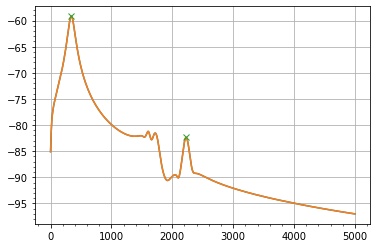

In [205]:
rho = scipy.stats.beta(0.6, 2.4).rvs()

#rho = .01

print("rho =", rho, "=> Dampen ripples on spectrum with period smaller than =", 1/(rho * (Fs / 2)), "Hz")

h = scipy.stats.expon(1.).rvs()
print("Peak prominence: h =", h, "dB")

F, B, context = peak.get_formants_from_spectrum(
    f,
    power,
    rho,
    h,
    return_full=True
)

plot(f, power)
plot(f, context['smoothed'])
plot(F, context['smoothed'][context['peaks']], "x")

plt.grid("on")
plt.minorticks_on()

F, B